# Parameter Tuning
    
    Find best predictive window & best number of splits

# Importing libraries:

In [39]:
import numpy as np;
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler;
from sklearn import metrics;
from sklearn.model_selection import TimeSeriesSplit;
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import LinearRegression

# empty list to append metric values
mae_gen = []
mse_gen  =[]
rmse_gen = []
mae_nor = []
mae_spi = []
mse_nor = []
mse_spi = []
rmse_nor = []
rmse_spi = []

# Data set processing and tuning:

In [40]:
# import data
data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)

# filter max values for offer if required
print(data.Offers.max()) #max is 2500... no need to filter max values

# 2017 & 2018 data
data = data.loc[data.index > 2018090000, :]

# reset index
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)

# Divide features and labels
X = data.iloc[:, 0:15]
y = data.loc[:, 'Offers']

# Fill nan values (BEFORE OR AFTER TEST, TRAIN SPLIT!!!)
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
X.fillna(method = 'ffill', inplace = True)
y.fillna(method = 'ffill', inplace = True)

X = X.astype('float64')
X = X.round(20)

# divide data into train and test with 20% test data
X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.2, shuffle=False)

2500.0


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


# Apply feature scaling:

In [41]:
sc_X = MinMaxScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Importing the Keras libraries and packages:

In [42]:
import keras
from keras.models import Sequential # to initialise the NN
from keras.layers import Dense # to create layers
from keras.layers import Dropout
from keras import optimizers
from keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Create regressor:

In [27]:
# possible debug
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

def regressor_tunning(n_neurons = 10, 
                      n_hidden = 2 , 
                      kernel_initializer="he_normal",
                      bias_initializer= initializers.Ones()):
    model = Sequential()
    model.add(Dense(output_dim = n_neurons, 
                    input_dim = 15))
    model.add(keras.layers.LeakyReLU(alpha = 0.2))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons))
        model.add(keras.layers.LeakyReLU(alpha = 0.2))
    model.add(Dense(output_dim = 1, 
                    activation = 'linear'))
    optimizer = optimizers.Adamax(lr = 0.001)
    model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mse', 'mae'])
    return model

# Apply Randomized tunning for the whole ANN:

In [28]:
regressor = KerasRegressor(build_fn = regressor_tunning)

# Dictionary to include the parameters
parameters = {'n_neurons': np.arange(10,50,5),
              'n_hidden': [1,2,3,4,5,6]
               }

tscv = TimeSeriesSplit(n_splits = 7)

# add some early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='mse', patience = 15)

rnd_search_cv = GridSearchCV(estimator = regressor,
                                   param_grid = parameters,
                                   scoring = 'neg_mean_squared_error',
                                   n_jobs = -1,
                                   cv = tscv)

rnd_search_cv.fit(X_train, y_train, batch_size = 10, epochs = 80, callbacks=[early_stopping])

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000018A4B046A48>, as the constructor either does not set or modifies parameter n_neurons

In [ ]:
best_params_1 = rnd_search_cv.best_params_
best_score_1 = rnd_search_cv.best_score_
#best_estimator = rnd_search_cv.best_estimator_
#results = rnd_search_cv.cv_results_

print("the best parameters are:{}".format(best_params_1))
print("the best score is:{}".format(best_score_1))
#print("the best estimator is:{}".format(best_estimator))
#print("results:".format(results))

# Lets account with spike and normal regions:

In [63]:
from sklearn.model_selection import ParameterGrid
parameters = {'n_neurons': np.arange(10,50,5),
              'n_hidden': [1,2,3,4,5,6]
               }

all_param = ParameterGrid(parameters)

print(len(all_param))
print(all_param[0])
print(all_param[0]['n_neurons'])
print(all_param[0]['n_hidden'])

mae_cv = []
mse_cv = []
mae_gen = []
mse_gen  =[]
rmse_gen = []
mae_nor = []
mae_spi = []
mse_nor = []
mse_spi = []
rmse_nor = []
rmse_spi = []

48
{'n_neurons': 10, 'n_hidden': 1}
10
1


In [64]:
for i in range(len(all_param)):
    # import data
    data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)

    # filter max values for offer if required
    print(data.Offers.max()) #max is 2500... no need to filter max values

    # 3 months of data
    data = data.loc[data.index > 2018090000, :]

    # reset index
    data.reset_index(inplace = True)
    data.drop('index', axis = 1, inplace = True)
    
    # Divide features and labels
    X = data.iloc[:, 0:15]
    y = data.loc[:, 'Offers']
    
    X.fillna(method = 'ffill', inplace = True)
    y.fillna(method = 'ffill', inplace = True)

    # X = X.astype('float64')
    X = X.round(20)

    # divide data into train and test with 20% test data
    X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size=0.2, shuffle=False)

    # feature scaling
    sc_X = MinMaxScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    
    def regressor_tunning(n_hidden = all_param[i]['n_hidden'], 
                          n_neurons = all_param[i]['n_neurons'],  
                          kernel_initializer = "he_normal",
                          bias_initializer = initializers.Ones()):
        model = Sequential()
        model.add(Dense(units = n_neurons, input_dim = 15))
        model.add(keras.layers.LeakyReLU(alpha = 0.2))
        model.add(Dropout(rate = 0.1))
        for layer in range(n_hidden):
            model.add(Dense(n_neurons))
            model.add(keras.layers.LeakyReLU(alpha = 0.2))
            model.add(Dropout(rate = 0.1))
        model.add(Dense(units = 1, activation = 'linear'))
        optimizer = optimizers.Adamax(lr = 0.001)
        model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mse', 'mae'])
        return model

    tscv = TimeSeriesSplit(n_splits = 7)
    hist_list = pd.DataFrame()
    count = 1
    
    regressor = regressor_tunning()
    
    for train_index, test_index in tscv.split(X_train):
          X_train_split, X_test_split = X_train[train_index], X_train[test_index]
          y_train_split, y_test_split = y_train[train_index], y_train[test_index]
          hist = regressor.fit(X_train_split, y_train_split, batch_size = 15, epochs = 80)
          hist_list = hist_list.append(hist.history, ignore_index = True)
          print(count)
          count = count + 1

    a = []
    b = []
    
    for i in range(len(hist_list.mse)):
        a.append(np.mean(hist_list.mse[i]))
        b.append(np.mean(hist_list.mae[i]))
      
    mse_cv.append(np.mean(a))
    mae_cv.append(np.mean(b))
    
    # predict for X_test  
    y_pred = regressor.predict(X_test)

    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mse_error = mse(y_test, y_pred) # 1479.61335
    mae_error = mae(y_test, y_pred) # 23.1525
    
    rmse_gen.append(rmse_error)
    mse_gen.append(mse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])
    
    # create array same size as y_test
    y_spike_occ = y_spike_occ.iloc[- len(y_test):]
    y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values
    
    
    # smal adjustment
    y_test.replace(0, 0.0001,inplace = True)

    
    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mse_spike = mse(y_test_spike, y_pred_spike)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mse_spi.append(mse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mse_normal = mse(y_test_normal, y_pred_normal)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mse_nor.append(mse_normal)
    mae_nor.append(mae_normal)

2500.0
Epoch 1/80


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 848us/step - loss: 17652.0137 - mse: 17652.0137 - mae: 114.2222
Epoch 2/80
40/40 [==============================] - 0s 898us/step - loss: 17532.5215 - mse: 17532.5215 - mae: 113.7178
Epoch 3/80
40/40 [==============================] - 0s 923us/step - loss: 17413.3047 - mse: 17413.3047 - mae: 113.1919
Epoch 4/80
40/40 [==============================] - 0s 947us/step - loss: 17254.8262 - mse: 17254.8262 - mae: 112.4727
Epoch 5/80
40/40 [==============================] - 0s 972us/step - loss: 17073.2715 - mse: 17073.2715 - mae: 111.6617
Epoch 6/80
40/40 [==============================] - 0s 947us/step - loss: 16871.5781 - mse: 16871.5781 - mae: 110.7723
Epoch 7/80
40/40 [==============================] - 0s 998us/step - loss: 16655.5703 - mse: 16655.5703 - mae: 109.8356
Epoch 8/80
40/40 [==============================] - 0s 947us/step - loss: 16369.7041 - mse: 16369.7041 - mae: 108.4931
Epoch 9/80
40/40 [==============================] - 0s 997u

79/79 [==============================] - 0s 736us/step - loss: 3678.4800 - mse: 3678.4800 - mae: 32.2137
Epoch 61/80
79/79 [==============================] - 0s 787us/step - loss: 3842.5608 - mse: 3842.5608 - mae: 33.8007
Epoch 62/80
79/79 [==============================] - 0s 720us/step - loss: 3675.6748 - mse: 3675.6748 - mae: 32.6295
Epoch 63/80
79/79 [==============================] - 0s 884us/step - loss: 3588.8516 - mse: 3588.8516 - mae: 33.0776
Epoch 64/80
79/79 [==============================] - 0s 1ms/step - loss: 3799.4026 - mse: 3799.4026 - mae: 33.6445
Epoch 65/80
79/79 [==============================] - 0s 1ms/step - loss: 3801.9431 - mse: 3801.9431 - mae: 33.3089
Epoch 66/80
79/79 [==============================] - 0s 1ms/step - loss: 3811.5854 - mse: 3811.5854 - mae: 33.3519
Epoch 67/80
79/79 [==============================] - 0s 1ms/step - loss: 3646.9019 - mse: 3646.9019 - mae: 33.2269
Epoch 68/80
79/79 [==============================] - 0s 715us/step - loss: 3705.9333

157/157 [==============================] - 0s 858us/step - loss: 2626.7593 - mse: 2626.7593 - mae: 30.4817
Epoch 39/80
157/157 [==============================] - 0s 895us/step - loss: 2660.4429 - mse: 2660.4429 - mae: 30.7971
Epoch 40/80
157/157 [==============================] - 0s 1ms/step - loss: 2588.5427 - mse: 2588.5427 - mae: 29.9923
Epoch 41/80
157/157 [==============================] - 0s 972us/step - loss: 2551.5630 - mse: 2551.5630 - mae: 30.1093
Epoch 42/80
157/157 [==============================] - 0s 1ms/step - loss: 2578.0056 - mse: 2578.0056 - mae: 30.1333
Epoch 43/80
157/157 [==============================] - 0s 934us/step - loss: 2560.5388 - mse: 2560.5388 - mae: 29.9222
Epoch 44/80
157/157 [==============================] - 0s 1ms/step - loss: 2556.3137 - mse: 2556.3137 - mae: 29.6174
Epoch 45/80
157/157 [==============================] - 0s 737us/step - loss: 2548.4358 - mse: 2548.4358 - mae: 29.8685
Epoch 46/80
157/157 [==============================] - 0s 997us/st

235/235 [==============================] - 0s 1ms/step - loss: 2704.0708 - mse: 2704.0708 - mae: 29.0901: 0s - loss: 4577.6157 - mse: 4577.6157 - mae: 3
Epoch 15/80
235/235 [==============================] - 0s 956us/step - loss: 2681.2979 - mse: 2681.2979 - mae: 29.0161
Epoch 16/80
235/235 [==============================] - 0s 903us/step - loss: 2759.2520 - mse: 2759.2520 - mae: 29.0954
Epoch 17/80
235/235 [==============================] - 0s 1ms/step - loss: 2682.6086 - mse: 2682.6086 - mae: 28.6000
Epoch 18/80
235/235 [==============================] - 0s 1ms/step - loss: 2701.5256 - mse: 2701.5256 - mae: 28.8327
Epoch 19/80
235/235 [==============================] - 0s 1ms/step - loss: 2667.8496 - mse: 2667.8496 - mae: 29.1013
Epoch 20/80
235/235 [==============================] - 0s 1ms/step - loss: 2676.8579 - mse: 2676.8579 - mae: 28.6522
Epoch 21/80
235/235 [==============================] - 0s 1ms/step - loss: 2720.8083 - mse: 2720.8083 - mae: 29.1671
Epoch 22/80
235/235 [===

274/274 [==============================] - 0s 751us/step - loss: 2787.3447 - mse: 2787.3447 - mae: 29.6337
Epoch 72/80
274/274 [==============================] - 0s 681us/step - loss: 2794.5540 - mse: 2794.5540 - mae: 29.5314
Epoch 73/80
274/274 [==============================] - 0s 656us/step - loss: 2764.0876 - mse: 2764.0876 - mae: 29.5671
Epoch 74/80
274/274 [==============================] - 0s 655us/step - loss: 2788.4641 - mse: 2788.4641 - mae: 29.4254
Epoch 75/80
274/274 [==============================] - 0s 729us/step - loss: 2757.5320 - mse: 2757.5320 - mae: 29.3019
Epoch 76/80
274/274 [==============================] - 0s 675us/step - loss: 2761.5103 - mse: 2761.5103 - mae: 29.6207
Epoch 77/80
274/274 [==============================] - 0s 673us/step - loss: 2803.5317 - mse: 2803.5317 - mae: 29.4546
Epoch 78/80
274/274 [==============================] - 0s 653us/step - loss: 2739.8826 - mse: 2739.8826 - mae: 29.3191
Epoch 79/80
274/274 [==============================] - 0s 65

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 798us/step - loss: 17753.8496 - mse: 17753.8496 - mae: 114.6631
Epoch 2/80
40/40 [==============================] - 0s 823us/step - loss: 17573.0508 - mse: 17573.0508 - mae: 113.8706
Epoch 3/80
40/40 [==============================] - 0s 773us/step - loss: 17380.7266 - mse: 17380.7266 - mae: 113.0374
Epoch 4/80
40/40 [==============================] - 0s 798us/step - loss: 17163.3477 - mse: 17163.3477 - mae: 112.0554
Epoch 5/80
40/40 [==============================] - 0s 997us/step - loss: 16879.9023 - mse: 16879.9023 - mae: 110.7893
Epoch 6/80
40/40 [==============================] - 0s 1ms/step - loss: 16490.6309 - mse: 16490.6309 - mae: 109.0295
Epoch 7/80
40/40 [==============================] - 0s 1ms/step - loss: 16025.3945 - mse: 16025.3945 - mae: 106.8830
Epoch 8/80
40/40 [==============================] - 0s 1ms/step - loss: 15569.9102 - mse: 15569.9102 - mae: 104.7558
Epoch 9/80
40/40 [==============================] - 0s 873us/step

Epoch 71/80
40/40 [==============================] - 0s 725us/step - loss: 4811.6479 - mse: 4811.6479 - mae: 28.9081
Epoch 72/80
40/40 [==============================] - 0s 716us/step - loss: 4879.7222 - mse: 4879.7222 - mae: 29.5567
Epoch 73/80
40/40 [==============================] - 0s 710us/step - loss: 4881.3799 - mse: 4881.3799 - mae: 29.7862
Epoch 74/80
40/40 [==============================] - 0s 726us/step - loss: 4919.8525 - mse: 4919.8525 - mae: 29.1378
Epoch 75/80
40/40 [==============================] - 0s 698us/step - loss: 4951.7432 - mse: 4951.7432 - mae: 29.8016
Epoch 76/80
40/40 [==============================] - 0s 698us/step - loss: 4879.5308 - mse: 4879.5308 - mae: 29.3128
Epoch 77/80
40/40 [==============================] - 0s 673us/step - loss: 4862.3706 - mse: 4862.3701 - mae: 29.4624
Epoch 78/80
40/40 [==============================] - 0s 648us/step - loss: 4779.2158 - mse: 4779.2158 - mae: 28.3029
Epoch 79/80
40/40 [==============================] - 0s 648us/st

Epoch 50/80
118/118 [==============================] - 0s 642us/step - loss: 2790.6372 - mse: 2790.6372 - mae: 29.2213
Epoch 51/80
118/118 [==============================] - 0s 651us/step - loss: 2825.2905 - mse: 2825.2903 - mae: 29.1000
Epoch 52/80
118/118 [==============================] - 0s 642us/step - loss: 2804.8943 - mse: 2804.8943 - mae: 29.0850
Epoch 53/80
118/118 [==============================] - 0s 651us/step - loss: 2752.8020 - mse: 2752.8020 - mae: 28.6716
Epoch 54/80
118/118 [==============================] - 0s 718us/step - loss: 2804.3713 - mse: 2804.3713 - mae: 28.8470
Epoch 55/80
118/118 [==============================] - 0s 745us/step - loss: 2843.5505 - mse: 2843.5503 - mae: 29.5446
Epoch 56/80
118/118 [==============================] - 0s 655us/step - loss: 2793.2937 - mse: 2793.2937 - mae: 28.8740
Epoch 57/80
118/118 [==============================] - 0s 694us/step - loss: 2777.2339 - mse: 2777.2339 - mae: 28.7678
Epoch 58/80
118/118 [===========================

196/196 [==============================] - 0s 728us/step - loss: 2233.9968 - mse: 2233.9968 - mae: 28.3342
Epoch 28/80
196/196 [==============================] - 0s 647us/step - loss: 2288.0261 - mse: 2288.0261 - mae: 28.9326
Epoch 29/80
196/196 [==============================] - 0s 649us/step - loss: 2256.0903 - mse: 2256.0903 - mae: 28.2643
Epoch 30/80
196/196 [==============================] - 0s 647us/step - loss: 2191.4873 - mse: 2191.4873 - mae: 28.1435
Epoch 31/80
196/196 [==============================] - 0s 679us/step - loss: 2285.1213 - mse: 2285.1213 - mae: 28.2996
Epoch 32/80
196/196 [==============================] - 0s 636us/step - loss: 2249.1992 - mse: 2249.1992 - mae: 28.3224
Epoch 33/80
196/196 [==============================] - 0s 678us/step - loss: 2219.0046 - mse: 2219.0046 - mae: 27.9740
Epoch 34/80
196/196 [==============================] - 0s 860us/step - loss: 2268.9111 - mse: 2268.9111 - mae: 28.2997
Epoch 35/80
196/196 [==============================] - 0s 80

274/274 [==============================] - 0s 779us/step - loss: 2721.7661 - mse: 2721.7661 - mae: 28.8745
Epoch 4/80
274/274 [==============================] - 0s 806us/step - loss: 2709.3127 - mse: 2709.3127 - mae: 28.9135
Epoch 5/80
274/274 [==============================] - 0s 726us/step - loss: 2696.3569 - mse: 2696.3569 - mae: 28.8546
Epoch 6/80
274/274 [==============================] - 0s 815us/step - loss: 2696.8420 - mse: 2696.8420 - mae: 28.9340
Epoch 7/80
274/274 [==============================] - 0s 725us/step - loss: 2722.0640 - mse: 2722.0640 - mae: 28.7320
Epoch 8/80
274/274 [==============================] - 0s 657us/step - loss: 2741.5784 - mse: 2741.5784 - mae: 29.0662
Epoch 9/80
274/274 [==============================] - 0s 701us/step - loss: 2689.8486 - mse: 2689.8486 - mae: 28.6106
Epoch 10/80
274/274 [==============================] - 0s 738us/step - loss: 2698.8828 - mse: 2698.8828 - mae: 28.5399
Epoch 11/80
274/274 [==============================] - 0s 665us/st

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 698us/step - loss: 17473.5156 - mse: 17473.5156 - mae: 113.4280
Epoch 2/80
40/40 [==============================] - 0s 698us/step - loss: 17173.7695 - mse: 17173.7695 - mae: 112.1222
Epoch 3/80
40/40 [==============================] - 0s 673us/step - loss: 16823.9922 - mse: 16823.9922 - mae: 110.5370
Epoch 4/80
40/40 [==============================] - 0s 723us/step - loss: 16346.4902 - mse: 16346.4902 - mae: 108.4006
Epoch 5/80
40/40 [==============================] - 0s 723us/step - loss: 15792.9082 - mse: 15792.9082 - mae: 105.8119
Epoch 6/80
40/40 [==============================] - 0s 765us/step - loss: 15050.9580 - mse: 15050.9580 - mae: 102.3077
Epoch 7/80
40/40 [==============================] - 0s 712us/step - loss: 14342.6992 - mse: 14342.6992 - mae: 98.5618
Epoch 8/80
40/40 [==============================] - 0s 651us/step - loss: 13367.7979 - mse: 13367.7979 - mae: 93.5357
Epoch 9/80
40/40 [==============================] - 0s 689us/

Epoch 71/80
40/40 [==============================] - 0s 823us/step - loss: 4665.0757 - mse: 4665.0757 - mae: 27.9552
Epoch 72/80
40/40 [==============================] - 0s 848us/step - loss: 4757.7739 - mse: 4757.7739 - mae: 27.8632
Epoch 73/80
40/40 [==============================] - 0s 798us/step - loss: 4715.3672 - mse: 4715.3672 - mae: 27.8617
Epoch 74/80
40/40 [==============================] - 0s 798us/step - loss: 4792.1665 - mse: 4792.1665 - mae: 27.8880
Epoch 75/80
40/40 [==============================] - 0s 748us/step - loss: 4725.0615 - mse: 4725.0615 - mae: 27.5284
Epoch 76/80
40/40 [==============================] - 0s 773us/step - loss: 4717.0132 - mse: 4717.0132 - mae: 27.5558
Epoch 77/80
40/40 [==============================] - 0s 748us/step - loss: 4761.2393 - mse: 4761.2393 - mae: 27.5798
Epoch 78/80
40/40 [==============================] - 0s 773us/step - loss: 4735.2124 - mse: 4735.2124 - mae: 28.4584
Epoch 79/80
40/40 [==============================] - 0s 723us/st

79/79 [==============================] - 0s 719us/step - loss: 3456.9170 - mse: 3456.9170 - mae: 31.2721
Epoch 62/80
79/79 [==============================] - 0s 619us/step - loss: 3459.0149 - mse: 3459.0149 - mae: 30.5652
Epoch 63/80
79/79 [==============================] - 0s 619us/step - loss: 3439.7751 - mse: 3439.7751 - mae: 30.4262
Epoch 64/80
79/79 [==============================] - 0s 619us/step - loss: 3524.2573 - mse: 3524.2573 - mae: 31.4488
Epoch 65/80
79/79 [==============================] - 0s 619us/step - loss: 3422.0098 - mse: 3422.0098 - mae: 30.3646
Epoch 66/80
79/79 [==============================] - 0s 619us/step - loss: 3469.7195 - mse: 3469.7195 - mae: 30.3931
Epoch 67/80
79/79 [==============================] - 0s 674us/step - loss: 3449.5059 - mse: 3449.5059 - mae: 30.5286
Epoch 68/80
79/79 [==============================] - 0s 674us/step - loss: 3423.7573 - mse: 3423.7573 - mae: 30.8787
Epoch 69/80
79/79 [==============================] - 0s 663us/step - loss: 3

157/157 [==============================] - 0s 762us/step - loss: 2408.6638 - mse: 2408.6638 - mae: 28.1185
Epoch 38/80
157/157 [==============================] - 0s 997us/step - loss: 2398.3699 - mse: 2398.3699 - mae: 28.3508
Epoch 39/80
157/157 [==============================] - 0s 876us/step - loss: 2390.2793 - mse: 2390.2793 - mae: 28.2847
Epoch 40/80
157/157 [==============================] - 0s 839us/step - loss: 2435.1409 - mse: 2435.1409 - mae: 28.3372
Epoch 41/80
157/157 [==============================] - 0s 739us/step - loss: 2376.2351 - mse: 2376.2351 - mae: 27.7484
Epoch 42/80
157/157 [==============================] - 0s 698us/step - loss: 2395.6987 - mse: 2395.6987 - mae: 27.9978
Epoch 43/80
157/157 [==============================] - 0s 838us/step - loss: 2414.0176 - mse: 2414.0176 - mae: 28.0310
Epoch 44/80
157/157 [==============================] - 0s 731us/step - loss: 2428.5007 - mse: 2428.5007 - mae: 28.5040
Epoch 45/80
157/157 [==============================] - 0s 70

235/235 [==============================] - 0s 669us/step - loss: 2550.4084 - mse: 2550.4084 - mae: 27.5173
Epoch 15/80
235/235 [==============================] - 0s 682us/step - loss: 2558.4133 - mse: 2558.4133 - mae: 27.4370
Epoch 16/80
235/235 [==============================] - 0s 772us/step - loss: 2581.4485 - mse: 2581.4485 - mae: 27.5051
Epoch 17/80
235/235 [==============================] - 0s 772us/step - loss: 2608.3914 - mse: 2608.3914 - mae: 27.5503
Epoch 18/80
235/235 [==============================] - 0s 692us/step - loss: 2568.8293 - mse: 2568.8293 - mae: 27.6189
Epoch 19/80
235/235 [==============================] - 0s 731us/step - loss: 2554.8660 - mse: 2554.8660 - mae: 27.5211
Epoch 20/80
235/235 [==============================] - 0s 815us/step - loss: 2549.5510 - mse: 2549.5510 - mae: 27.2737
Epoch 21/80
235/235 [==============================] - 0s 813us/step - loss: 2564.0576 - mse: 2564.0576 - mae: 27.5876
Epoch 22/80
235/235 [==============================] - 0s 68

Epoch 3/80
274/274 [==============================] - 0s 914us/step - loss: 2664.7275 - mse: 2664.7275 - mae: 28.0882
Epoch 4/80
274/274 [==============================] - 0s 791us/step - loss: 2676.3289 - mse: 2676.3289 - mae: 28.5239
Epoch 5/80
274/274 [==============================] - 0s 777us/step - loss: 2633.1670 - mse: 2633.1672 - mae: 27.8997
Epoch 6/80
274/274 [==============================] - 0s 797us/step - loss: 2681.9998 - mse: 2682.0000 - mae: 28.1143
Epoch 7/80
274/274 [==============================] - 0s 767us/step - loss: 2633.6514 - mse: 2633.6514 - mae: 28.2649
Epoch 8/80
274/274 [==============================] - 0s 670us/step - loss: 2660.3882 - mse: 2660.3882 - mae: 28.2798
Epoch 9/80
274/274 [==============================] - 0s 715us/step - loss: 2587.8118 - mse: 2587.8118 - mae: 27.7825
Epoch 10/80
274/274 [==============================] - 0s 678us/step - loss: 2663.8257 - mse: 2663.8257 - mae: 28.3701
Epoch 11/80
274/274 [==============================] - 

Epoch 72/80
274/274 [==============================] - 0s 702us/step - loss: 2622.8896 - mse: 2622.8896 - mae: 28.0393
Epoch 73/80
274/274 [==============================] - 0s 764us/step - loss: 2611.5176 - mse: 2611.5176 - mae: 27.8419
Epoch 74/80
274/274 [==============================] - 0s 782us/step - loss: 2598.9214 - mse: 2598.9214 - mae: 27.8393
Epoch 75/80
274/274 [==============================] - 0s 713us/step - loss: 2606.8557 - mse: 2606.8557 - mae: 27.6364
Epoch 76/80
274/274 [==============================] - 0s 660us/step - loss: 2656.9487 - mse: 2656.9487 - mae: 27.8643
Epoch 77/80
274/274 [==============================] - 0s 648us/step - loss: 2620.7505 - mse: 2620.7505 - mae: 27.7793 - loss: 1636.4990 - mse: 1636.4990 - mae: 2
Epoch 78/80
274/274 [==============================] - 0s 653us/step - loss: 2602.6111 - mse: 2602.6111 - mae: 27.9835
Epoch 79/80
274/274 [==============================] - 0s 645us/step - loss: 2617.6577 - mse: 2617.6577 - mae: 27.7133
Epoc

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 698us/step - loss: 17633.2090 - mse: 17633.2090 - mae: 114.1434
Epoch 2/80
40/40 [==============================] - 0s 673us/step - loss: 17434.2422 - mse: 17434.2422 - mae: 113.2763
Epoch 3/80
40/40 [==============================] - 0s 698us/step - loss: 17163.3242 - mse: 17163.3242 - mae: 112.0501
Epoch 4/80
40/40 [==============================] - 0s 748us/step - loss: 16740.2109 - mse: 16740.2109 - mae: 110.1887
Epoch 5/80
40/40 [==============================] - 0s 773us/step - loss: 16127.0391 - mse: 16127.0391 - mae: 107.3807
Epoch 6/80
40/40 [==============================] - 0s 997us/step - loss: 15397.0420 - mse: 15397.0420 - mae: 103.8984
Epoch 7/80
40/40 [==============================] - 0s 823us/step - loss: 14487.4990 - mse: 14487.4990 - mae: 99.4188
Epoch 8/80
40/40 [==============================] - 0s 773us/step - loss: 13512.9463 - mse: 13512.9463 - mae: 94.3230
Epoch 9/80
40/40 [==============================] - 0s 798us/

40/40 [==============================] - 0s 873us/step - loss: 4758.7510 - mse: 4758.7510 - mae: 27.5367
Epoch 72/80
40/40 [==============================] - 0s 898us/step - loss: 4706.9751 - mse: 4706.9751 - mae: 26.9749
Epoch 73/80
40/40 [==============================] - 0s 972us/step - loss: 4628.2534 - mse: 4628.2534 - mae: 27.4249
Epoch 74/80
40/40 [==============================] - 0s 798us/step - loss: 4563.4502 - mse: 4563.4502 - mae: 26.7405
Epoch 75/80
40/40 [==============================] - 0s 848us/step - loss: 4738.3828 - mse: 4738.3828 - mae: 28.0540
Epoch 76/80
40/40 [==============================] - 0s 873us/step - loss: 4776.4019 - mse: 4776.4019 - mae: 27.5773
Epoch 77/80
40/40 [==============================] - 0s 748us/step - loss: 4699.6279 - mse: 4699.6279 - mae: 28.3174
Epoch 78/80
40/40 [==============================] - 0s 748us/step - loss: 4727.7197 - mse: 4727.7197 - mae: 28.2551
Epoch 79/80
40/40 [==============================] - 0s 698us/step - loss: 4

118/118 [==============================] - 0s 688us/step - loss: 2683.6816 - mse: 2683.6816 - mae: 28.0385
Epoch 50/80
118/118 [==============================] - 0s 693us/step - loss: 2707.5681 - mse: 2707.5681 - mae: 28.1545
Epoch 51/80
118/118 [==============================] - 0s 820us/step - loss: 2736.1128 - mse: 2736.1128 - mae: 28.0109
Epoch 52/80
118/118 [==============================] - 0s 811us/step - loss: 2685.9167 - mse: 2685.9167 - mae: 28.0381
Epoch 53/80
118/118 [==============================] - 0s 1ms/step - loss: 2598.9998 - mse: 2598.9998 - mae: 27.5650
Epoch 54/80
118/118 [==============================] - 0s 896us/step - loss: 2611.7319 - mse: 2611.7319 - mae: 27.8235
Epoch 55/80
118/118 [==============================] - 0s 946us/step - loss: 2735.2129 - mse: 2735.2129 - mae: 28.3253
Epoch 56/80
118/118 [==============================] - 0s 765us/step - loss: 2631.8464 - mse: 2631.8464 - mae: 27.9417
Epoch 57/80
118/118 [==============================] - 0s 794u

157/157 [==============================] - 0s 656us/step - loss: 2372.7432 - mse: 2372.7432 - mae: 27.7778
Epoch 39/80
157/157 [==============================] - 0s 667us/step - loss: 2336.9919 - mse: 2336.9919 - mae: 27.3097
Epoch 40/80
157/157 [==============================] - 0s 750us/step - loss: 2358.4502 - mse: 2358.4502 - mae: 27.7746
Epoch 41/80
157/157 [==============================] - 0s 800us/step - loss: 2316.9216 - mse: 2316.9216 - mae: 27.3134
Epoch 42/80
157/157 [==============================] - 0s 877us/step - loss: 2394.5139 - mse: 2394.5139 - mae: 27.7885
Epoch 43/80
157/157 [==============================] - 0s 877us/step - loss: 2348.5632 - mse: 2348.5632 - mae: 27.5267
Epoch 44/80
157/157 [==============================] - 0s 979us/step - loss: 2375.9482 - mse: 2375.9482 - mae: 27.7703
Epoch 45/80
157/157 [==============================] - 0s 747us/step - loss: 2363.1089 - mse: 2363.1089 - mae: 27.6681
Epoch 46/80
157/157 [==============================] - 0s 69

235/235 [==============================] - 0s 921us/step - loss: 2549.6411 - mse: 2549.6411 - mae: 27.2977
Epoch 16/80
235/235 [==============================] - 0s 768us/step - loss: 2546.8625 - mse: 2546.8625 - mae: 27.2515
Epoch 17/80
235/235 [==============================] - 0s 692us/step - loss: 2567.2231 - mse: 2567.2231 - mae: 27.2535
Epoch 18/80
235/235 [==============================] - 0s 700us/step - loss: 2541.2341 - mse: 2541.2341 - mae: 27.3100
Epoch 19/80
235/235 [==============================] - 0s 665us/step - loss: 2561.8894 - mse: 2561.8894 - mae: 27.0240
Epoch 20/80
235/235 [==============================] - 0s 751us/step - loss: 2546.9761 - mse: 2546.9761 - mae: 27.1373
Epoch 21/80
235/235 [==============================] - 0s 815us/step - loss: 2521.4678 - mse: 2521.4678 - mae: 27.00690s - loss: 2715.9673 - mse: 2715.9673 - mae: 27.10
Epoch 22/80
235/235 [==============================] - 0s 762us/step - loss: 2530.3650 - mse: 2530.3650 - mae: 26.9728
Epoch 23/8

274/274 [==============================] - 0s 797us/step - loss: 2563.2322 - mse: 2563.2322 - mae: 27.8628
Epoch 72/80
274/274 [==============================] - 0s 997us/step - loss: 2587.2527 - mse: 2587.2527 - mae: 27.6079
Epoch 73/80
274/274 [==============================] - 0s 903us/step - loss: 2614.8071 - mse: 2614.8071 - mae: 27.8589
Epoch 74/80
274/274 [==============================] - 0s 903us/step - loss: 2574.7119 - mse: 2574.7119 - mae: 27.4564
Epoch 75/80
274/274 [==============================] - 0s 954us/step - loss: 2594.0581 - mse: 2594.0581 - mae: 27.6383
Epoch 76/80
274/274 [==============================] - 0s 993us/step - loss: 2584.1086 - mse: 2584.1086 - mae: 27.5225
Epoch 77/80
274/274 [==============================] - 0s 710us/step - loss: 2594.5527 - mse: 2594.5527 - mae: 27.8698
Epoch 78/80
274/274 [==============================] - 0s 678us/step - loss: 2604.7698 - mse: 2604.7698 - mae: 27.8149
Epoch 79/80
274/274 [==============================] - 0s 67

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 748us/step - loss: 17594.2715 - mse: 17594.2715 - mae: 113.9809
Epoch 2/80
40/40 [==============================] - 0s 748us/step - loss: 17289.1582 - mse: 17289.1582 - mae: 112.6447
Epoch 3/80
40/40 [==============================] - 0s 648us/step - loss: 16922.4062 - mse: 16922.4062 - mae: 110.9954
Epoch 4/80
40/40 [==============================] - 0s 665us/step - loss: 16527.1211 - mse: 16527.1211 - mae: 109.1954
Epoch 5/80
40/40 [==============================] - 0s 643us/step - loss: 15887.6396 - mse: 15887.6396 - mae: 106.2393
Epoch 6/80
40/40 [==============================] - 0s 659us/step - loss: 14961.5059 - mse: 14961.5059 - mae: 101.7879
Epoch 7/80
40/40 [==============================] - 0s 644us/step - loss: 13790.4521 - mse: 13790.4502 - mae: 95.8802
Epoch 8/80
40/40 [==============================] - 0s 673us/step - loss: 12583.6855 - mse: 12583.6855 - mae: 89.2324
Epoch 9/80
40/40 [==============================] - 0s 723us/

40/40 [==============================] - 0s 1ms/step - loss: 4619.5825 - mse: 4619.5825 - mae: 26.6723
Epoch 72/80
40/40 [==============================] - 0s 1ms/step - loss: 4614.2803 - mse: 4614.2803 - mae: 27.1657
Epoch 73/80
40/40 [==============================] - 0s 947us/step - loss: 4635.6538 - mse: 4635.6538 - mae: 27.0690
Epoch 74/80
40/40 [==============================] - 0s 972us/step - loss: 4697.5537 - mse: 4697.5542 - mae: 27.0492
Epoch 75/80
40/40 [==============================] - 0s 972us/step - loss: 4678.8569 - mse: 4678.8569 - mae: 27.0803
Epoch 76/80
40/40 [==============================] - 0s 1ms/step - loss: 4621.6694 - mse: 4621.6694 - mae: 26.6325
Epoch 77/80
40/40 [==============================] - 0s 848us/step - loss: 4664.1660 - mse: 4664.1660 - mae: 26.1034
Epoch 78/80
40/40 [==============================] - 0s 838us/step - loss: 4628.5381 - mse: 4628.5381 - mae: 27.5987
Epoch 79/80
40/40 [==============================] - 0s 917us/step - loss: 4628.21

118/118 [==============================] - 0s 794us/step - loss: 2676.1155 - mse: 2676.1155 - mae: 27.6118
Epoch 51/80
118/118 [==============================] - 0s 845us/step - loss: 2628.4858 - mse: 2628.4858 - mae: 27.6393
Epoch 52/80
118/118 [==============================] - 0s 879us/step - loss: 2644.9609 - mse: 2644.9609 - mae: 27.8219
Epoch 53/80
118/118 [==============================] - 0s 947us/step - loss: 2649.9072 - mse: 2649.9072 - mae: 27.3256
Epoch 54/80
118/118 [==============================] - 0s 964us/step - loss: 2630.4829 - mse: 2630.4829 - mae: 27.3112
Epoch 55/80
118/118 [==============================] - 0s 938us/step - loss: 2640.9204 - mse: 2640.9204 - mae: 27.5025
Epoch 56/80
118/118 [==============================] - 0s 1ms/step - loss: 2627.3872 - mse: 2627.3872 - mae: 27.6849
Epoch 57/80
118/118 [==============================] - 0s 1ms/step - loss: 2632.2119 - mse: 2632.2119 - mae: 27.3032
Epoch 58/80
118/118 [==============================] - 0s 938us/

157/157 [==============================] - 0s 774us/step - loss: 2340.9385 - mse: 2340.9385 - mae: 27.5447
Epoch 40/80
157/157 [==============================] - 0s 800us/step - loss: 2310.4404 - mse: 2310.4404 - mae: 27.7268
Epoch 41/80
157/157 [==============================] - 0s 1ms/step - loss: 2315.5723 - mse: 2315.5723 - mae: 27.2519
Epoch 42/80
157/157 [==============================] - 0s 890us/step - loss: 2346.2693 - mse: 2346.2693 - mae: 27.3428
Epoch 43/80
157/157 [==============================] - 0s 883us/step - loss: 2336.8835 - mse: 2336.8835 - mae: 27.6089
Epoch 44/80
157/157 [==============================] - 0s 732us/step - loss: 2342.1086 - mse: 2342.1086 - mae: 27.4750
Epoch 45/80
157/157 [==============================] - 0s 697us/step - loss: 2331.9177 - mse: 2331.9177 - mae: 27.5505
Epoch 46/80
157/157 [==============================] - 0s 927us/step - loss: 2327.1848 - mse: 2327.1848 - mae: 27.4359
Epoch 47/80
157/157 [==============================] - 0s 1ms/

235/235 [==============================] - 0s 742us/step - loss: 2529.6724 - mse: 2529.6724 - mae: 27.0163
Epoch 16/80
235/235 [==============================] - 0s 705us/step - loss: 2500.9141 - mse: 2500.9141 - mae: 26.7416
Epoch 17/80
235/235 [==============================] - 0s 751us/step - loss: 2506.7532 - mse: 2506.7532 - mae: 26.7145
Epoch 18/80
235/235 [==============================] - 0s 921us/step - loss: 2511.6667 - mse: 2511.6667 - mae: 26.8706
Epoch 19/80
235/235 [==============================] - 0s 756us/step - loss: 2507.3171 - mse: 2507.3171 - mae: 26.8497
Epoch 20/80
235/235 [==============================] - 0s 717us/step - loss: 2533.6487 - mse: 2533.6487 - mae: 26.8654
Epoch 21/80
235/235 [==============================] - 0s 681us/step - loss: 2508.0752 - mse: 2508.0752 - mae: 26.9208
Epoch 22/80
235/235 [==============================] - 0s 663us/step - loss: 2505.0674 - mse: 2505.0674 - mae: 26.7438
Epoch 23/80
235/235 [==============================] - 0s 67

Epoch 4/80
274/274 [==============================] - 0s 700us/step - loss: 2568.5527 - mse: 2568.5527 - mae: 27.5968
Epoch 5/80
274/274 [==============================] - 0s 680us/step - loss: 2600.0889 - mse: 2600.0889 - mae: 27.7868
Epoch 6/80
274/274 [==============================] - 0s 692us/step - loss: 2613.4448 - mse: 2613.4448 - mae: 27.6380
Epoch 7/80
274/274 [==============================] - 0s 728us/step - loss: 2588.8186 - mse: 2588.8186 - mae: 27.5452
Epoch 8/80
274/274 [==============================] - 0s 681us/step - loss: 2579.8352 - mse: 2579.8352 - mae: 27.6620
Epoch 9/80
274/274 [==============================] - 0s 666us/step - loss: 2594.4746 - mse: 2594.4746 - mae: 27.3690
Epoch 10/80
274/274 [==============================] - 0s 793us/step - loss: 2593.3281 - mse: 2593.3281 - mae: 27.8152
Epoch 11/80
274/274 [==============================] - 0s 806us/step - loss: 2595.3879 - mse: 2595.3879 - mae: 27.8671
Epoch 12/80
274/274 [==============================] -

Epoch 73/80
274/274 [==============================] - 0s 821us/step - loss: 2574.8965 - mse: 2574.8965 - mae: 27.3115
Epoch 74/80
274/274 [==============================] - 0s 804us/step - loss: 2589.9321 - mse: 2589.9321 - mae: 27.7372
Epoch 75/80
274/274 [==============================] - 0s 802us/step - loss: 2586.1343 - mse: 2586.1343 - mae: 27.6678
Epoch 76/80
274/274 [==============================] - 0s 730us/step - loss: 2555.7876 - mse: 2555.7876 - mae: 27.1882
Epoch 77/80
274/274 [==============================] - 0s 751us/step - loss: 2593.3696 - mse: 2593.3696 - mae: 27.8244
Epoch 78/80
274/274 [==============================] - 0s 900us/step - loss: 2573.2878 - mse: 2573.2878 - mae: 27.5800
Epoch 79/80
274/274 [==============================] - 0s 777us/step - loss: 2564.4492 - mse: 2564.4492 - mae: 27.1526
Epoch 80/80
274/274 [==============================] - 0s 714us/step - loss: 2556.6792 - mse: 2556.6792 - mae: 27.3628
7
2500.0
Epoch 1/80


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 648us/step - loss: 17553.4395 - mse: 17553.4395 - mae: 113.7993
Epoch 2/80
40/40 [==============================] - 0s 623us/step - loss: 17141.8848 - mse: 17141.8848 - mae: 111.9729
Epoch 3/80
40/40 [==============================] - 0s 623us/step - loss: 16576.7910 - mse: 16576.7910 - mae: 109.3883
Epoch 4/80
40/40 [==============================] - 0s 648us/step - loss: 15714.2490 - mse: 15714.2490 - mae: 105.3643
Epoch 5/80
40/40 [==============================] - 0s 648us/step - loss: 14494.6836 - mse: 14494.6836 - mae: 99.4768
Epoch 6/80
40/40 [==============================] - 0s 723us/step - loss: 13212.0537 - mse: 13212.0537 - mae: 92.8698
Epoch 7/80
40/40 [==============================] - 0s 723us/step - loss: 11725.2441 - mse: 11725.2441 - mae: 84.6276
Epoch 8/80
40/40 [==============================] - 0s 748us/step - loss: 10332.0664 - mse: 10332.0664 - mae: 75.7804
Epoch 9/80
40/40 [==============================] - 0s 823us/st

40/40 [==============================] - 0s 898us/step - loss: 4638.2422 - mse: 4638.2422 - mae: 27.2315
Epoch 72/80
40/40 [==============================] - 0s 923us/step - loss: 4771.4448 - mse: 4771.4448 - mae: 27.2397
Epoch 73/80
40/40 [==============================] - 0s 997us/step - loss: 4706.3950 - mse: 4706.3950 - mae: 27.2757
Epoch 74/80
40/40 [==============================] - 0s 1ms/step - loss: 4559.5215 - mse: 4559.5215 - mae: 26.9382
Epoch 75/80
40/40 [==============================] - 0s 997us/step - loss: 4687.2573 - mse: 4687.2573 - mae: 26.7665
Epoch 76/80
40/40 [==============================] - 0s 997us/step - loss: 4665.8701 - mse: 4665.8701 - mae: 27.0212
Epoch 77/80
40/40 [==============================] - 0s 1ms/step - loss: 4726.0396 - mse: 4726.0396 - mae: 27.4457
Epoch 78/80
40/40 [==============================] - 0s 1ms/step - loss: 4696.6343 - mse: 4696.6343 - mae: 26.5579
Epoch 79/80
40/40 [==============================] - 0s 1ms/step - loss: 4631.6562

118/118 [==============================] - 0s 729us/step - loss: 2654.7354 - mse: 2654.7354 - mae: 27.6122
Epoch 50/80
118/118 [==============================] - 0s 735us/step - loss: 2623.3521 - mse: 2623.3521 - mae: 27.6483
Epoch 51/80
118/118 [==============================] - 0s 731us/step - loss: 2585.9177 - mse: 2585.9177 - mae: 27.4134
Epoch 52/80
118/118 [==============================] - 0s 755us/step - loss: 2646.3582 - mse: 2646.3582 - mae: 27.3892
Epoch 53/80
118/118 [==============================] - 0s 786us/step - loss: 2634.9619 - mse: 2634.9619 - mae: 27.3892
Epoch 54/80
118/118 [==============================] - 0s 769us/step - loss: 2625.2461 - mse: 2625.2461 - mae: 27.1943
Epoch 55/80
118/118 [==============================] - 0s 794us/step - loss: 2584.5994 - mse: 2584.5994 - mae: 27.0774
Epoch 56/80
118/118 [==============================] - 0s 778us/step - loss: 2640.7563 - mse: 2640.7563 - mae: 27.6017
Epoch 57/80
118/118 [==============================] - 0s 72

157/157 [==============================] - 0s 761us/step - loss: 2307.2976 - mse: 2307.2976 - mae: 27.3551
Epoch 39/80
157/157 [==============================] - 0s 735us/step - loss: 2274.7139 - mse: 2274.7139 - mae: 27.2051
Epoch 40/80
157/157 [==============================] - 0s 711us/step - loss: 2280.4626 - mse: 2280.4626 - mae: 27.1950
Epoch 41/80
157/157 [==============================] - 0s 746us/step - loss: 2355.1873 - mse: 2355.1873 - mae: 27.3064
Epoch 42/80
157/157 [==============================] - 0s 715us/step - loss: 2339.3867 - mse: 2339.3867 - mae: 27.4264
Epoch 43/80
157/157 [==============================] - 0s 737us/step - loss: 2335.0679 - mse: 2335.0679 - mae: 27.6783
Epoch 44/80
157/157 [==============================] - 0s 712us/step - loss: 2304.6929 - mse: 2304.6929 - mae: 27.2612
Epoch 45/80
157/157 [==============================] - 0s 718us/step - loss: 2309.8958 - mse: 2309.8958 - mae: 27.1499
Epoch 46/80
157/157 [==============================] - 0s 71

235/235 [==============================] - 0s 1ms/step - loss: 2499.3430 - mse: 2499.3430 - mae: 26.5531
Epoch 17/80
235/235 [==============================] - 0s 1ms/step - loss: 2498.6775 - mse: 2498.6775 - mae: 26.7169
Epoch 18/80
235/235 [==============================] - 0s 1ms/step - loss: 2503.4978 - mse: 2503.4978 - mae: 26.5272
Epoch 19/80
235/235 [==============================] - 0s 1ms/step - loss: 2491.0190 - mse: 2491.0190 - mae: 26.8371
Epoch 20/80
235/235 [==============================] - 0s 1ms/step - loss: 2494.5618 - mse: 2494.5618 - mae: 26.7902
Epoch 21/80
235/235 [==============================] - 0s 1ms/step - loss: 2494.8264 - mse: 2494.8264 - mae: 26.8651
Epoch 22/80
235/235 [==============================] - 0s 1ms/step - loss: 2523.6584 - mse: 2523.6584 - mae: 26.6473
Epoch 23/80
235/235 [==============================] - 0s 1ms/step - loss: 2484.1313 - mse: 2484.1313 - mae: 26.8389
Epoch 24/80
235/235 [==============================] - 0s 1ms/step - loss: 2

274/274 [==============================] - 0s 1ms/step - loss: 2558.2839 - mse: 2558.2839 - mae: 27.0595
Epoch 76/80
274/274 [==============================] - 0s 997us/step - loss: 2563.5085 - mse: 2563.5085 - mae: 27.6946
Epoch 77/80
274/274 [==============================] - 0s 1ms/step - loss: 2540.8433 - mse: 2540.8433 - mae: 27.2829
Epoch 78/80
274/274 [==============================] - 0s 1ms/step - loss: 2543.6870 - mse: 2543.6870 - mae: 27.5314
Epoch 79/80
274/274 [==============================] - 0s 1ms/step - loss: 2552.2339 - mse: 2552.2339 - mae: 27.1176
Epoch 80/80
274/274 [==============================] - 0s 1ms/step - loss: 2544.1887 - mse: 2544.1887 - mae: 27.0703
7
2500.0
Epoch 1/80


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 898us/step - loss: 17576.9180 - mse: 17576.9180 - mae: 113.8882
Epoch 2/80
40/40 [==============================] - 0s 972us/step - loss: 17233.2422 - mse: 17233.2422 - mae: 112.3824
Epoch 3/80
40/40 [==============================] - 0s 823us/step - loss: 16585.3789 - mse: 16585.3789 - mae: 109.4519
Epoch 4/80
40/40 [==============================] - 0s 933us/step - loss: 15686.7002 - mse: 15686.7002 - mae: 105.2974
Epoch 5/80
40/40 [==============================] - 0s 997us/step - loss: 14504.1709 - mse: 14504.1709 - mae: 99.6795
Epoch 6/80
40/40 [==============================] - 0s 948us/step - loss: 13095.3066 - mse: 13095.3066 - mae: 92.2793
Epoch 7/80
40/40 [==============================] - 0s 973us/step - loss: 11538.1709 - mse: 11538.1709 - mae: 83.4518
Epoch 8/80
40/40 [==============================] - 0s 922us/step - loss: 10078.6113 - mse: 10078.6113 - mae: 74.1624
Epoch 9/80
40/40 [==============================] - 0s 997us/st

79/79 [==============================] - 0s 1ms/step - loss: 3353.2375 - mse: 3353.2375 - mae: 29.2824
Epoch 63/80
79/79 [==============================] - 0s 1ms/step - loss: 3359.8723 - mse: 3359.8723 - mae: 29.8108
Epoch 64/80
79/79 [==============================] - 0s 1ms/step - loss: 3334.9778 - mse: 3334.9778 - mae: 29.4331
Epoch 65/80
79/79 [==============================] - 0s 1ms/step - loss: 3362.5134 - mse: 3362.5134 - mae: 30.0123
Epoch 66/80
79/79 [==============================] - 0s 1ms/step - loss: 3325.4512 - mse: 3325.4512 - mae: 29.3869
Epoch 67/80
79/79 [==============================] - 0s 1ms/step - loss: 3326.9036 - mse: 3326.9036 - mae: 29.4674
Epoch 68/80
79/79 [==============================] - 0s 1ms/step - loss: 3358.7842 - mse: 3358.7842 - mae: 29.0454
Epoch 69/80
79/79 [==============================] - 0s 1ms/step - loss: 3387.3911 - mse: 3387.3911 - mae: 29.4470
Epoch 70/80
79/79 [==============================] - 0s 1ms/step - loss: 3395.6936 - mse: 33

157/157 [==============================] - 0s 978us/step - loss: 2296.6250 - mse: 2296.6250 - mae: 27.1559
Epoch 43/80
157/157 [==============================] - 0s 991us/step - loss: 2304.2432 - mse: 2304.2432 - mae: 27.0554
Epoch 44/80
157/157 [==============================] - 0s 889us/step - loss: 2311.5864 - mse: 2311.5864 - mae: 27.4060
Epoch 45/80
157/157 [==============================] - 0s 889us/step - loss: 2325.9626 - mse: 2325.9626 - mae: 27.3688
Epoch 46/80
157/157 [==============================] - 0s 966us/step - loss: 2300.0911 - mse: 2300.0911 - mae: 26.9827
Epoch 47/80
157/157 [==============================] - 0s 1ms/step - loss: 2306.3726 - mse: 2306.3726 - mae: 27.0994
Epoch 48/80
157/157 [==============================] - 0s 1ms/step - loss: 2292.7402 - mse: 2292.7402 - mae: 27.2692
Epoch 49/80
157/157 [==============================] - 0s 1ms/step - loss: 2297.0261 - mse: 2297.0261 - mae: 27.0803
Epoch 50/80
157/157 [==============================] - 0s 1ms/step

235/235 [==============================] - 0s 985us/step - loss: 2505.8667 - mse: 2505.8667 - mae: 26.5671
Epoch 21/80
235/235 [==============================] - 0s 889us/step - loss: 2477.1160 - mse: 2477.1160 - mae: 26.7477
Epoch 22/80
235/235 [==============================] - 0s 841us/step - loss: 2498.3196 - mse: 2498.3196 - mae: 26.5089
Epoch 23/80
235/235 [==============================] - 0s 767us/step - loss: 2506.1882 - mse: 2506.1882 - mae: 26.4219
Epoch 24/80
235/235 [==============================] - 0s 800us/step - loss: 2497.3884 - mse: 2497.3884 - mae: 26.5397
Epoch 25/80
235/235 [==============================] - 0s 820us/step - loss: 2515.5886 - mse: 2515.5886 - mae: 26.7928
Epoch 26/80
235/235 [==============================] - 0s 883us/step - loss: 2452.1086 - mse: 2452.1086 - mae: 26.5936
Epoch 27/80
235/235 [==============================] - 0s 900us/step - loss: 2504.3149 - mse: 2504.3149 - mae: 26.7169
Epoch 28/80
235/235 [==============================] - ETA: 

274/274 [==============================] - 0s 815us/step - loss: 2544.1064 - mse: 2544.1064 - mae: 27.2357
Epoch 77/80
274/274 [==============================] - 0s 779us/step - loss: 2546.5605 - mse: 2546.5605 - mae: 27.3431
Epoch 78/80
274/274 [==============================] - 0s 768us/step - loss: 2541.5996 - mse: 2541.5996 - mae: 26.9979
Epoch 79/80
274/274 [==============================] - 0s 881us/step - loss: 2542.1340 - mse: 2542.1340 - mae: 27.4342
Epoch 80/80
274/274 [==============================] - 0s 821us/step - loss: 2533.0449 - mse: 2533.0449 - mae: 27.3693
7
2500.0
Epoch 1/80


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 748us/step - loss: 17538.9434 - mse: 17538.9434 - mae: 113.7215
Epoch 2/80
40/40 [==============================] - 0s 648us/step - loss: 17083.9609 - mse: 17083.9609 - mae: 111.7295
Epoch 3/80
40/40 [==============================] - 0s 648us/step - loss: 16328.4297 - mse: 16328.4297 - mae: 108.3085
Epoch 4/80
40/40 [==============================] - 0s 623us/step - loss: 15349.6309 - mse: 15349.6309 - mae: 103.5848
Epoch 5/80
40/40 [==============================] - 0s 648us/step - loss: 14034.0430 - mse: 14034.0430 - mae: 97.1905
Epoch 6/80
40/40 [==============================] - 0s 648us/step - loss: 12526.6113 - mse: 12526.6113 - mae: 89.2393
Epoch 7/80
40/40 [==============================] - 0s 748us/step - loss: 10959.0508 - mse: 10959.0508 - mae: 79.9071
Epoch 8/80
40/40 [==============================] - 0s 723us/step - loss: 9429.1250 - mse: 9429.1250 - mae: 69.6230
Epoch 9/80
40/40 [==============================] - 0s 698us/step

79/79 [==============================] - 0s 734us/step - loss: 3358.1968 - mse: 3358.1968 - mae: 29.7763
Epoch 61/80
79/79 [==============================] - 0s 770us/step - loss: 3336.8992 - mse: 3336.8992 - mae: 29.1471
Epoch 62/80
79/79 [==============================] - 0s 922us/step - loss: 3348.8940 - mse: 3348.8940 - mae: 29.8488
Epoch 63/80
79/79 [==============================] - 0s 884us/step - loss: 3385.4795 - mse: 3385.4795 - mae: 29.5543
Epoch 64/80
79/79 [==============================] - 0s 884us/step - loss: 3345.0049 - mse: 3345.0049 - mae: 30.0887
Epoch 65/80
79/79 [==============================] - 0s 909us/step - loss: 3379.4048 - mse: 3379.4048 - mae: 29.3839
Epoch 66/80
79/79 [==============================] - 0s 1ms/step - loss: 3394.7600 - mse: 3394.7600 - mae: 29.8391
Epoch 67/80
79/79 [==============================] - 0s 871us/step - loss: 3317.9868 - mse: 3317.9868 - mae: 29.3420
Epoch 68/80
79/79 [==============================] - 0s 1ms/step - loss: 3264.

157/157 [==============================] - 0s 769us/step - loss: 2275.4834 - mse: 2275.4834 - mae: 27.1451
Epoch 39/80
157/157 [==============================] - 0s 711us/step - loss: 2306.3958 - mse: 2306.3958 - mae: 27.2375
Epoch 40/80
157/157 [==============================] - 0s 780us/step - loss: 2274.2249 - mse: 2274.2249 - mae: 26.9022
Epoch 41/80
157/157 [==============================] - 0s 726us/step - loss: 2296.2583 - mse: 2296.2583 - mae: 27.0337
Epoch 42/80
157/157 [==============================] - 0s 734us/step - loss: 2290.2659 - mse: 2290.2659 - mae: 26.6081
Epoch 43/80
157/157 [==============================] - 0s 771us/step - loss: 2299.2888 - mse: 2299.2888 - mae: 27.4259
Epoch 44/80
157/157 [==============================] - 0s 864us/step - loss: 2269.9250 - mse: 2269.9250 - mae: 27.0202
Epoch 45/80
157/157 [==============================] - 0s 851us/step - loss: 2332.8066 - mse: 2332.8066 - mae: 27.1683
Epoch 46/80
157/157 [==============================] - 0s 84

235/235 [==============================] - 0s 707us/step - loss: 2493.0544 - mse: 2493.0544 - mae: 26.5941
Epoch 16/80
235/235 [==============================] - 0s 725us/step - loss: 2495.5911 - mse: 2495.5911 - mae: 26.4804
Epoch 17/80
235/235 [==============================] - 0s 714us/step - loss: 2490.5403 - mse: 2490.5403 - mae: 26.5822
Epoch 18/80
235/235 [==============================] - 0s 802us/step - loss: 2482.4402 - mse: 2482.4402 - mae: 26.5435
Epoch 19/80
235/235 [==============================] - 0s 834us/step - loss: 2501.6382 - mse: 2501.6382 - mae: 26.4977
Epoch 20/80
235/235 [==============================] - 0s 777us/step - loss: 2474.4631 - mse: 2474.4631 - mae: 26.5887
Epoch 21/80
235/235 [==============================] - 0s 723us/step - loss: 2471.7744 - mse: 2471.7744 - mae: 26.5495
Epoch 22/80
235/235 [==============================] - 0s 779us/step - loss: 2463.0745 - mse: 2463.0745 - mae: 26.4181
Epoch 23/80
235/235 [==============================] - 0s 81

274/274 [==============================] - 0s 716us/step - loss: 2566.6392 - mse: 2566.6392 - mae: 27.2726
Epoch 73/80
274/274 [==============================] - 0s 820us/step - loss: 2539.6331 - mse: 2539.6331 - mae: 27.3581
Epoch 74/80
274/274 [==============================] - 0s 1ms/step - loss: 2534.9666 - mse: 2534.9666 - mae: 26.9395
Epoch 75/80
274/274 [==============================] - 0s 982us/step - loss: 2532.6082 - mse: 2532.6082 - mae: 27.2184
Epoch 76/80
274/274 [==============================] - 0s 758us/step - loss: 2525.0549 - mse: 2525.0554 - mae: 26.8587
Epoch 77/80
274/274 [==============================] - 0s 806us/step - loss: 2521.1526 - mse: 2521.1526 - mae: 27.0617
Epoch 78/80
274/274 [==============================] - 0s 884us/step - loss: 2550.2527 - mse: 2550.2529 - mae: 27.0706
Epoch 79/80
274/274 [==============================] - 0s 815us/step - loss: 2515.3574 - mse: 2515.3574 - mae: 27.0153
Epoch 80/80
274/274 [==============================] - 0s 762u

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 1ms/step - loss: 17737.3496 - mse: 17737.3496 - mae: 114.5897
Epoch 2/80
40/40 [==============================] - 0s 773us/step - loss: 17644.6895 - mse: 17644.6895 - mae: 114.1948
Epoch 3/80
40/40 [==============================] - 0s 723us/step - loss: 17543.4980 - mse: 17543.4980 - mae: 113.7446
Epoch 4/80
40/40 [==============================] - 0s 748us/step - loss: 17394.8613 - mse: 17394.8613 - mae: 113.0759
Epoch 5/80
40/40 [==============================] - 0s 723us/step - loss: 17174.2617 - mse: 17174.2617 - mae: 112.1212
Epoch 6/80
40/40 [==============================] - 0s 947us/step - loss: 16893.0664 - mse: 16893.0664 - mae: 110.8732
Epoch 7/80
40/40 [==============================] - 0s 848us/step - loss: 16535.2129 - mse: 16535.2129 - mae: 109.2279
Epoch 8/80
40/40 [==============================] - 0s 823us/step - loss: 16117.9746 - mse: 16117.9746 - mae: 107.2781
Epoch 9/80
40/40 [==============================] - 0s 773us/

79/79 [==============================] - 0s 707us/step - loss: 3983.5205 - mse: 3983.5205 - mae: 35.2324
Epoch 61/80
79/79 [==============================] - 0s 733us/step - loss: 3915.0493 - mse: 3915.0493 - mae: 34.4608
Epoch 62/80
79/79 [==============================] - 0s 844us/step - loss: 3955.0842 - mse: 3955.0842 - mae: 35.4301
Epoch 63/80
79/79 [==============================] - 0s 871us/step - loss: 3912.1790 - mse: 3912.1794 - mae: 35.3282
Epoch 64/80
79/79 [==============================] - 0s 871us/step - loss: 3849.7444 - mse: 3849.7444 - mae: 34.5826
Epoch 65/80
79/79 [==============================] - 0s 858us/step - loss: 3826.2512 - mse: 3826.2512 - mae: 35.2461
Epoch 66/80
79/79 [==============================] - 0s 896us/step - loss: 4024.7151 - mse: 4024.7151 - mae: 35.6900
Epoch 67/80
79/79 [==============================] - 0s 1ms/step - loss: 4011.1777 - mse: 4011.1777 - mae: 35.6775
Epoch 68/80
79/79 [==============================] - 0s 792us/step - loss: 398

157/157 [==============================] - 0s 704us/step - loss: 2688.5186 - mse: 2688.5186 - mae: 30.6778
Epoch 38/80
157/157 [==============================] - 0s 711us/step - loss: 2697.1216 - mse: 2697.1216 - mae: 31.0432
Epoch 39/80
157/157 [==============================] - 0s 722us/step - loss: 2718.8247 - mse: 2718.8247 - mae: 31.1803
Epoch 40/80
157/157 [==============================] - 0s 832us/step - loss: 2715.2463 - mse: 2715.2463 - mae: 31.3653
Epoch 41/80
157/157 [==============================] - 0s 807us/step - loss: 2799.2109 - mse: 2799.2109 - mae: 31.2877
Epoch 42/80
157/157 [==============================] - 0s 786us/step - loss: 2680.7324 - mse: 2680.7324 - mae: 30.6349
Epoch 43/80
157/157 [==============================] - 0s 766us/step - loss: 2755.1372 - mse: 2755.1372 - mae: 31.0239
Epoch 44/80
157/157 [==============================] - 0s 718us/step - loss: 2660.0095 - mse: 2660.0095 - mae: 30.8116
Epoch 45/80
157/157 [==============================] - 0s 71

196/196 [==============================] - 0s 707us/step - loss: 2442.9700 - mse: 2442.9700 - mae: 29.8529
Epoch 27/80
196/196 [==============================] - 0s 723us/step - loss: 2404.7449 - mse: 2404.7449 - mae: 29.9582
Epoch 28/80
196/196 [==============================] - 0s 835us/step - loss: 2430.4543 - mse: 2430.4546 - mae: 29.8291
Epoch 29/80
196/196 [==============================] - 0s 1ms/step - loss: 2379.2087 - mse: 2379.2087 - mae: 29.5625
Epoch 30/80
196/196 [==============================] - 0s 967us/step - loss: 2454.6655 - mse: 2454.6655 - mae: 30.1816
Epoch 31/80
196/196 [==============================] - 0s 972us/step - loss: 2432.5525 - mse: 2432.5525 - mae: 30.4438
Epoch 32/80
196/196 [==============================] - 0s 818us/step - loss: 2420.8145 - mse: 2420.8145 - mae: 30.1899
Epoch 33/80
196/196 [==============================] - 0s 773us/step - loss: 2448.9241 - mse: 2448.9241 - mae: 30.2816
Epoch 34/80
196/196 [==============================] - 0s 855u

274/274 [==============================] - 0s 823us/step - loss: 2836.8521 - mse: 2836.8521 - mae: 30.1305
Epoch 3/80
274/274 [==============================] - 0s 717us/step - loss: 2789.9124 - mse: 2789.9124 - mae: 29.8395
Epoch 4/80
274/274 [==============================] - 0s 710us/step - loss: 2885.3125 - mse: 2885.3125 - mae: 30.4515
Epoch 5/80
274/274 [==============================] - 0s 717us/step - loss: 2861.6746 - mse: 2861.6746 - mae: 30.3002
Epoch 6/80
274/274 [==============================] - 0s 736us/step - loss: 2858.5356 - mse: 2858.5356 - mae: 30.4828
Epoch 7/80
274/274 [==============================] - 0s 795us/step - loss: 2861.2444 - mse: 2861.2444 - mae: 30.2278
Epoch 8/80
274/274 [==============================] - 0s 877us/step - loss: 2877.1409 - mse: 2877.1409 - mae: 30.0776
Epoch 9/80
274/274 [==============================] - 0s 784us/step - loss: 2826.3926 - mse: 2826.3926 - mae: 30.1432
Epoch 10/80
274/274 [==============================] - 0s 714us/ste

274/274 [==============================] - 0s 699us/step - loss: 2810.1765 - mse: 2810.1768 - mae: 29.7343
Epoch 72/80
274/274 [==============================] - 0s 802us/step - loss: 2849.5845 - mse: 2849.5845 - mae: 30.1481
Epoch 73/80
274/274 [==============================] - 0s 870us/step - loss: 2822.3779 - mse: 2822.3779 - mae: 29.8637
Epoch 74/80
274/274 [==============================] - 0s 786us/step - loss: 2824.6448 - mse: 2824.6448 - mae: 29.8986
Epoch 75/80
274/274 [==============================] - 0s 788us/step - loss: 2822.8857 - mse: 2822.8855 - mae: 30.1662
Epoch 76/80
274/274 [==============================] - 0s 786us/step - loss: 2829.0562 - mse: 2829.0562 - mae: 29.9958
Epoch 77/80
274/274 [==============================] - 0s 807us/step - loss: 2830.2537 - mse: 2830.2537 - mae: 29.9984
Epoch 78/80
274/274 [==============================] - 0s 734us/step - loss: 2824.1016 - mse: 2824.1016 - mae: 29.6132
Epoch 79/80
274/274 [==============================] - 0s 76

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 773us/step - loss: 17692.2461 - mse: 17692.2461 - mae: 114.4022
Epoch 2/80
40/40 [==============================] - 0s 748us/step - loss: 17583.1211 - mse: 17583.1211 - mae: 113.9144
Epoch 3/80
40/40 [==============================] - 0s 972us/step - loss: 17377.7656 - mse: 17377.7656 - mae: 113.0185
Epoch 4/80
40/40 [==============================] - 0s 880us/step - loss: 17044.2109 - mse: 17044.2109 - mae: 111.5628
Epoch 5/80
40/40 [==============================] - 0s 825us/step - loss: 16554.1250 - mse: 16554.1250 - mae: 109.3311
Epoch 6/80
40/40 [==============================] - 0s 773us/step - loss: 15938.3066 - mse: 15938.3066 - mae: 106.4767
Epoch 7/80
40/40 [==============================] - 0s 748us/step - loss: 15104.1797 - mse: 15104.1797 - mae: 102.4876
Epoch 8/80
40/40 [==============================] - 0s 748us/step - loss: 14003.5225 - mse: 14003.5225 - mae: 97.1154
Epoch 9/80
40/40 [==============================] - 0s 762us

40/40 [==============================] - 0s 863us/step - loss: 5062.4258 - mse: 5062.4263 - mae: 31.9713
Epoch 72/80
40/40 [==============================] - 0s 846us/step - loss: 5044.8691 - mse: 5044.8687 - mae: 30.7303
Epoch 73/80
40/40 [==============================] - 0s 788us/step - loss: 4743.1040 - mse: 4743.1040 - mae: 30.3695
Epoch 74/80
40/40 [==============================] - 0s 774us/step - loss: 5012.6362 - mse: 5012.6362 - mae: 30.9330
Epoch 75/80
40/40 [==============================] - 0s 748us/step - loss: 5097.4487 - mse: 5097.4487 - mae: 30.7807
Epoch 76/80
40/40 [==============================] - 0s 740us/step - loss: 4923.2490 - mse: 4923.2490 - mae: 30.0552
Epoch 77/80
40/40 [==============================] - 0s 760us/step - loss: 5040.9302 - mse: 5040.9297 - mae: 31.3699
Epoch 78/80
40/40 [==============================] - 0s 748us/step - loss: 5033.5830 - mse: 5033.5830 - mae: 30.4023
Epoch 79/80
40/40 [==============================] - 0s 723us/step - loss: 4

118/118 [==============================] - 0s 887us/step - loss: 2907.2124 - mse: 2907.2124 - mae: 30.4643
Epoch 51/80
118/118 [==============================] - 0s 1ms/step - loss: 2892.0193 - mse: 2892.0193 - mae: 30.0917
Epoch 52/80
118/118 [==============================] - 0s 799us/step - loss: 2782.4480 - mse: 2782.4480 - mae: 29.6643
Epoch 53/80
118/118 [==============================] - 0s 778us/step - loss: 2846.0127 - mse: 2846.0127 - mae: 30.2345
Epoch 54/80
118/118 [==============================] - 0s 767us/step - loss: 2901.2312 - mse: 2901.2312 - mae: 30.1181
Epoch 55/80
118/118 [==============================] - 0s 759us/step - loss: 2882.7527 - mse: 2882.7527 - mae: 30.3034
Epoch 56/80
118/118 [==============================] - 0s 837us/step - loss: 2889.4150 - mse: 2889.4150 - mae: 30.2434
Epoch 57/80
118/118 [==============================] - 0s 871us/step - loss: 2874.0125 - mse: 2874.0125 - mae: 29.9915
Epoch 58/80
118/118 [==============================] - 0s 854u

157/157 [==============================] - 0s 802us/step - loss: 2510.6770 - mse: 2510.6770 - mae: 29.6042
Epoch 40/80
157/157 [==============================] - 0s 799us/step - loss: 2523.3096 - mse: 2523.3096 - mae: 29.5266
Epoch 41/80
157/157 [==============================] - 0s 732us/step - loss: 2477.4768 - mse: 2477.4768 - mae: 29.3794
Epoch 42/80
157/157 [==============================] - 0s 728us/step - loss: 2517.6843 - mse: 2517.6843 - mae: 29.7740
Epoch 43/80
157/157 [==============================] - 0s 809us/step - loss: 2498.6602 - mse: 2498.6602 - mae: 29.6654
Epoch 44/80
157/157 [==============================] - 0s 908us/step - loss: 2499.5674 - mse: 2499.5674 - mae: 29.2046
Epoch 45/80
157/157 [==============================] - 0s 902us/step - loss: 2578.7153 - mse: 2578.7153 - mae: 29.7901
Epoch 46/80
157/157 [==============================] - 0s 782us/step - loss: 2578.7881 - mse: 2578.7881 - mae: 29.8316
Epoch 47/80
157/157 [==============================] - 0s 74

196/196 [==============================] - 0s 763us/step - loss: 2331.5132 - mse: 2331.5132 - mae: 29.1343
Epoch 29/80
196/196 [==============================] - 0s 870us/step - loss: 2335.0649 - mse: 2335.0649 - mae: 28.9403
Epoch 30/80
196/196 [==============================] - 0s 921us/step - loss: 2294.5500 - mse: 2294.5500 - mae: 28.8130
Epoch 31/80
196/196 [==============================] - 0s 861us/step - loss: 2309.0212 - mse: 2309.0212 - mae: 29.1595
Epoch 32/80
196/196 [==============================] - 0s 754us/step - loss: 2314.5532 - mse: 2314.5530 - mae: 28.8387
Epoch 33/80
196/196 [==============================] - 0s 700us/step - loss: 2282.6204 - mse: 2282.6204 - mae: 28.8002
Epoch 34/80
196/196 [==============================] - 0s 719us/step - loss: 2251.1304 - mse: 2251.1304 - mae: 28.7726
Epoch 35/80
196/196 [==============================] - 0s 728us/step - loss: 2296.6526 - mse: 2296.6526 - mae: 29.2023
Epoch 36/80
196/196 [==============================] - 0s 70

274/274 [==============================] - 0s 727us/step - loss: 2745.6829 - mse: 2745.6826 - mae: 29.2420
Epoch 5/80
274/274 [==============================] - 0s 714us/step - loss: 2700.9609 - mse: 2700.9609 - mae: 28.8523
Epoch 6/80
274/274 [==============================] - 0s 702us/step - loss: 2715.2935 - mse: 2715.2935 - mae: 29.1459
Epoch 7/80
274/274 [==============================] - 0s 863us/step - loss: 2746.7312 - mse: 2746.7312 - mae: 29.1711
Epoch 8/80
274/274 [==============================] - 0s 925us/step - loss: 2755.7397 - mse: 2755.7397 - mae: 29.0250
Epoch 9/80
274/274 [==============================] - 0s 800us/step - loss: 2737.8450 - mse: 2737.8450 - mae: 29.1368
Epoch 10/80
274/274 [==============================] - 0s 773us/step - loss: 2735.4954 - mse: 2735.4954 - mae: 29.2129
Epoch 11/80
274/274 [==============================] - 0s 1ms/step - loss: 2767.5044 - mse: 2767.5044 - mae: 29.0753
Epoch 12/80
274/274 [==============================] - 0s 1ms/step 

274/274 [==============================] - 0s 722us/step - loss: 2691.7078 - mse: 2691.7078 - mae: 28.7333
Epoch 74/80
274/274 [==============================] - 0s 834us/step - loss: 2748.7073 - mse: 2748.7073 - mae: 29.1613
Epoch 75/80
274/274 [==============================] - 0s 818us/step - loss: 2739.0815 - mse: 2739.0815 - mae: 29.2617
Epoch 76/80
274/274 [==============================] - 0s 723us/step - loss: 2752.8792 - mse: 2752.8792 - mae: 29.1168
Epoch 77/80
274/274 [==============================] - 0s 709us/step - loss: 2760.4460 - mse: 2760.4460 - mae: 29.2405
Epoch 78/80
274/274 [==============================] - 0s 727us/step - loss: 2735.3530 - mse: 2735.3530 - mae: 28.8671
Epoch 79/80
274/274 [==============================] - 0s 735us/step - loss: 2688.4712 - mse: 2688.4712 - mae: 29.0139
Epoch 80/80
274/274 [==============================] - 0s 687us/step - loss: 2681.3940 - mse: 2681.3940 - mae: 28.5454
7
2500.0
Epoch 1/80


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 748us/step - loss: 17659.4629 - mse: 17659.4629 - mae: 114.2578
Epoch 2/80
40/40 [==============================] - 0s 623us/step - loss: 17460.0488 - mse: 17460.0488 - mae: 113.3878
Epoch 3/80
40/40 [==============================] - 0s 648us/step - loss: 17199.6426 - mse: 17199.6445 - mae: 112.2533
Epoch 4/80
40/40 [==============================] - 0s 698us/step - loss: 16811.1113 - mse: 16811.1113 - mae: 110.5093
Epoch 5/80
40/40 [==============================] - 0s 798us/step - loss: 16231.5332 - mse: 16231.5332 - mae: 107.8834
Epoch 6/80
40/40 [==============================] - 0s 748us/step - loss: 15528.3652 - mse: 15528.3652 - mae: 104.5472
Epoch 7/80
40/40 [==============================] - 0s 823us/step - loss: 14689.5801 - mse: 14689.5801 - mae: 100.2253
Epoch 8/80
40/40 [==============================] - 0s 972us/step - loss: 13299.2910 - mse: 13299.2910 - mae: 93.3305
Epoch 9/80
40/40 [==============================] - 0s 947us

40/40 [==============================] - 0s 873us/step - loss: 4893.7134 - mse: 4893.7134 - mae: 29.4565
Epoch 72/80
40/40 [==============================] - 0s 873us/step - loss: 4989.2661 - mse: 4989.2661 - mae: 30.9031
Epoch 73/80
40/40 [==============================] - 0s 848us/step - loss: 4953.4980 - mse: 4953.4980 - mae: 30.3545
Epoch 74/80
40/40 [==============================] - 0s 972us/step - loss: 4922.2085 - mse: 4922.2085 - mae: 29.5340
Epoch 75/80
40/40 [==============================] - 0s 873us/step - loss: 4823.8037 - mse: 4823.8037 - mae: 30.0724
Epoch 76/80
40/40 [==============================] - 0s 873us/step - loss: 4873.3594 - mse: 4873.3594 - mae: 29.2577
Epoch 77/80
40/40 [==============================] - 0s 922us/step - loss: 4714.0239 - mse: 4714.0239 - mae: 29.8159
Epoch 78/80
40/40 [==============================] - 0s 873us/step - loss: 4978.5630 - mse: 4978.5630 - mae: 30.3799
Epoch 79/80
40/40 [==============================] - 0s 823us/step - loss: 4

118/118 [==============================] - 0s 759us/step - loss: 2873.9045 - mse: 2873.9045 - mae: 29.9717
Epoch 51/80
118/118 [==============================] - 0s 887us/step - loss: 2787.1267 - mse: 2787.1267 - mae: 29.0924
Epoch 52/80
118/118 [==============================] - 0s 887us/step - loss: 2856.7285 - mse: 2856.7285 - mae: 29.1476
Epoch 53/80
118/118 [==============================] - 0s 972us/step - loss: 2815.4600 - mse: 2815.4600 - mae: 29.1704
Epoch 54/80
118/118 [==============================] - 0s 823us/step - loss: 2763.3540 - mse: 2763.3540 - mae: 28.6105
Epoch 55/80
118/118 [==============================] - 0s 830us/step - loss: 2811.7859 - mse: 2811.7859 - mae: 29.2443
Epoch 56/80
118/118 [==============================] - 0s 801us/step - loss: 2817.1636 - mse: 2817.1636 - mae: 29.4424
Epoch 57/80
118/118 [==============================] - 0s 727us/step - loss: 2869.4866 - mse: 2869.4866 - mae: 29.7316
Epoch 58/80
118/118 [==============================] - 0s 75

196/196 [==============================] - 0s 957us/step - loss: 2235.5898 - mse: 2235.5898 - mae: 27.8818
Epoch 29/80
196/196 [==============================] - 0s 947us/step - loss: 2248.0381 - mse: 2248.0381 - mae: 28.0586
Epoch 30/80
196/196 [==============================] - 0s 987us/step - loss: 2225.8235 - mse: 2225.8235 - mae: 28.2442
Epoch 31/80
196/196 [==============================] - 0s 962us/step - loss: 2232.6833 - mse: 2232.6833 - mae: 28.3133
Epoch 32/80
196/196 [==============================] - 0s 946us/step - loss: 2228.2732 - mse: 2228.2732 - mae: 28.1631
Epoch 33/80
196/196 [==============================] - 0s 1ms/step - loss: 2240.8894 - mse: 2240.8894 - mae: 27.8757
Epoch 34/80
196/196 [==============================] - 0s 841us/step - loss: 2229.0669 - mse: 2229.0669 - mae: 28.2505
Epoch 35/80
196/196 [==============================] - 0s 795us/step - loss: 2236.7280 - mse: 2236.7280 - mae: 28.6236
Epoch 36/80
196/196 [==============================] - 0s 935u

274/274 [==============================] - 0s 938us/step - loss: 2665.8032 - mse: 2665.8032 - mae: 28.5088
Epoch 5/80
274/274 [==============================] - 0s 1ms/step - loss: 2701.5791 - mse: 2701.5791 - mae: 28.8991
Epoch 6/80
274/274 [==============================] - 0s 981us/step - loss: 2724.1191 - mse: 2724.1191 - mae: 28.5455
Epoch 7/80
274/274 [==============================] - 0s 770us/step - loss: 2688.3506 - mse: 2688.3506 - mae: 28.7765
Epoch 8/80
274/274 [==============================] - 0s 770us/step - loss: 2723.2314 - mse: 2723.2314 - mae: 28.9856
Epoch 9/80
274/274 [==============================] - 0s 722us/step - loss: 2705.8855 - mse: 2705.8855 - mae: 28.5415
Epoch 10/80
274/274 [==============================] - 0s 750us/step - loss: 2734.3337 - mse: 2734.3337 - mae: 28.9678
Epoch 11/80
274/274 [==============================] - 0s 764us/step - loss: 2712.7026 - mse: 2712.7026 - mae: 28.4938
Epoch 12/80
274/274 [==============================] - 0s 914us/ste

274/274 [==============================] - 0s 753us/step - loss: 2648.3374 - mse: 2648.3374 - mae: 28.3706
Epoch 74/80
274/274 [==============================] - 0s 841us/step - loss: 2651.6453 - mse: 2651.6453 - mae: 28.2657
Epoch 75/80
274/274 [==============================] - 0s 917us/step - loss: 2686.8618 - mse: 2686.8618 - mae: 28.6552
Epoch 76/80
274/274 [==============================] - 0s 761us/step - loss: 2643.6284 - mse: 2643.6284 - mae: 28.2888
Epoch 77/80
274/274 [==============================] - 0s 906us/step - loss: 2658.6890 - mse: 2658.6890 - mae: 28.2489
Epoch 78/80
274/274 [==============================] - 0s 1ms/step - loss: 2676.8833 - mse: 2676.8833 - mae: 28.3733
Epoch 79/80
274/274 [==============================] - 0s 963us/step - loss: 2679.6770 - mse: 2679.6770 - mae: 28.3740
Epoch 80/80
274/274 [==============================] - 0s 766us/step - loss: 2647.0950 - mse: 2647.0950 - mae: 27.9933
7
2500.0
Epoch 1/80


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 798us/step - loss: 17701.8418 - mse: 17701.8418 - mae: 114.4474
Epoch 2/80
40/40 [==============================] - 0s 723us/step - loss: 17530.6367 - mse: 17530.6367 - mae: 113.7070
Epoch 3/80
40/40 [==============================] - 0s 748us/step - loss: 17248.1465 - mse: 17248.1465 - mae: 112.4821
Epoch 4/80
40/40 [==============================] - 0s 823us/step - loss: 16811.2500 - mse: 16811.2500 - mae: 110.4559
Epoch 5/80
40/40 [==============================] - 0s 773us/step - loss: 15920.4131 - mse: 15920.4131 - mae: 106.3862
Epoch 6/80
40/40 [==============================] - 0s 798us/step - loss: 14711.2451 - mse: 14711.2451 - mae: 100.5913
Epoch 7/80
40/40 [==============================] - 0s 873us/step - loss: 13224.9092 - mse: 13224.9092 - mae: 92.8502
Epoch 8/80
40/40 [==============================] - 0s 947us/step - loss: 11191.7637 - mse: 11191.7637 - mae: 81.4483
Epoch 9/80
40/40 [==============================] - 0s 823us/

40/40 [==============================] - 0s 798us/step - loss: 4856.5576 - mse: 4856.5576 - mae: 28.9735
Epoch 72/80
40/40 [==============================] - 0s 798us/step - loss: 4737.3662 - mse: 4737.3662 - mae: 28.4196
Epoch 73/80
40/40 [==============================] - 0s 848us/step - loss: 4772.9229 - mse: 4772.9229 - mae: 27.2613
Epoch 74/80
40/40 [==============================] - 0s 873us/step - loss: 4909.3218 - mse: 4909.3218 - mae: 29.0787
Epoch 75/80
40/40 [==============================] - 0s 972us/step - loss: 4778.6948 - mse: 4778.6948 - mae: 28.1375
Epoch 76/80
40/40 [==============================] - 0s 923us/step - loss: 4876.6631 - mse: 4876.6631 - mae: 29.4014
Epoch 77/80
40/40 [==============================] - 0s 862us/step - loss: 4905.3789 - mse: 4905.3789 - mae: 28.7410
Epoch 78/80
40/40 [==============================] - 0s 747us/step - loss: 4705.2573 - mse: 4705.2573 - mae: 27.7364
Epoch 79/80
40/40 [==============================] - 0s 802us/step - loss: 4

118/118 [==============================] - 0s 844us/step - loss: 2711.1619 - mse: 2711.1619 - mae: 28.4565
Epoch 51/80
118/118 [==============================] - 0s 770us/step - loss: 2785.0977 - mse: 2785.0977 - mae: 28.9325
Epoch 52/80
118/118 [==============================] - 0s 740us/step - loss: 2725.1431 - mse: 2725.1431 - mae: 28.5710
Epoch 53/80
118/118 [==============================] - 0s 769us/step - loss: 2748.2649 - mse: 2748.2649 - mae: 28.2999
Epoch 54/80
118/118 [==============================] - 0s 752us/step - loss: 2714.9099 - mse: 2714.9099 - mae: 28.3861
Epoch 55/80
118/118 [==============================] - 0s 775us/step - loss: 2780.4456 - mse: 2780.4456 - mae: 29.0251
Epoch 56/80
118/118 [==============================] - 0s 725us/step - loss: 2718.3589 - mse: 2718.3589 - mae: 28.0049
Epoch 57/80
118/118 [==============================] - 0s 761us/step - loss: 2662.0503 - mse: 2662.0503 - mae: 28.1265
Epoch 58/80
118/118 [==============================] - 0s 74

196/196 [==============================] - 0s 1ms/step - loss: 2166.8684 - mse: 2166.8684 - mae: 27.9102
Epoch 29/80
196/196 [==============================] - 0s 1ms/step - loss: 2173.8745 - mse: 2173.8745 - mae: 27.4212
Epoch 30/80
196/196 [==============================] - 0s 850us/step - loss: 2181.9612 - mse: 2181.9612 - mae: 27.5300
Epoch 31/80
196/196 [==============================] - 0s 816us/step - loss: 2166.1045 - mse: 2166.1045 - mae: 27.8085
Epoch 32/80
196/196 [==============================] - 0s 753us/step - loss: 2170.4182 - mse: 2170.4182 - mae: 27.2583
Epoch 33/80
196/196 [==============================] - 0s 727us/step - loss: 2186.6221 - mse: 2186.6221 - mae: 28.0346
Epoch 34/80
196/196 [==============================] - 0s 720us/step - loss: 2136.0964 - mse: 2136.0964 - mae: 27.4366
Epoch 35/80
196/196 [==============================] - 0s 865us/step - loss: 2195.0732 - mse: 2195.0732 - mae: 28.0752
Epoch 36/80
196/196 [==============================] - 0s 921us/

274/274 [==============================] - 0s 746us/step - loss: 2617.3398 - mse: 2617.3398 - mae: 28.1180
Epoch 7/80
274/274 [==============================] - 0s 762us/step - loss: 2644.4131 - mse: 2644.4131 - mae: 27.9995
Epoch 8/80
274/274 [==============================] - 0s 852us/step - loss: 2653.1243 - mse: 2653.1243 - mae: 28.2937
Epoch 9/80
274/274 [==============================] - 0s 961us/step - loss: 2660.3811 - mse: 2660.3811 - mae: 28.0138
Epoch 10/80
274/274 [==============================] - 0s 1ms/step - loss: 2666.1770 - mse: 2666.1770 - mae: 28.3365
Epoch 11/80
274/274 [==============================] - 0s 961us/step - loss: 2643.3574 - mse: 2643.3574 - mae: 27.8214
Epoch 12/80
274/274 [==============================] - 0s 943us/step - loss: 2621.9077 - mse: 2621.9077 - mae: 28.1195
Epoch 13/80
274/274 [==============================] - 0s 821us/step - loss: 2660.8459 - mse: 2660.8459 - mae: 28.1532
Epoch 14/80
274/274 [==============================] - 0s 808us/s

274/274 [==============================] - 0s 784us/step - loss: 2652.9915 - mse: 2652.9915 - mae: 28.2592
Epoch 76/80
274/274 [==============================] - 0s 760us/step - loss: 2616.9565 - mse: 2616.9565 - mae: 27.8194
Epoch 77/80
274/274 [==============================] - 0s 752us/step - loss: 2658.2402 - mse: 2658.2402 - mae: 28.1162
Epoch 78/80
274/274 [==============================] - 0s 749us/step - loss: 2621.5134 - mse: 2621.5132 - mae: 27.9541
Epoch 79/80
274/274 [==============================] - 0s 809us/step - loss: 2646.2988 - mse: 2646.2988 - mae: 28.2335
Epoch 80/80
274/274 [==============================] - 0s 866us/step - loss: 2597.9719 - mse: 2597.9724 - mae: 27.8673
7
2500.0
Epoch 1/80


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 923us/step - loss: 17385.3809 - mse: 17385.3809 - mae: 113.0645
Epoch 2/80
40/40 [==============================] - 0s 922us/step - loss: 16693.6758 - mse: 16693.6758 - mae: 109.9812
Epoch 3/80
40/40 [==============================] - 0s 922us/step - loss: 15476.6465 - mse: 15476.6465 - mae: 104.3060
Epoch 4/80
40/40 [==============================] - 0s 823us/step - loss: 13627.4971 - mse: 13627.4971 - mae: 94.8984
Epoch 5/80
40/40 [==============================] - 0s 730us/step - loss: 10940.2061 - mse: 10940.2061 - mae: 79.8518
Epoch 6/80
40/40 [==============================] - 0s 748us/step - loss: 8553.0498 - mse: 8553.0498 - mae: 62.4448
Epoch 7/80
40/40 [==============================] - 0s 869us/step - loss: 6620.1030 - mse: 6620.1030 - mae: 45.0857
Epoch 8/80
40/40 [==============================] - 0s 773us/step - loss: 5467.8052 - mse: 5467.8052 - mae: 31.6905
Epoch 9/80
40/40 [==============================] - 0s 800us/step - lo

79/79 [==============================] - 0s 893us/step - loss: 3406.1873 - mse: 3406.1873 - mae: 30.2228
Epoch 62/80
79/79 [==============================] - 0s 796us/step - loss: 3463.8047 - mse: 3463.8047 - mae: 29.9906
Epoch 63/80
79/79 [==============================] - 0s 858us/step - loss: 3337.9187 - mse: 3337.9187 - mae: 30.1129
Epoch 64/80
79/79 [==============================] - 0s 934us/step - loss: 3442.2148 - mse: 3442.2148 - mae: 30.8793
Epoch 65/80
79/79 [==============================] - 0s 759us/step - loss: 3441.5823 - mse: 3441.5823 - mae: 30.5510
Epoch 66/80
79/79 [==============================] - 0s 760us/step - loss: 3425.7344 - mse: 3425.7344 - mae: 30.6794
Epoch 67/80
79/79 [==============================] - 0s 757us/step - loss: 3501.4202 - mse: 3501.4202 - mae: 29.8071
Epoch 68/80
79/79 [==============================] - 0s 766us/step - loss: 3407.1931 - mse: 3407.1931 - mae: 30.0367
Epoch 69/80
79/79 [==============================] - 0s 738us/step - loss: 3

Epoch 50/80
118/118 [==============================] - 0s 786us/step - loss: 2722.8779 - mse: 2722.8779 - mae: 28.3652
Epoch 51/80
118/118 [==============================] - 0s 764us/step - loss: 2672.7981 - mse: 2672.7981 - mae: 28.1315
Epoch 52/80
118/118 [==============================] - 0s 770us/step - loss: 2678.6404 - mse: 2678.6404 - mae: 28.1859
Epoch 53/80
118/118 [==============================] - 0s 884us/step - loss: 2655.8811 - mse: 2655.8811 - mae: 27.7935
Epoch 54/80
118/118 [==============================] - 0s 921us/step - loss: 2720.6226 - mse: 2720.6226 - mae: 28.2471
Epoch 55/80
118/118 [==============================] - 0s 930us/step - loss: 2678.6794 - mse: 2678.6794 - mae: 28.3189
Epoch 56/80
118/118 [==============================] - 0s 837us/step - loss: 2715.4497 - mse: 2715.4500 - mae: 27.9254
Epoch 57/80
118/118 [==============================] - 0s 896us/step - loss: 2622.9822 - mse: 2622.9822 - mae: 27.4931
Epoch 58/80
118/118 [===========================

Epoch 38/80
157/157 [==============================] - 0s 1ms/step - loss: 2399.8057 - mse: 2399.8057 - mae: 27.9551
Epoch 39/80
157/157 [==============================] - 0s 813us/step - loss: 2386.8433 - mse: 2386.8433 - mae: 28.0565
Epoch 40/80
157/157 [==============================] - 0s 802us/step - loss: 2349.3811 - mse: 2349.3811 - mae: 27.3620
Epoch 41/80
157/157 [==============================] - 0s 803us/step - loss: 2388.7849 - mse: 2388.7849 - mae: 28.1427
Epoch 42/80
157/157 [==============================] - 0s 853us/step - loss: 2413.5874 - mse: 2413.5874 - mae: 27.8719
Epoch 43/80
157/157 [==============================] - 0s 908us/step - loss: 2380.4282 - mse: 2380.4282 - mae: 27.6781
Epoch 44/80
157/157 [==============================] - 0s 940us/step - loss: 2387.9180 - mse: 2387.9180 - mae: 27.9971
Epoch 45/80
157/157 [==============================] - 0s 806us/step - loss: 2373.5674 - mse: 2373.5674 - mae: 27.9432
Epoch 46/80
157/157 [=============================

Epoch 27/80
196/196 [==============================] - 0s 860us/step - loss: 2165.1174 - mse: 2165.1174 - mae: 27.2979
Epoch 28/80
196/196 [==============================] - 0s 955us/step - loss: 2155.7312 - mse: 2155.7312 - mae: 27.1921
Epoch 29/80
196/196 [==============================] - 0s 881us/step - loss: 2163.8530 - mse: 2163.8530 - mae: 27.7752
Epoch 30/80
196/196 [==============================] - 0s 936us/step - loss: 2124.1372 - mse: 2124.1372 - mae: 27.0690
Epoch 31/80
196/196 [==============================] - 0s 1ms/step - loss: 2151.8347 - mse: 2151.8347 - mae: 27.1286
Epoch 32/80
196/196 [==============================] - 0s 1ms/step - loss: 2141.0745 - mse: 2141.0742 - mae: 27.2044
Epoch 33/80
196/196 [==============================] - 0s 889us/step - loss: 2170.9941 - mse: 2170.9941 - mae: 27.5256
Epoch 34/80
196/196 [==============================] - 0s 807us/step - loss: 2143.1292 - mse: 2143.1292 - mae: 27.2843
Epoch 35/80
196/196 [==============================]

235/235 [==============================] - 0s 835us/step - loss: 2520.9019 - mse: 2520.9019 - mae: 26.8803
Epoch 17/80
235/235 [==============================] - 0s 946us/step - loss: 2564.3418 - mse: 2564.3418 - mae: 27.1369
Epoch 18/80
235/235 [==============================] - 0s 923us/step - loss: 2549.7571 - mse: 2549.7571 - mae: 27.1095
Epoch 19/80
235/235 [==============================] - 0s 809us/step - loss: 2534.9314 - mse: 2534.9314 - mae: 27.0245
Epoch 20/80
235/235 [==============================] - 0s 757us/step - loss: 2553.0298 - mse: 2553.0298 - mae: 27.1967
Epoch 21/80
235/235 [==============================] - 0s 757us/step - loss: 2530.7717 - mse: 2530.7717 - mae: 27.0310
Epoch 22/80
235/235 [==============================] - 0s 761us/step - loss: 2531.3447 - mse: 2531.3447 - mae: 27.1770
Epoch 23/80
235/235 [==============================] - 0s 763us/step - loss: 2540.0085 - mse: 2540.0085 - mae: 27.0146
Epoch 24/80
235/235 [==============================] - 0s 92

274/274 [==============================] - 0s 766us/step - loss: 2659.0051 - mse: 2659.0051 - mae: 28.1264
Epoch 6/80
274/274 [==============================] - 0s 877us/step - loss: 2579.2002 - mse: 2579.2002 - mae: 27.4645
Epoch 7/80
274/274 [==============================] - 0s 873us/step - loss: 2616.2065 - mse: 2616.2065 - mae: 27.8695
Epoch 8/80
274/274 [==============================] - 0s 805us/step - loss: 2624.5637 - mse: 2624.5637 - mae: 27.9938
Epoch 9/80
274/274 [==============================] - 0s 773us/step - loss: 2632.8193 - mse: 2632.8193 - mae: 27.63090s - loss: 2250.7778 - mse: 2250.7778 - mae: 27.
Epoch 10/80
274/274 [==============================] - 0s 760us/step - loss: 2608.9170 - mse: 2608.9170 - mae: 27.7918
Epoch 11/80
274/274 [==============================] - 0s 776us/step - loss: 2590.6006 - mse: 2590.6006 - mae: 27.9045
Epoch 12/80
274/274 [==============================] - 0s 1ms/step - loss: 2590.9285 - mse: 2590.9285 - mae: 27.6795
Epoch 13/80
274/27

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 1ms/step - loss: 17563.6523 - mse: 17563.6523 - mae: 113.8396
Epoch 2/80
40/40 [==============================] - 0s 1ms/step - loss: 17054.4375 - mse: 17054.4375 - mae: 111.6234
Epoch 3/80
40/40 [==============================] - 0s 1ms/step - loss: 15954.2451 - mse: 15954.2451 - mae: 106.5410
Epoch 4/80
40/40 [==============================] - 0s 1ms/step - loss: 14063.4619 - mse: 14063.4619 - mae: 97.2227
Epoch 5/80
40/40 [==============================] - 0s 1ms/step - loss: 11406.6582 - mse: 11406.6582 - mae: 82.1953
Epoch 6/80
40/40 [==============================] - 0s 1ms/step - loss: 8324.3770 - mse: 8324.3770 - mae: 60.2986
Epoch 7/80
40/40 [==============================] - 0s 1ms/step - loss: 5969.6201 - mse: 5969.6206 - mae: 38.6012
Epoch 8/80
40/40 [==============================] - 0s 1ms/step - loss: 5030.0659 - mse: 5030.0659 - mae: 27.4665
Epoch 9/80
40/40 [==============================] - 0s 1ms/step - loss: 4677.9814 - ms

79/79 [==============================] - 0s 1ms/step - loss: 3454.3201 - mse: 3454.3201 - mae: 30.2019
Epoch 63/80
79/79 [==============================] - 0s 1ms/step - loss: 3355.6814 - mse: 3355.6814 - mae: 29.9740
Epoch 64/80
79/79 [==============================] - 0s 1ms/step - loss: 3339.7378 - mse: 3339.7378 - mae: 30.5698
Epoch 65/80
79/79 [==============================] - 0s 1ms/step - loss: 3423.0933 - mse: 3423.0933 - mae: 30.0523
Epoch 66/80
79/79 [==============================] - 0s 1ms/step - loss: 3401.8362 - mse: 3401.8362 - mae: 29.9633
Epoch 67/80
79/79 [==============================] - 0s 1ms/step - loss: 3399.8025 - mse: 3399.8025 - mae: 29.9690
Epoch 68/80
79/79 [==============================] - 0s 1ms/step - loss: 3331.3682 - mse: 3331.3682 - mae: 29.6393
Epoch 69/80
79/79 [==============================] - 0s 1ms/step - loss: 3393.8992 - mse: 3393.8992 - mae: 29.9825
Epoch 70/80
79/79 [==============================] - 0s 1ms/step - loss: 3451.8401 - mse: 34

157/157 [==============================] - 0s 1ms/step - loss: 2344.2407 - mse: 2344.2407 - mae: 27.8803
Epoch 42/80
157/157 [==============================] - 0s 1ms/step - loss: 2332.8491 - mse: 2332.8491 - mae: 27.6459
Epoch 43/80
157/157 [==============================] - 0s 1ms/step - loss: 2322.4915 - mse: 2322.4915 - mae: 27.3829
Epoch 44/80
157/157 [==============================] - 0s 1ms/step - loss: 2335.6196 - mse: 2335.6196 - mae: 27.2494
Epoch 45/80
157/157 [==============================] - 0s 1ms/step - loss: 2338.3755 - mse: 2338.3755 - mae: 27.4525
Epoch 46/80
157/157 [==============================] - 0s 1ms/step - loss: 2331.3872 - mse: 2331.3872 - mae: 27.6854
Epoch 47/80
157/157 [==============================] - 0s 1ms/step - loss: 2337.6687 - mse: 2337.6687 - mae: 27.3635
Epoch 48/80
157/157 [==============================] - 0s 1ms/step - loss: 2316.9036 - mse: 2316.9036 - mae: 27.2972
Epoch 49/80
157/157 [==============================] - 0s 1ms/step - loss: 2

Epoch 31/80
196/196 [==============================] - 0s 1ms/step - loss: 2121.2097 - mse: 2121.2097 - mae: 27.2422
Epoch 32/80
196/196 [==============================] - 0s 1ms/step - loss: 2105.0986 - mse: 2105.0986 - mae: 27.0707
Epoch 33/80
196/196 [==============================] - 0s 1ms/step - loss: 2142.5791 - mse: 2142.5791 - mae: 27.2577
Epoch 34/80
196/196 [==============================] - 0s 982us/step - loss: 2135.1379 - mse: 2135.1379 - mae: 27.0084
Epoch 35/80
196/196 [==============================] - 0s 1ms/step - loss: 2096.8972 - mse: 2096.8972 - mae: 26.9590
Epoch 36/80
196/196 [==============================] - 0s 972us/step - loss: 2139.2239 - mse: 2139.2239 - mae: 27.3264
Epoch 37/80
196/196 [==============================] - 0s 1ms/step - loss: 2114.6792 - mse: 2114.6792 - mae: 27.0724
Epoch 38/80
196/196 [==============================] - 0s 1ms/step - loss: 2119.7466 - mse: 2119.7466 - mae: 26.8286
Epoch 39/80
196/196 [==============================] - 0s 1m

274/274 [==============================] - 0s 834us/step - loss: 2578.0029 - mse: 2578.0029 - mae: 27.8691
Epoch 9/80
274/274 [==============================] - 0s 823us/step - loss: 2585.5986 - mse: 2585.5986 - mae: 27.6630
Epoch 10/80
274/274 [==============================] - 0s 818us/step - loss: 2564.2520 - mse: 2564.2520 - mae: 27.3924
Epoch 11/80
274/274 [==============================] - 0s 972us/step - loss: 2563.1462 - mse: 2563.1462 - mae: 27.7099
Epoch 12/80
274/274 [==============================] - 0s 836us/step - loss: 2562.8950 - mse: 2562.8950 - mae: 27.4549
Epoch 13/80
274/274 [==============================] - 0s 779us/step - loss: 2599.8479 - mse: 2599.8479 - mae: 27.9273
Epoch 14/80
274/274 [==============================] - 0s 781us/step - loss: 2583.9966 - mse: 2583.9966 - mae: 27.3767
Epoch 15/80
274/274 [==============================] - 0s 794us/step - loss: 2554.8262 - mse: 2554.8262 - mae: 27.5592
Epoch 16/80
274/274 [==============================] - 0s 783

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 736us/step - loss: 17483.1484 - mse: 17483.1484 - mae: 113.4749
Epoch 2/80
40/40 [==============================] - 0s 648us/step - loss: 16872.7793 - mse: 16872.7793 - mae: 110.7272
Epoch 3/80
40/40 [==============================] - 0s 673us/step - loss: 15453.6514 - mse: 15453.6514 - mae: 104.3019
Epoch 4/80
40/40 [==============================] - 0s 673us/step - loss: 13324.7803 - mse: 13324.7803 - mae: 93.6654
Epoch 5/80
40/40 [==============================] - 0s 673us/step - loss: 10662.6201 - mse: 10662.6201 - mae: 77.9414
Epoch 6/80
40/40 [==============================] - 0s 692us/step - loss: 8164.3281 - mse: 8164.3281 - mae: 59.3746
Epoch 7/80
40/40 [==============================] - 0s 698us/step - loss: 6135.6362 - mse: 6135.6372 - mae: 40.2222
Epoch 8/80
40/40 [==============================] - 0s 799us/step - loss: 5158.6919 - mse: 5158.6919 - mae: 29.0071
Epoch 9/80
40/40 [==============================] - 0s 798us/step - lo

79/79 [==============================] - 0s 765us/step - loss: 3406.4753 - mse: 3406.4753 - mae: 29.9125
Epoch 62/80
79/79 [==============================] - 0s 816us/step - loss: 3366.3794 - mse: 3366.3794 - mae: 30.0041
Epoch 63/80
79/79 [==============================] - 0s 843us/step - loss: 3446.7834 - mse: 3446.7834 - mae: 29.8831
Epoch 64/80
79/79 [==============================] - 0s 770us/step - loss: 3319.4128 - mse: 3319.4128 - mae: 29.1488
Epoch 65/80
79/79 [==============================] - 0s 821us/step - loss: 3313.1482 - mse: 3313.1482 - mae: 29.5554
Epoch 66/80
79/79 [==============================] - 0s 884us/step - loss: 3304.6101 - mse: 3304.6101 - mae: 28.8915
Epoch 67/80
79/79 [==============================] - ETA: 0s - loss: 1930.2274 - mse: 1930.2274 - mae: 30.29 - 0s 1ms/step - loss: 3427.4236 - mse: 3427.4236 - mae: 30.1992
Epoch 68/80
79/79 [==============================] - 0s 1ms/step - loss: 3353.2681 - mse: 3353.2681 - mae: 29.6402
Epoch 69/80
79/79 [===

118/118 [==============================] - 0s 816us/step - loss: 2639.5725 - mse: 2639.5725 - mae: 27.5217
Epoch 51/80
118/118 [==============================] - 0s 834us/step - loss: 2626.2822 - mse: 2626.2822 - mae: 27.8477
Epoch 52/80
118/118 [==============================] - 0s 828us/step - loss: 2652.4116 - mse: 2652.4116 - mae: 27.4832
Epoch 53/80
118/118 [==============================] - 0s 764us/step - loss: 2641.8762 - mse: 2641.8762 - mae: 27.6178
Epoch 54/80
118/118 [==============================] - 0s 760us/step - loss: 2612.4097 - mse: 2612.4097 - mae: 27.0799
Epoch 55/80
118/118 [==============================] - 0s 781us/step - loss: 2664.9302 - mse: 2664.9302 - mae: 28.0164
Epoch 56/80
118/118 [==============================] - 0s 771us/step - loss: 2627.1465 - mse: 2627.1465 - mae: 27.4215
Epoch 57/80
118/118 [==============================] - 0s 766us/step - loss: 2618.5857 - mse: 2618.5857 - mae: 27.3152
Epoch 58/80
118/118 [==============================] - 0s 1m

196/196 [==============================] - 0s 790us/step - loss: 2101.8059 - mse: 2101.8059 - mae: 26.9275
Epoch 28/80
196/196 [==============================] - 0s 766us/step - loss: 2103.7837 - mse: 2103.7837 - mae: 26.6757
Epoch 29/80
196/196 [==============================] - 0s 766us/step - loss: 2119.0410 - mse: 2119.0410 - mae: 26.7918
Epoch 30/80
196/196 [==============================] - 0s 805us/step - loss: 2117.5911 - mse: 2117.5911 - mae: 27.2018
Epoch 31/80
196/196 [==============================] - 0s 890us/step - loss: 2126.8096 - mse: 2126.8098 - mae: 26.8764
Epoch 32/80
196/196 [==============================] - 0s 972us/step - loss: 2086.8652 - mse: 2086.8652 - mae: 26.2661
Epoch 33/80
196/196 [==============================] - 0s 852us/step - loss: 2076.5122 - mse: 2076.5122 - mae: 26.8561
Epoch 34/80
196/196 [==============================] - 0s 808us/step - loss: 2090.3728 - mse: 2090.3728 - mae: 26.7082
Epoch 35/80
196/196 [==============================] - 0s 76

274/274 [==============================] - 0s 1ms/step - loss: 2568.3074 - mse: 2568.3074 - mae: 27.3772
Epoch 6/80
274/274 [==============================] - 0s 1ms/step - loss: 2582.4609 - mse: 2582.4609 - mae: 27.3679
Epoch 7/80
274/274 [==============================] - 0s 1ms/step - loss: 2582.9358 - mse: 2582.9358 - mae: 27.9059
Epoch 8/80
274/274 [==============================] - 0s 1ms/step - loss: 2574.7007 - mse: 2574.7004 - mae: 27.4325
Epoch 9/80
274/274 [==============================] - 0s 856us/step - loss: 2591.4731 - mse: 2591.4731 - mae: 27.5026
Epoch 10/80
274/274 [==============================] - 0s 850us/step - loss: 2556.6301 - mse: 2556.6301 - mae: 27.4918
Epoch 11/80
274/274 [==============================] - 0s 819us/step - loss: 2562.8679 - mse: 2562.8679 - mae: 27.1837
Epoch 12/80
274/274 [==============================] - 0s 853us/step - loss: 2552.4561 - mse: 2552.4561 - mae: 27.3299
Epoch 13/80
274/274 [==============================] - 0s 990us/step - l

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 773us/step - loss: 17518.7891 - mse: 17518.7891 - mae: 113.6558
Epoch 2/80
40/40 [==============================] - 0s 698us/step - loss: 16789.8535 - mse: 16789.8535 - mae: 110.3857
Epoch 3/80
40/40 [==============================] - 0s 723us/step - loss: 15055.2939 - mse: 15055.2939 - mae: 102.1873
Epoch 4/80
40/40 [==============================] - 0s 698us/step - loss: 11551.3213 - mse: 11551.3213 - mae: 83.0336
Epoch 5/80
40/40 [==============================] - 0s 729us/step - loss: 7728.4702 - mse: 7728.4702 - mae: 56.3523
Epoch 6/80
40/40 [==============================] - 0s 724us/step - loss: 5768.4990 - mse: 5768.4985 - mae: 34.6232
Epoch 7/80
40/40 [==============================] - 0s 734us/step - loss: 5042.0972 - mse: 5042.0977 - mae: 26.9239
Epoch 8/80
40/40 [==============================] - 0s 723us/step - loss: 4726.5840 - mse: 4726.5840 - mae: 26.7330
Epoch 9/80
40/40 [==============================] - 0s 748us/step - loss

79/79 [==============================] - 0s 972us/step - loss: 3374.2993 - mse: 3374.2993 - mae: 29.4625
Epoch 62/80
79/79 [==============================] - 0s 947us/step - loss: 3281.6021 - mse: 3281.6021 - mae: 29.0371
Epoch 63/80
79/79 [==============================] - 0s 910us/step - loss: 3444.7053 - mse: 3444.7053 - mae: 29.8154
Epoch 64/80
79/79 [==============================] - 0s 952us/step - loss: 3404.1616 - mse: 3404.1616 - mae: 29.9146
Epoch 65/80
79/79 [==============================] - 0s 870us/step - loss: 3394.9753 - mse: 3394.9753 - mae: 29.7468
Epoch 66/80
79/79 [==============================] - 0s 809us/step - loss: 3271.2998 - mse: 3271.2998 - mae: 28.8025
Epoch 67/80
79/79 [==============================] - 0s 896us/step - loss: 3397.3127 - mse: 3397.3127 - mae: 30.2900
Epoch 68/80
79/79 [==============================] - 0s 808us/step - loss: 3398.9031 - mse: 3398.9031 - mae: 30.1065
Epoch 69/80
79/79 [==============================] - 0s 818us/step - loss: 3

157/157 [==============================] - 0s 953us/step - loss: 2301.8875 - mse: 2301.8875 - mae: 27.5093
Epoch 40/80
157/157 [==============================] - 0s 900us/step - loss: 2312.2830 - mse: 2312.2830 - mae: 27.2109
Epoch 41/80
157/157 [==============================] - 0s 832us/step - loss: 2340.8635 - mse: 2340.8635 - mae: 27.1899
Epoch 42/80
157/157 [==============================] - 0s 889us/step - loss: 2282.5840 - mse: 2282.5840 - mae: 27.1770
Epoch 43/80
157/157 [==============================] - 0s 1ms/step - loss: 2278.1831 - mse: 2278.1831 - mae: 27.0862
Epoch 44/80
157/157 [==============================] - 0s 1ms/step - loss: 2341.1484 - mse: 2341.1484 - mae: 27.2564
Epoch 45/80
157/157 [==============================] - 0s 1ms/step - loss: 2290.3684 - mse: 2290.3684 - mae: 27.3761
Epoch 46/80
157/157 [==============================] - 0s 1ms/step - loss: 2270.2476 - mse: 2270.2476 - mae: 27.1970
Epoch 47/80
157/157 [==============================] - 0s 867us/step

Epoch 28/80
196/196 [==============================] - 0s 894us/step - loss: 2084.1685 - mse: 2084.1685 - mae: 26.8636
Epoch 29/80
196/196 [==============================] - 0s 792us/step - loss: 2094.6614 - mse: 2094.6614 - mae: 26.6936
Epoch 30/80
196/196 [==============================] - 0s 839us/step - loss: 2095.9458 - mse: 2095.9458 - mae: 26.7811
Epoch 31/80
196/196 [==============================] - 0s 788us/step - loss: 2082.2178 - mse: 2082.2178 - mae: 26.6576
Epoch 32/80
196/196 [==============================] - 0s 781us/step - loss: 2113.6375 - mse: 2113.6375 - mae: 27.1384
Epoch 33/80
196/196 [==============================] - 0s 760us/step - loss: 2076.2041 - mse: 2076.2041 - mae: 26.9115
Epoch 34/80
196/196 [==============================] - 0s 957us/step - loss: 2090.2947 - mse: 2090.2947 - mae: 26.7509
Epoch 35/80
196/196 [==============================] - 0s 904us/step - loss: 2054.4585 - mse: 2054.4585 - mae: 26.5287
Epoch 36/80
196/196 [===========================

235/235 [==============================] - 0s 929us/step - loss: 2494.3499 - mse: 2494.3499 - mae: 26.7677
Epoch 18/80
235/235 [==============================] - 0s 965us/step - loss: 2495.3879 - mse: 2495.3879 - mae: 26.2055
Epoch 19/80
235/235 [==============================] - 0s 898us/step - loss: 2535.2886 - mse: 2535.2886 - mae: 26.9107
Epoch 20/80
235/235 [==============================] - 0s 837us/step - loss: 2505.7478 - mse: 2505.7478 - mae: 26.5317
Epoch 21/80
235/235 [==============================] - 0s 781us/step - loss: 2483.3408 - mse: 2483.3408 - mae: 26.7312
Epoch 22/80
235/235 [==============================] - 0s 908us/step - loss: 2481.9365 - mse: 2481.9365 - mae: 26.6856
Epoch 23/80
235/235 [==============================] - 0s 967us/step - loss: 2467.9446 - mse: 2467.9446 - mae: 26.6236
Epoch 24/80
235/235 [==============================] - 0s 843us/step - loss: 2496.9075 - mse: 2496.9075 - mae: 26.7374
Epoch 25/80
235/235 [==============================] - 0s 80

274/274 [==============================] - 0s 860us/step - loss: 2560.4470 - mse: 2560.4470 - mae: 27.2286
Epoch 7/80
274/274 [==============================] - 0s 819us/step - loss: 2530.7590 - mse: 2530.7590 - mae: 27.2920
Epoch 8/80
274/274 [==============================] - 0s 917us/step - loss: 2563.3938 - mse: 2563.3938 - mae: 27.5092
Epoch 9/80
274/274 [==============================] - 0s 888us/step - loss: 2537.5769 - mse: 2537.5769 - mae: 27.3882
Epoch 10/80
274/274 [==============================] - 0s 855us/step - loss: 2572.7173 - mse: 2572.7173 - mae: 27.3762
Epoch 11/80
274/274 [==============================] - 0s 877us/step - loss: 2545.1931 - mse: 2545.1931 - mae: 27.3201
Epoch 12/80
274/274 [==============================] - 0s 810us/step - loss: 2547.3479 - mse: 2547.3479 - mae: 27.2389
Epoch 13/80
274/274 [==============================] - 0s 875us/step - loss: 2547.0593 - mse: 2547.0593 - mae: 27.45580s - loss: 1446.4879 - mse: 1446.4879 - mae: 2
Epoch 14/80
274/2

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 739us/step - loss: 17752.7793 - mse: 17752.7793 - mae: 114.6600
Epoch 2/80
40/40 [==============================] - 0s 673us/step - loss: 17696.8262 - mse: 17696.8262 - mae: 114.4144
Epoch 3/80
40/40 [==============================] - 0s 648us/step - loss: 17648.7793 - mse: 17648.7793 - mae: 114.2109
Epoch 4/80
40/40 [==============================] - 0s 648us/step - loss: 17578.0625 - mse: 17578.0625 - mae: 113.8970
Epoch 5/80
40/40 [==============================] - 0s 798us/step - loss: 17467.4355 - mse: 17467.4355 - mae: 113.4044
Epoch 6/80
40/40 [==============================] - 0s 730us/step - loss: 17271.5273 - mse: 17271.5273 - mae: 112.5477
Epoch 7/80
40/40 [==============================] - 0s 733us/step - loss: 16974.5039 - mse: 16974.5039 - mae: 111.2657
Epoch 8/80
40/40 [==============================] - 0s 673us/step - loss: 16616.7031 - mse: 16616.7031 - mae: 109.5368
Epoch 9/80
40/40 [==============================] - 0s 739u

40/40 [==============================] - 0s 748us/step - loss: 5414.7881 - mse: 5414.7881 - mae: 37.0250
Epoch 72/80
40/40 [==============================] - 0s 752us/step - loss: 5722.7363 - mse: 5722.7368 - mae: 36.6097
Epoch 73/80
40/40 [==============================] - 0s 848us/step - loss: 5480.7593 - mse: 5480.7593 - mae: 36.1987
Epoch 74/80
40/40 [==============================] - 0s 898us/step - loss: 5684.9668 - mse: 5684.9668 - mae: 36.2969
Epoch 75/80
40/40 [==============================] - 0s 898us/step - loss: 5332.8442 - mse: 5332.8442 - mae: 35.2174
Epoch 76/80
40/40 [==============================] - 0s 923us/step - loss: 5649.3711 - mse: 5649.3711 - mae: 36.2133
Epoch 77/80
40/40 [==============================] - 0s 947us/step - loss: 5602.4224 - mse: 5602.4224 - mae: 36.5186
Epoch 78/80
40/40 [==============================] - 0s 1ms/step - loss: 5495.5332 - mse: 5495.5332 - mae: 36.4519
Epoch 79/80
40/40 [==============================] - 0s 848us/step - loss: 560

118/118 [==============================] - 0s 746us/step - loss: 3243.2729 - mse: 3243.2729 - mae: 33.0753
Epoch 50/80
118/118 [==============================] - 0s 736us/step - loss: 3181.4910 - mse: 3181.4910 - mae: 32.6762
Epoch 51/80
118/118 [==============================] - 0s 790us/step - loss: 3161.5491 - mse: 3161.5491 - mae: 33.2455
Epoch 52/80
118/118 [==============================] - 0s 818us/step - loss: 3081.8149 - mse: 3081.8149 - mae: 32.2708
Epoch 53/80
118/118 [==============================] - 0s 755us/step - loss: 3201.1672 - mse: 3201.1672 - mae: 32.7567
Epoch 54/80
118/118 [==============================] - 0s 757us/step - loss: 3137.8574 - mse: 3137.8574 - mae: 32.8572
Epoch 55/80
118/118 [==============================] - 0s 817us/step - loss: 3144.5657 - mse: 3144.5657 - mae: 32.3799
Epoch 56/80
118/118 [==============================] - 0s 904us/step - loss: 3190.9609 - mse: 3190.9609 - mae: 33.3619
Epoch 57/80
118/118 [==============================] - 0s 92

157/157 [==============================] - 0s 792us/step - loss: 2808.6409 - mse: 2808.6409 - mae: 32.2613
Epoch 39/80
157/157 [==============================] - 0s 811us/step - loss: 2729.8928 - mse: 2729.8928 - mae: 32.2168
Epoch 40/80
157/157 [==============================] - 0s 784us/step - loss: 2724.3293 - mse: 2724.3293 - mae: 31.3740
Epoch 41/80
157/157 [==============================] - 0s 744us/step - loss: 2759.1938 - mse: 2759.1938 - mae: 32.1876
Epoch 42/80
157/157 [==============================] - 0s 839us/step - loss: 2705.0127 - mse: 2705.0127 - mae: 31.6586
Epoch 43/80
157/157 [==============================] - 0s 1ms/step - loss: 2773.0388 - mse: 2773.0386 - mae: 32.2942
Epoch 44/80
157/157 [==============================] - 0s 1ms/step - loss: 2747.2839 - mse: 2747.2839 - mae: 31.2194
Epoch 45/80
157/157 [==============================] - 0s 991us/step - loss: 2755.9214 - mse: 2755.9214 - mae: 31.7534
Epoch 46/80
157/157 [==============================] - 0s 1ms/st

235/235 [==============================] - 0s 813us/step - loss: 2866.3325 - mse: 2866.3325 - mae: 30.3996
Epoch 15/80
235/235 [==============================] - 0s 776us/step - loss: 2852.7998 - mse: 2852.7998 - mae: 30.3656
Epoch 16/80
235/235 [==============================] - 0s 959us/step - loss: 2838.7358 - mse: 2838.7358 - mae: 30.3382
Epoch 17/80
235/235 [==============================] - 0s 1ms/step - loss: 2870.7615 - mse: 2870.7615 - mae: 30.3323
Epoch 18/80
235/235 [==============================] - 0s 991us/step - loss: 2908.2795 - mse: 2908.2795 - mae: 30.4040
Epoch 19/80
235/235 [==============================] - 0s 818us/step - loss: 2875.1968 - mse: 2875.1968 - mae: 30.0504
Epoch 20/80
235/235 [==============================] - 0s 814us/step - loss: 2798.2700 - mse: 2798.2700 - mae: 30.0753
Epoch 21/80
235/235 [==============================] - 0s 955us/step - loss: 2852.0288 - mse: 2852.0288 - mae: 30.4741
Epoch 22/80
235/235 [==============================] - 0s 901u

274/274 [==============================] - 0s 735us/step - loss: 2936.0796 - mse: 2936.0796 - mae: 30.9836
Epoch 4/80
274/274 [==============================] - 0s 770us/step - loss: 2945.9709 - mse: 2945.9709 - mae: 31.2228
Epoch 5/80
274/274 [==============================] - 0s 733us/step - loss: 2949.5784 - mse: 2949.5784 - mae: 30.9098
Epoch 6/80
274/274 [==============================] - 0s 853us/step - loss: 2907.7917 - mse: 2907.7917 - mae: 30.5566
Epoch 7/80
274/274 [==============================] - 0s 888us/step - loss: 2906.2786 - mse: 2906.2786 - mae: 30.4556
Epoch 8/80
274/274 [==============================] - 0s 835us/step - loss: 2935.3425 - mse: 2935.3425 - mae: 30.8607
Epoch 9/80
274/274 [==============================] - 0s 785us/step - loss: 2958.5063 - mse: 2958.5063 - mae: 30.5181
Epoch 10/80
274/274 [==============================] - 0s 910us/step - loss: 2939.9412 - mse: 2939.9412 - mae: 30.4546
Epoch 11/80
274/274 [==============================] - 0s 856us/st

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 706us/step - loss: 17699.9883 - mse: 17699.9883 - mae: 114.4320
Epoch 2/80
40/40 [==============================] - 0s 673us/step - loss: 17598.4102 - mse: 17598.4102 - mae: 113.9837
Epoch 3/80
40/40 [==============================] - 0s 673us/step - loss: 17404.8516 - mse: 17404.8516 - mae: 113.1448
Epoch 4/80
40/40 [==============================] - 0s 673us/step - loss: 17124.1230 - mse: 17124.1230 - mae: 111.8713
Epoch 5/80
40/40 [==============================] - 0s 673us/step - loss: 16636.4629 - mse: 16636.4629 - mae: 109.7109
Epoch 6/80
40/40 [==============================] - 0s 691us/step - loss: 15884.5283 - mse: 15884.5283 - mae: 106.1002
Epoch 7/80
40/40 [==============================] - 0s 698us/step - loss: 14417.4521 - mse: 14417.4521 - mae: 98.9236
Epoch 8/80
40/40 [==============================] - 0s 673us/step - loss: 12655.3574 - mse: 12655.3574 - mae: 89.5805
Epoch 9/80
40/40 [==============================] - 0s 698us/

79/79 [==============================] - 0s 1ms/step - loss: 3739.5833 - mse: 3739.5833 - mae: 33.8621
Epoch 62/80
79/79 [==============================] - 0s 972us/step - loss: 3807.4358 - mse: 3807.4358 - mae: 33.4478
Epoch 63/80
79/79 [==============================] - 0s 895us/step - loss: 3903.2461 - mse: 3903.2461 - mae: 33.0729
Epoch 64/80
79/79 [==============================] - 0s 876us/step - loss: 3656.1072 - mse: 3656.1072 - mae: 32.6327
Epoch 65/80
79/79 [==============================] - 0s 851us/step - loss: 3777.4856 - mse: 3777.4856 - mae: 33.1590
Epoch 66/80
79/79 [==============================] - 0s 797us/step - loss: 3891.2820 - mse: 3891.2820 - mae: 34.1375
Epoch 67/80
79/79 [==============================] - 0s 806us/step - loss: 3765.2981 - mse: 3765.2981 - mae: 32.5868
Epoch 68/80
79/79 [==============================] - 0s 788us/step - loss: 3750.4414 - mse: 3750.4414 - mae: 33.0739
Epoch 69/80
79/79 [==============================] - 0s 789us/step - loss: 365

157/157 [==============================] - 0s 1ms/step - loss: 2505.4417 - mse: 2505.4417 - mae: 29.4506
Epoch 40/80
157/157 [==============================] - 0s 1ms/step - loss: 2529.4590 - mse: 2529.4590 - mae: 29.3677
Epoch 41/80
157/157 [==============================] - 0s 923us/step - loss: 2576.0476 - mse: 2576.0476 - mae: 30.0245
Epoch 42/80
157/157 [==============================] - 0s 826us/step - loss: 2534.4019 - mse: 2534.4019 - mae: 29.7120
Epoch 43/80
157/157 [==============================] - 0s 780us/step - loss: 2578.2979 - mse: 2578.2979 - mae: 29.8720
Epoch 44/80
157/157 [==============================] - 0s 826us/step - loss: 2616.5684 - mse: 2616.5684 - mae: 29.7917
Epoch 45/80
157/157 [==============================] - 0s 780us/step - loss: 2624.5884 - mse: 2624.5884 - mae: 30.0836
Epoch 46/80
157/157 [==============================] - 0s 845us/step - loss: 2634.3491 - mse: 2634.3491 - mae: 30.2649
Epoch 47/80
157/157 [==============================] - 0s 940us/

235/235 [==============================] - 0s 806us/step - loss: 2683.6770 - mse: 2683.6770 - mae: 28.6917
Epoch 18/80
235/235 [==============================] - 0s 791us/step - loss: 2668.0747 - mse: 2668.0747 - mae: 28.2181
Epoch 19/80
235/235 [==============================] - 0s 776us/step - loss: 2709.4270 - mse: 2709.4272 - mae: 28.6236
Epoch 20/80
235/235 [==============================] - 0s 798us/step - loss: 2674.6128 - mse: 2674.6125 - mae: 28.7022
Epoch 21/80
235/235 [==============================] - 0s 908us/step - loss: 2691.2312 - mse: 2691.2312 - mae: 28.4902
Epoch 22/80
235/235 [==============================] - 0s 968us/step - loss: 2647.5469 - mse: 2647.5469 - mae: 28.1902
Epoch 23/80
235/235 [==============================] - 0s 843us/step - loss: 2708.9648 - mse: 2708.9648 - mae: 28.9779
Epoch 24/80
235/235 [==============================] - 0s 801us/step - loss: 2715.8010 - mse: 2715.8010 - mae: 28.6398
Epoch 25/80
235/235 [==============================] - 0s 79

274/274 [==============================] - 0s 827us/step - loss: 2739.7622 - mse: 2739.7622 - mae: 28.7301
Epoch 75/80
274/274 [==============================] - 0s 764us/step - loss: 2707.3679 - mse: 2707.3679 - mae: 28.4987
Epoch 76/80
274/274 [==============================] - 0s 766us/step - loss: 2697.1064 - mse: 2697.1064 - mae: 28.5932
Epoch 77/80
274/274 [==============================] - 0s 1ms/step - loss: 2723.8594 - mse: 2723.8594 - mae: 29.1319
Epoch 78/80
274/274 [==============================] - 0s 1ms/step - loss: 2689.5549 - mse: 2689.5549 - mae: 28.4105
Epoch 79/80
274/274 [==============================] - 0s 879us/step - loss: 2716.2114 - mse: 2716.2114 - mae: 28.8980
Epoch 80/80
274/274 [==============================] - 0s 815us/step - loss: 2663.1711 - mse: 2663.1711 - mae: 28.6088
7
2500.0
Epoch 1/80


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 748us/step - loss: 17647.4727 - mse: 17647.4727 - mae: 114.2048
Epoch 2/80
40/40 [==============================] - 0s 673us/step - loss: 17390.1211 - mse: 17390.1211 - mae: 113.0866
Epoch 3/80
40/40 [==============================] - 0s 723us/step - loss: 16759.9043 - mse: 16759.9043 - mae: 110.3263
Epoch 4/80
40/40 [==============================] - 0s 773us/step - loss: 15785.0508 - mse: 15785.0508 - mae: 105.7521
Epoch 5/80
40/40 [==============================] - 0s 723us/step - loss: 14010.3857 - mse: 14010.3857 - mae: 96.7840
Epoch 6/80
40/40 [==============================] - 0s 723us/step - loss: 11007.9326 - mse: 11007.9326 - mae: 79.7919
Epoch 7/80
40/40 [==============================] - 0s 786us/step - loss: 8263.7734 - mse: 8263.7734 - mae: 60.0848
Epoch 8/80
40/40 [==============================] - 0s 828us/step - loss: 6286.0674 - mse: 6286.0674 - mae: 41.4796
Epoch 9/80
40/40 [==============================] - 0s 798us/step -

79/79 [==============================] - 0s 827us/step - loss: 3655.7793 - mse: 3655.7793 - mae: 32.2028
Epoch 61/80
79/79 [==============================] - 0s 799us/step - loss: 3634.3562 - mse: 3634.3562 - mae: 32.2019
Epoch 62/80
79/79 [==============================] - 0s 757us/step - loss: 3605.0649 - mse: 3605.0649 - mae: 31.8841
Epoch 63/80
79/79 [==============================] - 0s 777us/step - loss: 3646.9316 - mse: 3646.9316 - mae: 32.2647
Epoch 64/80
79/79 [==============================] - 0s 799us/step - loss: 3412.8752 - mse: 3412.8752 - mae: 31.5892
Epoch 65/80
79/79 [==============================] - 0s 808us/step - loss: 3531.1011 - mse: 3531.1011 - mae: 30.9486
Epoch 66/80
79/79 [==============================] - 0s 997us/step - loss: 3619.7397 - mse: 3619.7397 - mae: 32.3713
Epoch 67/80
79/79 [==============================] - 0s 922us/step - loss: 3627.4949 - mse: 3627.4949 - mae: 31.5216
Epoch 68/80
79/79 [==============================] - 0s 896us/step - loss: 3

157/157 [==============================] - 0s 813us/step - loss: 2481.6826 - mse: 2481.6826 - mae: 29.0660
Epoch 39/80
157/157 [==============================] - 0s 915us/step - loss: 2501.3179 - mse: 2501.3179 - mae: 28.4643
Epoch 40/80
157/157 [==============================] - 0s 1ms/step - loss: 2478.3723 - mse: 2478.3723 - mae: 29.2003
Epoch 41/80
157/157 [==============================] - 0s 859us/step - loss: 2480.6917 - mse: 2480.6917 - mae: 29.1184
Epoch 42/80
157/157 [==============================] - 0s 801us/step - loss: 2494.3213 - mse: 2494.3213 - mae: 29.0732
Epoch 43/80
157/157 [==============================] - 0s 800us/step - loss: 2519.7815 - mse: 2519.7815 - mae: 29.2094
Epoch 44/80
157/157 [==============================] - 0s 789us/step - loss: 2572.1321 - mse: 2572.1321 - mae: 29.1529
Epoch 45/80
157/157 [==============================] - 0s 799us/step - loss: 2489.5842 - mse: 2489.5842 - mae: 29.0589
Epoch 46/80
157/157 [==============================] - 0s 754u

235/235 [==============================] - 0s 934us/step - loss: 2605.0193 - mse: 2605.0193 - mae: 27.8978
Epoch 15/80
235/235 [==============================] - 0s 1ms/step - loss: 2660.8860 - mse: 2660.8860 - mae: 27.9459
Epoch 16/80
235/235 [==============================] - 0s 825us/step - loss: 2599.3135 - mse: 2599.3135 - mae: 27.7116
Epoch 17/80
235/235 [==============================] - 0s 823us/step - loss: 2628.4473 - mse: 2628.4473 - mae: 28.0712
Epoch 18/80
235/235 [==============================] - 0s 888us/step - loss: 2607.6707 - mse: 2607.6707 - mae: 27.8572
Epoch 19/80
235/235 [==============================] - 0s 921us/step - loss: 2641.3369 - mse: 2641.3369 - mae: 27.7803
Epoch 20/80
235/235 [==============================] - 0s 860us/step - loss: 2645.7429 - mse: 2645.7429 - mae: 28.3529
Epoch 21/80
235/235 [==============================] - 0s 790us/step - loss: 2604.5149 - mse: 2604.5149 - mae: 27.4957
Epoch 22/80
235/235 [==============================] - 0s 802u

274/274 [==============================] - 0s 832us/step - loss: 2614.3015 - mse: 2614.3015 - mae: 28.0106
Epoch 72/80
274/274 [==============================] - 0s 779us/step - loss: 2647.8196 - mse: 2647.8196 - mae: 28.0508
Epoch 73/80
274/274 [==============================] - 0s 790us/step - loss: 2624.4463 - mse: 2624.4463 - mae: 28.2100
Epoch 74/80
274/274 [==============================] - 0s 843us/step - loss: 2640.7935 - mse: 2640.7932 - mae: 28.0699
Epoch 75/80
274/274 [==============================] - 0s 974us/step - loss: 2663.2122 - mse: 2663.2122 - mae: 28.1133
Epoch 76/80
274/274 [==============================] - 0s 845us/step - loss: 2705.0457 - mse: 2705.0457 - mae: 28.5225
Epoch 77/80
274/274 [==============================] - 0s 812us/step - loss: 2681.8728 - mse: 2681.8728 - mae: 28.2779
Epoch 78/80
274/274 [==============================] - 0s 821us/step - loss: 2640.6372 - mse: 2640.6372 - mae: 28.2216
Epoch 79/80
274/274 [==============================] - 0s 97

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 823us/step - loss: 17716.4160 - mse: 17716.4160 - mae: 114.4992
Epoch 2/80
40/40 [==============================] - 0s 798us/step - loss: 17587.0449 - mse: 17587.0449 - mae: 113.9373
Epoch 3/80
40/40 [==============================] - 0s 773us/step - loss: 17305.2559 - mse: 17305.2559 - mae: 112.7124
Epoch 4/80
40/40 [==============================] - 0s 823us/step - loss: 16668.4863 - mse: 16668.4863 - mae: 109.9158
Epoch 5/80
40/40 [==============================] - 0s 947us/step - loss: 15641.7529 - mse: 15641.7529 - mae: 105.1349
Epoch 6/80
40/40 [==============================] - 0s 848us/step - loss: 14095.9971 - mse: 14095.9971 - mae: 97.2369
Epoch 7/80
40/40 [==============================] - 0s 848us/step - loss: 11699.4160 - mse: 11699.4160 - mae: 83.7575
Epoch 8/80
40/40 [==============================] - 0s 873us/step - loss: 8573.8086 - mse: 8573.8086 - mae: 62.9011
Epoch 9/80
40/40 [==============================] - 0s 848us/ste

79/79 [==============================] - 0s 864us/step - loss: 3607.1489 - mse: 3607.1489 - mae: 32.4680
Epoch 61/80
79/79 [==============================] - 0s 825us/step - loss: 3598.4478 - mse: 3598.4478 - mae: 31.8933
Epoch 62/80
79/79 [==============================] - 0s 819us/step - loss: 3523.4370 - mse: 3523.4370 - mae: 30.9396
Epoch 63/80
79/79 [==============================] - 0s 837us/step - loss: 3623.8779 - mse: 3623.8779 - mae: 31.6472
Epoch 64/80
79/79 [==============================] - 0s 770us/step - loss: 3567.2000 - mse: 3567.2000 - mae: 31.6128
Epoch 65/80
79/79 [==============================] - 0s 770us/step - loss: 3449.5825 - mse: 3449.5825 - mae: 31.4353
Epoch 66/80
79/79 [==============================] - 0s 808us/step - loss: 3611.6663 - mse: 3611.6663 - mae: 31.4555
Epoch 67/80
79/79 [==============================] - 0s 909us/step - loss: 3578.2620 - mse: 3578.2620 - mae: 32.5325
Epoch 68/80
79/79 [==============================] - 0s 959us/step - loss: 3

157/157 [==============================] - 0s 964us/step - loss: 2446.9590 - mse: 2446.9590 - mae: 28.5004
Epoch 39/80
157/157 [==============================] - 0s 950us/step - loss: 2476.5508 - mse: 2476.5508 - mae: 28.7261
Epoch 40/80
157/157 [==============================] - 0s 1ms/step - loss: 2439.1021 - mse: 2439.1021 - mae: 28.9519
Epoch 41/80
157/157 [==============================] - 0s 1ms/step - loss: 2444.4419 - mse: 2444.4419 - mae: 28.5559
Epoch 42/80
157/157 [==============================] - 0s 846us/step - loss: 2439.4036 - mse: 2439.4036 - mae: 28.6452
Epoch 43/80
157/157 [==============================] - 0s 873us/step - loss: 2504.5352 - mse: 2504.5352 - mae: 29.6431
Epoch 44/80
157/157 [==============================] - 0s 815us/step - loss: 2422.2566 - mse: 2422.2566 - mae: 28.5759
Epoch 45/80
157/157 [==============================] - 0s 820us/step - loss: 2453.9299 - mse: 2453.9299 - mae: 28.2406
Epoch 46/80
157/157 [==============================] - 0s 797us/

235/235 [==============================] - 0s 829us/step - loss: 2625.0342 - mse: 2625.0342 - mae: 27.6989
Epoch 16/80
235/235 [==============================] - 0s 782us/step - loss: 2592.3264 - mse: 2592.3264 - mae: 27.8627
Epoch 17/80
235/235 [==============================] - 0s 838us/step - loss: 2607.1177 - mse: 2607.1177 - mae: 27.6936
Epoch 18/80
235/235 [==============================] - 0s 1ms/step - loss: 2618.8657 - mse: 2618.8657 - mae: 27.9063
Epoch 19/80
235/235 [==============================] - 0s 884us/step - loss: 2565.1167 - mse: 2565.1167 - mae: 27.4039
Epoch 20/80
235/235 [==============================] - 0s 883us/step - loss: 2612.2397 - mse: 2612.2397 - mae: 27.9917
Epoch 21/80
235/235 [==============================] - 0s 770us/step - loss: 2594.5317 - mse: 2594.5317 - mae: 27.9736
Epoch 22/80
235/235 [==============================] - 0s 852us/step - loss: 2644.2983 - mse: 2644.2983 - mae: 28.1992
Epoch 23/80
235/235 [==============================] - 0s 1ms/

274/274 [==============================] - 0s 1ms/step - loss: 2665.7192 - mse: 2665.7192 - mae: 28.3095
Epoch 74/80
274/274 [==============================] - 0s 1ms/step - loss: 2668.1484 - mse: 2668.1484 - mae: 28.5125
Epoch 75/80
274/274 [==============================] - 0s 1ms/step - loss: 2641.3755 - mse: 2641.3755 - mae: 28.4287
Epoch 76/80
274/274 [==============================] - 0s 980us/step - loss: 2637.0286 - mse: 2637.0286 - mae: 28.4141
Epoch 77/80
274/274 [==============================] - 0s 829us/step - loss: 2625.1521 - mse: 2625.1521 - mae: 27.9881
Epoch 78/80
274/274 [==============================] - 0s 793us/step - loss: 2674.3027 - mse: 2674.3027 - mae: 28.1583
Epoch 79/80
274/274 [==============================] - 0s 803us/step - loss: 2656.8630 - mse: 2656.8630 - mae: 28.3253
Epoch 80/80
274/274 [==============================] - 0s 813us/step - loss: 2669.2202 - mse: 2669.2202 - mae: 28.4017
7
2500.0
Epoch 1/80


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 733us/step - loss: 17556.2695 - mse: 17556.2695 - mae: 113.7989
Epoch 2/80
40/40 [==============================] - 0s 698us/step - loss: 16829.7695 - mse: 16829.7695 - mae: 110.5646
Epoch 3/80
40/40 [==============================] - 0s 698us/step - loss: 15081.6992 - mse: 15081.6992 - mae: 102.3327
Epoch 4/80
40/40 [==============================] - 0s 723us/step - loss: 11729.8135 - mse: 11729.8135 - mae: 84.3141
Epoch 5/80
40/40 [==============================] - 0s 731us/step - loss: 8084.1318 - mse: 8084.1318 - mae: 57.8955
Epoch 6/80
40/40 [==============================] - 0s 781us/step - loss: 5594.4746 - mse: 5594.4746 - mae: 33.7539
Epoch 7/80
40/40 [==============================] - 0s 873us/step - loss: 4902.3867 - mse: 4902.3867 - mae: 29.8219
Epoch 8/80
40/40 [==============================] - 0s 873us/step - loss: 5011.7324 - mse: 5011.7324 - mae: 29.2955
Epoch 9/80
40/40 [==============================] - 0s 1ms/step - loss: 

79/79 [==============================] - 0s 917us/step - loss: 3466.9583 - mse: 3466.9583 - mae: 31.0541
Epoch 62/80
79/79 [==============================] - 0s 847us/step - loss: 3501.3550 - mse: 3501.3550 - mae: 31.5303
Epoch 63/80
79/79 [==============================] - 0s 825us/step - loss: 3444.9429 - mse: 3444.9429 - mae: 30.6713
Epoch 64/80
79/79 [==============================] - 0s 821us/step - loss: 3526.9177 - mse: 3526.9177 - mae: 31.3517
Epoch 65/80
79/79 [==============================] - 0s 860us/step - loss: 3566.5217 - mse: 3566.5217 - mae: 31.8063
Epoch 66/80
79/79 [==============================] - 0s 933us/step - loss: 3481.6338 - mse: 3481.6338 - mae: 30.5116
Epoch 67/80
79/79 [==============================] - 0s 825us/step - loss: 3462.9250 - mse: 3462.9250 - mae: 30.2311
Epoch 68/80
79/79 [==============================] - 0s 927us/step - loss: 3500.8210 - mse: 3500.8210 - mae: 31.5163
Epoch 69/80
79/79 [==============================] - 0s 997us/step - loss: 3

157/157 [==============================] - 0s 846us/step - loss: 2357.9500 - mse: 2357.9500 - mae: 27.9137
Epoch 40/80
157/157 [==============================] - 0s 947us/step - loss: 2424.7188 - mse: 2424.7188 - mae: 28.0812
Epoch 41/80
157/157 [==============================] - 0s 927us/step - loss: 2451.8750 - mse: 2451.8750 - mae: 28.2425
Epoch 42/80
157/157 [==============================] - 0s 979us/step - loss: 2356.3936 - mse: 2356.3936 - mae: 27.9221
Epoch 43/80
157/157 [==============================] - 0s 849us/step - loss: 2412.6487 - mse: 2412.6487 - mae: 27.9310
Epoch 44/80
157/157 [==============================] - 0s 870us/step - loss: 2372.6379 - mse: 2372.6379 - mae: 27.9577
Epoch 45/80
157/157 [==============================] - 0s 834us/step - loss: 2434.3774 - mse: 2434.3774 - mae: 28.5960
Epoch 46/80
157/157 [==============================] - 0s 966us/step - loss: 2397.9143 - mse: 2397.9143 - mae: 28.0277
Epoch 47/80
157/157 [==============================] - 0s 83

235/235 [==============================] - 0s 813us/step - loss: 2555.1521 - mse: 2555.1521 - mae: 27.2922
Epoch 18/80
235/235 [==============================] - 0s 976us/step - loss: 2581.5427 - mse: 2581.5427 - mae: 27.3824
Epoch 19/80
235/235 [==============================] - 0s 1ms/step - loss: 2562.3896 - mse: 2562.3896 - mae: 27.0563
Epoch 20/80
235/235 [==============================] - 0s 834us/step - loss: 2536.6296 - mse: 2536.6296 - mae: 26.9632
Epoch 21/80
235/235 [==============================] - 0s 835us/step - loss: 2598.4143 - mse: 2598.4143 - mae: 27.3427
Epoch 22/80
235/235 [==============================] - 0s 824us/step - loss: 2539.5601 - mse: 2539.5601 - mae: 27.0048
Epoch 23/80
235/235 [==============================] - 0s 1ms/step - loss: 2573.7305 - mse: 2573.7305 - mae: 27.2834
Epoch 24/80
235/235 [==============================] - 0s 920us/step - loss: 2571.2341 - mse: 2571.2341 - mae: 27.0877
Epoch 25/80
235/235 [==============================] - 0s 834us/

274/274 [==============================] - 0s 1ms/step - loss: 2587.6284 - mse: 2587.6284 - mae: 27.6498
Epoch 75/80
274/274 [==============================] - 0s 1ms/step - loss: 2622.5359 - mse: 2622.5359 - mae: 27.4891
Epoch 76/80
274/274 [==============================] - 0s 867us/step - loss: 2579.0442 - mse: 2579.0442 - mae: 27.3633
Epoch 77/80
274/274 [==============================] - 0s 863us/step - loss: 2574.2495 - mse: 2574.2495 - mae: 27.6359
Epoch 78/80
274/274 [==============================] - 0s 913us/step - loss: 2601.4595 - mse: 2601.4595 - mae: 27.4414
Epoch 79/80
274/274 [==============================] - 0s 982us/step - loss: 2592.6821 - mse: 2592.6821 - mae: 27.7688
Epoch 80/80
274/274 [==============================] - 0s 808us/step - loss: 2564.6687 - mse: 2564.6687 - mae: 27.6622
7
2500.0
Epoch 1/80


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 848us/step - loss: 17620.6855 - mse: 17620.6855 - mae: 114.0703
Epoch 2/80
40/40 [==============================] - 0s 748us/step - loss: 17092.1953 - mse: 17092.1953 - mae: 111.7160
Epoch 3/80
40/40 [==============================] - 0s 773us/step - loss: 15479.8516 - mse: 15479.8516 - mae: 104.2609
Epoch 4/80
40/40 [==============================] - 0s 794us/step - loss: 11961.3701 - mse: 11961.3701 - mae: 85.8229
Epoch 5/80
40/40 [==============================] - 0s 793us/step - loss: 7876.9722 - mse: 7876.9722 - mae: 55.9806
Epoch 6/80
40/40 [==============================] - 0s 786us/step - loss: 5219.0312 - mse: 5219.0312 - mae: 30.4839
Epoch 7/80
40/40 [==============================] - 0s 773us/step - loss: 4859.1504 - mse: 4859.1504 - mae: 29.0584
Epoch 8/80
40/40 [==============================] - 0s 814us/step - loss: 4999.1460 - mse: 4999.1460 - mae: 30.2522
Epoch 9/80
40/40 [==============================] - 0s 773us/step - loss

79/79 [==============================] - 0s 903us/step - loss: 3511.1404 - mse: 3511.1404 - mae: 31.4378
Epoch 62/80
79/79 [==============================] - 0s 846us/step - loss: 3481.2361 - mse: 3481.2361 - mae: 31.0914
Epoch 63/80
79/79 [==============================] - 0s 801us/step - loss: 3398.3799 - mse: 3398.3799 - mae: 30.9674
Epoch 64/80
79/79 [==============================] - 0s 872us/step - loss: 3445.6111 - mse: 3445.6111 - mae: 30.7463
Epoch 65/80
79/79 [==============================] - 0s 884us/step - loss: 3308.3250 - mse: 3308.3250 - mae: 30.2221
Epoch 66/80
79/79 [==============================] - 0s 959us/step - loss: 3481.7764 - mse: 3481.7764 - mae: 30.8742
Epoch 67/80
79/79 [==============================] - 0s 1ms/step - loss: 3458.7051 - mse: 3458.7051 - mae: 30.4977
Epoch 68/80
79/79 [==============================] - 0s 959us/step - loss: 3419.4092 - mse: 3419.4092 - mae: 30.2731
Epoch 69/80
79/79 [==============================] - 0s 945us/step - loss: 341

157/157 [==============================] - 0s 858us/step - loss: 2322.2817 - mse: 2322.2817 - mae: 28.0185
Epoch 40/80
157/157 [==============================] - 0s 809us/step - loss: 2360.3213 - mse: 2360.3213 - mae: 27.8927
Epoch 41/80
157/157 [==============================] - 0s 812us/step - loss: 2406.8940 - mse: 2406.8940 - mae: 28.5536
Epoch 42/80
157/157 [==============================] - 0s 800us/step - loss: 2384.2119 - mse: 2384.2119 - mae: 27.4616
Epoch 43/80
157/157 [==============================] - 0s 870us/step - loss: 2334.3662 - mse: 2334.3662 - mae: 28.1755
Epoch 44/80
157/157 [==============================] - 0s 985us/step - loss: 2431.5713 - mse: 2431.5713 - mae: 28.0850
Epoch 45/80
157/157 [==============================] - 0s 1ms/step - loss: 2272.0339 - mse: 2272.0339 - mae: 27.5477
Epoch 46/80
157/157 [==============================] - 0s 985us/step - loss: 2395.7483 - mse: 2395.7483 - mae: 27.8023
Epoch 47/80
157/157 [==============================] - 0s 903u

235/235 [==============================] - 0s 1ms/step - loss: 2554.1248 - mse: 2554.1248 - mae: 26.7942
Epoch 16/80
235/235 [==============================] - 0s 1ms/step - loss: 2536.1545 - mse: 2536.1545 - mae: 26.9055
Epoch 17/80
235/235 [==============================] - 0s 930us/step - loss: 2555.9314 - mse: 2555.9314 - mae: 27.1944
Epoch 18/80
235/235 [==============================] - 0s 821us/step - loss: 2545.3093 - mse: 2545.3093 - mae: 26.9827
Epoch 19/80
235/235 [==============================] - 0s 827us/step - loss: 2511.0334 - mse: 2511.0334 - mae: 26.7771
Epoch 20/80
235/235 [==============================] - 0s 958us/step - loss: 2526.0500 - mse: 2526.0500 - mae: 26.8671
Epoch 21/80
235/235 [==============================] - 0s 1ms/step - loss: 2523.4644 - mse: 2523.4644 - mae: 26.7217
Epoch 22/80
235/235 [==============================] - 0s 914us/step - loss: 2547.8916 - mse: 2547.8916 - mae: 27.1061
Epoch 23/80
235/235 [==============================] - 0s 814us/st

274/274 [==============================] - 0s 1ms/step - loss: 2574.7495 - mse: 2574.7495 - mae: 27.5008
Epoch 72/80
274/274 [==============================] - 0s 1ms/step - loss: 2640.8286 - mse: 2640.8286 - mae: 27.9272
Epoch 73/80
274/274 [==============================] - 0s 890us/step - loss: 2569.2578 - mse: 2569.2578 - mae: 27.3599
Epoch 74/80
274/274 [==============================] - 0s 827us/step - loss: 2587.4556 - mse: 2587.4556 - mae: 27.4088
Epoch 75/80
274/274 [==============================] - 0s 961us/step - loss: 2584.1790 - mse: 2584.1790 - mae: 27.7796
Epoch 76/80
274/274 [==============================] - 0s 1ms/step - loss: 2576.9087 - mse: 2576.9087 - mae: 27.1742
Epoch 77/80
274/274 [==============================] - 0s 879us/step - loss: 2565.4026 - mse: 2565.4026 - mae: 27.6543
Epoch 78/80
274/274 [==============================] - 0s 831us/step - loss: 2581.2795 - mse: 2581.2795 - mae: 27.5444
Epoch 79/80
274/274 [==============================] - 0s 841us/st

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 798us/step - loss: 17624.8145 - mse: 17624.8145 - mae: 114.1172
Epoch 2/80
40/40 [==============================] - 0s 815us/step - loss: 16898.9434 - mse: 16898.9434 - mae: 110.9456
Epoch 3/80
40/40 [==============================] - 0s 748us/step - loss: 14877.0156 - mse: 14877.0156 - mae: 101.4464
Epoch 4/80
40/40 [==============================] - 0s 748us/step - loss: 11074.1084 - mse: 11074.1084 - mae: 79.6674
Epoch 5/80
40/40 [==============================] - 0s 740us/step - loss: 6803.4819 - mse: 6803.4819 - mae: 45.8333
Epoch 6/80
40/40 [==============================] - 0s 848us/step - loss: 4964.4639 - mse: 4964.4639 - mae: 28.8357
Epoch 7/80
40/40 [==============================] - 0s 848us/step - loss: 4972.3530 - mse: 4972.3530 - mae: 29.4983
Epoch 8/80
40/40 [==============================] - 0s 947us/step - loss: 4756.9087 - mse: 4756.9087 - mae: 28.6924
Epoch 9/80
40/40 [==============================] - 0s 947us/step - loss

79/79 [==============================] - 0s 1ms/step - loss: 3453.3811 - mse: 3453.3811 - mae: 29.9389
Epoch 62/80
79/79 [==============================] - 0s 918us/step - loss: 3359.1780 - mse: 3359.1780 - mae: 29.9364
Epoch 63/80
79/79 [==============================] - 0s 958us/step - loss: 3406.7805 - mse: 3406.7805 - mae: 29.8982
Epoch 64/80
79/79 [==============================] - 0s 934us/step - loss: 3355.9448 - mse: 3355.9448 - mae: 29.7477
Epoch 65/80
79/79 [==============================] - 0s 845us/step - loss: 3408.5076 - mse: 3408.5076 - mae: 30.1346
Epoch 66/80
79/79 [==============================] - 0s 858us/step - loss: 3353.4380 - mse: 3353.4380 - mae: 29.9195
Epoch 67/80
79/79 [==============================] - 0s 863us/step - loss: 3349.9790 - mse: 3349.9790 - mae: 29.1811
Epoch 68/80
79/79 [==============================] - 0s 846us/step - loss: 3415.0010 - mse: 3415.0010 - mae: 29.9044
Epoch 69/80
79/79 [==============================] - 0s 934us/step - loss: 347

157/157 [==============================] - 0s 1ms/step - loss: 2322.8838 - mse: 2322.8838 - mae: 27.1627
Epoch 40/80
157/157 [==============================] - 0s 840us/step - loss: 2339.6602 - mse: 2339.6602 - mae: 27.4627
Epoch 41/80
157/157 [==============================] - 0s 964us/step - loss: 2356.1379 - mse: 2356.1379 - mae: 27.7328
Epoch 42/80
157/157 [==============================] - 0s 966us/step - loss: 2334.2644 - mse: 2334.2642 - mae: 27.6266
Epoch 43/80
157/157 [==============================] - 0s 1ms/step - loss: 2326.7283 - mse: 2326.7283 - mae: 27.3074
Epoch 44/80
157/157 [==============================] - 0s 938us/step - loss: 2370.4978 - mse: 2370.4978 - mae: 27.4209
Epoch 45/80
157/157 [==============================] - 0s 926us/step - loss: 2339.0796 - mse: 2339.0796 - mae: 27.3192
Epoch 46/80
157/157 [==============================] - 0s 858us/step - loss: 2325.2332 - mse: 2325.2332 - mae: 27.3081
Epoch 47/80
157/157 [==============================] - 0s 851us/

235/235 [==============================] - 0s 1ms/step - loss: 2488.6357 - mse: 2488.6357 - mae: 26.7533
Epoch 16/80
235/235 [==============================] - 0s 1ms/step - loss: 2483.1924 - mse: 2483.1924 - mae: 26.5650
Epoch 17/80
235/235 [==============================] - 0s 1ms/step - loss: 2510.6885 - mse: 2510.6885 - mae: 26.8716
Epoch 18/80
235/235 [==============================] - 0s 1ms/step - loss: 2481.5610 - mse: 2481.5615 - mae: 26.4602
Epoch 19/80
235/235 [==============================] - 0s 1ms/step - loss: 2503.8306 - mse: 2503.8306 - mae: 26.3873
Epoch 20/80
235/235 [==============================] - 0s 1ms/step - loss: 2492.8606 - mse: 2492.8608 - mae: 26.3076
Epoch 21/80
235/235 [==============================] - 0s 2ms/step - loss: 2508.1968 - mse: 2508.1970 - mae: 26.7320
Epoch 22/80
235/235 [==============================] - 0s 1ms/step - loss: 2514.7290 - mse: 2514.7290 - mae: 26.7868
Epoch 23/80
235/235 [==============================] - 0s 1ms/step - loss: 2

274/274 [==============================] - 0s 1ms/step - loss: 2589.8240 - mse: 2589.8240 - mae: 27.3425
Epoch 73/80
274/274 [==============================] - 0s 940us/step - loss: 2551.4319 - mse: 2551.4319 - mae: 27.2948
Epoch 74/80
274/274 [==============================] - 0s 888us/step - loss: 2526.9265 - mse: 2526.9265 - mae: 26.9785
Epoch 75/80
274/274 [==============================] - 0s 814us/step - loss: 2545.3887 - mse: 2545.3887 - mae: 27.2534
Epoch 76/80
274/274 [==============================] - 0s 878us/step - loss: 2580.1326 - mse: 2580.1326 - mae: 27.4944
Epoch 77/80
274/274 [==============================] - 0s 1ms/step - loss: 2572.2102 - mse: 2572.2102 - mae: 27.4535
Epoch 78/80
274/274 [==============================] - 0s 920us/step - loss: 2568.4207 - mse: 2568.4207 - mae: 27.2786
Epoch 79/80
274/274 [==============================] - 0s 835us/step - loss: 2527.0129 - mse: 2527.0129 - mae: 27.0697
Epoch 80/80
274/274 [==============================] - 0s 870us/

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 737us/step - loss: 17547.1113 - mse: 17547.1113 - mae: 113.7388
Epoch 2/80
40/40 [==============================] - 0s 673us/step - loss: 16410.3223 - mse: 16410.3223 - mae: 108.6160
Epoch 3/80
40/40 [==============================] - 0s 698us/step - loss: 12048.3711 - mse: 12048.3711 - mae: 86.0694
Epoch 4/80
40/40 [==============================] - 0s 773us/step - loss: 6400.3950 - mse: 6400.3950 - mae: 41.7885
Epoch 5/80
40/40 [==============================] - 0s 947us/step - loss: 4972.8179 - mse: 4972.8179 - mae: 27.3796
Epoch 6/80
40/40 [==============================] - 0s 848us/step - loss: 4819.4790 - mse: 4819.4790 - mae: 29.1033
Epoch 7/80
40/40 [==============================] - 0s 782us/step - loss: 4802.5713 - mse: 4802.5713 - mae: 27.8228
Epoch 8/80
40/40 [==============================] - 0s 798us/step - loss: 4777.7300 - mse: 4777.7300 - mae: 27.3326
Epoch 9/80
40/40 [==============================] - ETA: 0s - loss: 953.590

40/40 [==============================] - 0s 1ms/step - loss: 4708.5425 - mse: 4708.5425 - mae: 27.9961
Epoch 72/80
40/40 [==============================] - 0s 972us/step - loss: 4710.2134 - mse: 4710.2134 - mae: 27.2060
Epoch 73/80
40/40 [==============================] - 0s 1ms/step - loss: 4834.3110 - mse: 4834.3110 - mae: 28.1540
Epoch 74/80
40/40 [==============================] - 0s 1ms/step - loss: 4636.5742 - mse: 4636.5742 - mae: 27.1239
Epoch 75/80
40/40 [==============================] - 0s 1ms/step - loss: 4713.2886 - mse: 4713.2886 - mae: 28.0983
Epoch 76/80
40/40 [==============================] - 0s 924us/step - loss: 4625.8149 - mse: 4625.8149 - mae: 27.7283
Epoch 77/80
40/40 [==============================] - 0s 1ms/step - loss: 4786.8433 - mse: 4786.8433 - mae: 27.7077
Epoch 78/80
40/40 [==============================] - 0s 929us/step - loss: 4880.1782 - mse: 4880.1782 - mae: 27.8239
Epoch 79/80
40/40 [==============================] - 0s 1ms/step - loss: 4725.6094 - m

118/118 [==============================] - 0s 837us/step - loss: 2688.4058 - mse: 2688.4058 - mae: 27.6143
Epoch 52/80
118/118 [==============================] - 0s 837us/step - loss: 2659.1206 - mse: 2659.1206 - mae: 27.6087
Epoch 53/80
118/118 [==============================] - 0s 854us/step - loss: 2643.2434 - mse: 2643.2434 - mae: 27.5661
Epoch 54/80
118/118 [==============================] - 0s 972us/step - loss: 2588.3677 - mse: 2588.3677 - mae: 27.2859
Epoch 55/80
118/118 [==============================] - 0s 964us/step - loss: 2672.4075 - mse: 2672.4075 - mae: 27.3871
Epoch 56/80
118/118 [==============================] - 0s 980us/step - loss: 2666.7908 - mse: 2666.7908 - mae: 27.5127
Epoch 57/80
118/118 [==============================] - 0s 1ms/step - loss: 2653.4617 - mse: 2653.4617 - mae: 27.9660
Epoch 58/80
118/118 [==============================] - 0s 961us/step - loss: 2604.0884 - mse: 2604.0884 - mae: 27.7885
Epoch 59/80
118/118 [==============================] - 0s 896u

Epoch 40/80
157/157 [==============================] - 0s 868us/step - loss: 2310.9185 - mse: 2310.9185 - mae: 27.2506
Epoch 41/80
157/157 [==============================] - 0s 966us/step - loss: 2380.6853 - mse: 2380.6853 - mae: 27.5009
Epoch 42/80
157/157 [==============================] - 0s 1ms/step - loss: 2337.7559 - mse: 2337.7559 - mae: 27.5747
Epoch 43/80
157/157 [==============================] - 0s 934us/step - loss: 2289.7498 - mse: 2289.7498 - mae: 26.9783
Epoch 44/80
157/157 [==============================] - 0s 881us/step - loss: 2303.8677 - mse: 2303.8677 - mae: 27.2991
Epoch 45/80
157/157 [==============================] - 0s 924us/step - loss: 2303.4976 - mse: 2303.4976 - mae: 27.2501
Epoch 46/80
157/157 [==============================] - 0s 1ms/step - loss: 2303.8806 - mse: 2303.8806 - mae: 27.2204
Epoch 47/80
157/157 [==============================] - 0s 1ms/step - loss: 2333.5674 - mse: 2333.5674 - mae: 27.5151
Epoch 48/80
157/157 [==============================] -

Epoch 18/80
235/235 [==============================] - 0s 976us/step - loss: 2476.1558 - mse: 2476.1558 - mae: 26.7737
Epoch 19/80
235/235 [==============================] - 0s 1ms/step - loss: 2508.0588 - mse: 2508.0588 - mae: 26.7820
Epoch 20/80
235/235 [==============================] - 0s 1ms/step - loss: 2493.3367 - mse: 2493.3367 - mae: 26.6077
Epoch 21/80
235/235 [==============================] - 0s 1ms/step - loss: 2477.7090 - mse: 2477.7090 - mae: 26.2855
Epoch 22/80
235/235 [==============================] - 0s 901us/step - loss: 2466.4841 - mse: 2466.4841 - mae: 26.4829
Epoch 23/80
235/235 [==============================] - 0s 911us/step - loss: 2490.3396 - mse: 2490.3396 - mae: 26.5709
Epoch 24/80
235/235 [==============================] - 0s 1ms/step - loss: 2489.7361 - mse: 2489.7361 - mae: 26.6844
Epoch 25/80
235/235 [==============================] - 0s 947us/step - loss: 2497.0493 - mse: 2497.0493 - mae: 26.3712
Epoch 26/80
235/235 [==============================] - 0

274/274 [==============================] - 0s 897us/step - loss: 2552.9773 - mse: 2552.9773 - mae: 27.0480
Epoch 76/80
274/274 [==============================] - 0s 1ms/step - loss: 2522.5444 - mse: 2522.5444 - mae: 27.1164
Epoch 77/80
274/274 [==============================] - 0s 979us/step - loss: 2550.4028 - mse: 2550.4026 - mae: 27.1370
Epoch 78/80
274/274 [==============================] - 0s 912us/step - loss: 2523.4519 - mse: 2523.4519 - mae: 26.9584
Epoch 79/80
274/274 [==============================] - 0s 858us/step - loss: 2534.2896 - mse: 2534.2896 - mae: 27.0592
Epoch 80/80
274/274 [==============================] - 0s 894us/step - loss: 2522.0471 - mse: 2522.0471 - mae: 27.2149
7
2500.0
Epoch 1/80


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 848us/step - loss: 17705.7715 - mse: 17705.7715 - mae: 114.4596
Epoch 2/80
40/40 [==============================] - 0s 737us/step - loss: 17643.5762 - mse: 17643.5762 - mae: 114.1927
Epoch 3/80
40/40 [==============================] - 0s 698us/step - loss: 17552.4688 - mse: 17552.4688 - mae: 113.7787
Epoch 4/80
40/40 [==============================] - 0s 723us/step - loss: 17389.7520 - mse: 17389.7520 - mae: 113.0837
Epoch 5/80
40/40 [==============================] - 0s 723us/step - loss: 17121.0898 - mse: 17121.0898 - mae: 111.8682
Epoch 6/80
40/40 [==============================] - 0s 849us/step - loss: 16560.9297 - mse: 16560.9297 - mae: 109.4115
Epoch 7/80
40/40 [==============================] - 0s 773us/step - loss: 15646.1289 - mse: 15646.1289 - mae: 104.9260
Epoch 8/80
40/40 [==============================] - 0s 767us/step - loss: 13970.8916 - mse: 13970.8916 - mae: 96.7864
Epoch 9/80
40/40 [==============================] - 0s 723us

40/40 [==============================] - 0s 1ms/step - loss: 5424.8682 - mse: 5424.8682 - mae: 35.2770
Epoch 72/80
40/40 [==============================] - 0s 1ms/step - loss: 5673.2402 - mse: 5673.2402 - mae: 36.7503
Epoch 73/80
40/40 [==============================] - 0s 1ms/step - loss: 5818.9326 - mse: 5818.9326 - mae: 35.7772
Epoch 74/80
40/40 [==============================] - 0s 1ms/step - loss: 5566.9067 - mse: 5566.9067 - mae: 37.4841
Epoch 75/80
40/40 [==============================] - 0s 1ms/step - loss: 5796.5186 - mse: 5796.5186 - mae: 36.2426
Epoch 76/80
40/40 [==============================] - 0s 1ms/step - loss: 5189.4331 - mse: 5189.4331 - mae: 35.8725
Epoch 77/80
40/40 [==============================] - 0s 1ms/step - loss: 5424.8169 - mse: 5424.8169 - mae: 36.9260
Epoch 78/80
40/40 [==============================] - 0s 1ms/step - loss: 5623.9717 - mse: 5623.9717 - mae: 36.9576
Epoch 79/80
40/40 [==============================] - 0s 883us/step - loss: 5668.2939 - mse: 

118/118 [==============================] - 0s 1ms/step - loss: 3190.4490 - mse: 3190.4490 - mae: 32.7182
Epoch 51/80
118/118 [==============================] - 0s 936us/step - loss: 3180.0613 - mse: 3180.0613 - mae: 33.4432
Epoch 52/80
118/118 [==============================] - 0s 834us/step - loss: 3236.8481 - mse: 3236.8481 - mae: 33.3333
Epoch 53/80
118/118 [==============================] - 0s 820us/step - loss: 3169.4719 - mse: 3169.4719 - mae: 33.7046
Epoch 54/80
118/118 [==============================] - 0s 847us/step - loss: 3311.9309 - mse: 3311.9309 - mae: 34.0425
Epoch 55/80
118/118 [==============================] - 0s 839us/step - loss: 3157.1812 - mse: 3157.1812 - mae: 33.2621
Epoch 56/80
118/118 [==============================] - 0s 787us/step - loss: 3194.0168 - mse: 3194.0168 - mae: 32.7233
Epoch 57/80
118/118 [==============================] - 0s 786us/step - loss: 3267.3367 - mse: 3267.3367 - mae: 33.3224
Epoch 58/80
118/118 [==============================] - 0s 797u

196/196 [==============================] - 0s 828us/step - loss: 2560.9617 - mse: 2560.9617 - mae: 31.2779
Epoch 27/80
196/196 [==============================] - 0s 815us/step - loss: 2442.0613 - mse: 2442.0613 - mae: 30.4931
Epoch 28/80
196/196 [==============================] - 0s 805us/step - loss: 2485.3179 - mse: 2485.3179 - mae: 30.8863
Epoch 29/80
196/196 [==============================] - 0s 834us/step - loss: 2538.9050 - mse: 2538.9050 - mae: 30.7921
Epoch 30/80
196/196 [==============================] - 0s 972us/step - loss: 2527.4504 - mse: 2527.4504 - mae: 30.9954
Epoch 31/80
196/196 [==============================] - 0s 1ms/step - loss: 2528.6499 - mse: 2528.6499 - mae: 31.1311
Epoch 32/80
196/196 [==============================] - 0s 1ms/step - loss: 2477.5681 - mse: 2477.5681 - mae: 31.0461
Epoch 33/80
196/196 [==============================] - 0s 1ms/step - loss: 2480.9634 - mse: 2480.9631 - mae: 30.7733
Epoch 34/80
196/196 [==============================] - 0s 1ms/step

274/274 [==============================] - 0s 965us/step - loss: 2816.3113 - mse: 2816.3113 - mae: 29.8907
Epoch 5/80
274/274 [==============================] - 0s 867us/step - loss: 2864.7478 - mse: 2864.7478 - mae: 30.4007
Epoch 6/80
274/274 [==============================] - 0s 854us/step - loss: 2818.2837 - mse: 2818.2837 - mae: 30.3935
Epoch 7/80
274/274 [==============================] - 0s 825us/step - loss: 2907.3293 - mse: 2907.3293 - mae: 30.2990
Epoch 8/80
274/274 [==============================] - 0s 780us/step - loss: 2838.1089 - mse: 2838.1089 - mae: 30.1481
Epoch 9/80
274/274 [==============================] - 0s 821us/step - loss: 2883.8652 - mse: 2883.8652 - mae: 30.4382
Epoch 10/80
274/274 [==============================] - 0s 994us/step - loss: 2878.3574 - mse: 2878.3574 - mae: 30.7427
Epoch 11/80
274/274 [==============================] - 0s 924us/step - loss: 2869.2803 - mse: 2869.2803 - mae: 30.6189
Epoch 12/80
274/274 [==============================] - 0s 799us/s

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 748us/step - loss: 17698.8594 - mse: 17698.8594 - mae: 114.4236
Epoch 2/80
40/40 [==============================] - 0s 747us/step - loss: 17537.5352 - mse: 17537.5352 - mae: 113.7149
Epoch 3/80
40/40 [==============================] - 0s 723us/step - loss: 17227.2969 - mse: 17227.2969 - mae: 112.3525
Epoch 4/80
40/40 [==============================] - 0s 698us/step - loss: 16667.6113 - mse: 16667.6113 - mae: 109.8419
Epoch 5/80
40/40 [==============================] - 0s 745us/step - loss: 15523.2334 - mse: 15523.2334 - mae: 104.5517
Epoch 6/80
40/40 [==============================] - 0s 782us/step - loss: 13515.2744 - mse: 13515.2744 - mae: 94.2323
Epoch 7/80
40/40 [==============================] - 0s 823us/step - loss: 10991.8545 - mse: 10991.8545 - mae: 78.9631
Epoch 8/80
40/40 [==============================] - 0s 808us/step - loss: 7927.6157 - mse: 7927.6157 - mae: 55.8841
Epoch 9/80
40/40 [==============================] - 0s 772us/ste

79/79 [==============================] - 0s 1ms/step - loss: 3851.6055 - mse: 3851.6055 - mae: 35.0435
Epoch 61/80
79/79 [==============================] - 0s 1ms/step - loss: 3955.4731 - mse: 3955.4731 - mae: 34.3678
Epoch 62/80
79/79 [==============================] - 0s 1ms/step - loss: 4062.4277 - mse: 4062.4277 - mae: 35.3547
Epoch 63/80
79/79 [==============================] - 0s 925us/step - loss: 3764.2505 - mse: 3764.2505 - mae: 33.9452
Epoch 64/80
79/79 [==============================] - 0s 849us/step - loss: 3762.0681 - mse: 3762.0681 - mae: 33.5972
Epoch 65/80
79/79 [==============================] - 0s 872us/step - loss: 3852.9456 - mse: 3852.9456 - mae: 35.2424
Epoch 66/80
79/79 [==============================] - 0s 852us/step - loss: 3897.4758 - mse: 3897.4758 - mae: 33.9958
Epoch 67/80
79/79 [==============================] - 0s 910us/step - loss: 4017.9434 - mse: 4017.9434 - mae: 35.0930
Epoch 68/80
79/79 [==============================] - 0s 857us/step - loss: 3803.75

157/157 [==============================] - 0s 865us/step - loss: 2684.6055 - mse: 2684.6055 - mae: 31.2836
Epoch 39/80
157/157 [==============================] - 0s 844us/step - loss: 2577.3101 - mse: 2577.3101 - mae: 29.8207
Epoch 40/80
157/157 [==============================] - 0s 916us/step - loss: 2514.5378 - mse: 2514.5378 - mae: 29.4874
Epoch 41/80
157/157 [==============================] - 0s 1ms/step - loss: 2598.3667 - mse: 2598.3667 - mae: 30.3963
Epoch 42/80
157/157 [==============================] - 0s 1ms/step - loss: 2596.5981 - mse: 2596.5981 - mae: 30.1252
Epoch 43/80
157/157 [==============================] - 0s 1ms/step - loss: 2619.1858 - mse: 2619.1858 - mae: 29.8540
Epoch 44/80
157/157 [==============================] - 0s 969us/step - loss: 2542.5754 - mse: 2542.5754 - mae: 29.9038
Epoch 45/80
157/157 [==============================] - 0s 900us/step - loss: 2570.2830 - mse: 2570.2830 - mae: 29.9320
Epoch 46/80
157/157 [==============================] - 0s 843us/st

235/235 [==============================] - 0s 813us/step - loss: 2700.0632 - mse: 2700.0632 - mae: 28.8810
Epoch 15/80
235/235 [==============================] - 0s 914us/step - loss: 2649.1479 - mse: 2649.1479 - mae: 28.4637
Epoch 16/80
235/235 [==============================] - 0s 1ms/step - loss: 2749.1177 - mse: 2749.1177 - mae: 28.6458
Epoch 17/80
235/235 [==============================] - 0s 908us/step - loss: 2711.0144 - mse: 2711.0144 - mae: 28.8247
Epoch 18/80
235/235 [==============================] - 0s 841us/step - loss: 2673.2861 - mse: 2673.2861 - mae: 28.5639
Epoch 19/80
235/235 [==============================] - 0s 1ms/step - loss: 2723.7549 - mse: 2723.7549 - mae: 28.4712
Epoch 20/80
235/235 [==============================] - 0s 1ms/step - loss: 2687.0996 - mse: 2687.0996 - mae: 28.8648
Epoch 21/80
235/235 [==============================] - 0s 936us/step - loss: 2667.3188 - mse: 2667.3188 - mae: 28.4544
Epoch 22/80
235/235 [==============================] - 0s 877us/st

274/274 [==============================] - 0s 981us/step - loss: 2721.3318 - mse: 2721.3318 - mae: 28.9666
Epoch 72/80
274/274 [==============================] - 0s 1ms/step - loss: 2711.3467 - mse: 2711.3467 - mae: 28.7373
Epoch 73/80
274/274 [==============================] - 0s 901us/step - loss: 2696.1582 - mse: 2696.1582 - mae: 28.7752
Epoch 74/80
274/274 [==============================] - 0s 865us/step - loss: 2700.5911 - mse: 2700.5911 - mae: 28.6385
Epoch 75/80
274/274 [==============================] - 0s 851us/step - loss: 2710.0906 - mse: 2710.0906 - mae: 28.7131
Epoch 76/80
274/274 [==============================] - 0s 1ms/step - loss: 2674.7156 - mse: 2674.7156 - mae: 28.3746
Epoch 77/80
274/274 [==============================] - 0s 885us/step - loss: 2697.4744 - mse: 2697.4744 - mae: 28.3757
Epoch 78/80
274/274 [==============================] - 0s 845us/step - loss: 2676.3313 - mse: 2676.3313 - mae: 28.7637
Epoch 79/80
274/274 [==============================] - 0s 807us/

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 755us/step - loss: 17592.9922 - mse: 17592.9922 - mae: 113.9583
Epoch 2/80
40/40 [==============================] - 0s 722us/step - loss: 17084.6270 - mse: 17084.6270 - mae: 111.6675
Epoch 3/80
40/40 [==============================] - 0s 698us/step - loss: 15520.3555 - mse: 15520.3555 - mae: 104.3725
Epoch 4/80
40/40 [==============================] - 0s 698us/step - loss: 12253.7041 - mse: 12253.7041 - mae: 86.6400
Epoch 5/80
40/40 [==============================] - 0s 773us/step - loss: 7775.0854 - mse: 7775.0854 - mae: 55.6044
Epoch 6/80
40/40 [==============================] - 0s 773us/step - loss: 5669.3916 - mse: 5669.3916 - mae: 35.5307
Epoch 7/80
40/40 [==============================] - 0s 748us/step - loss: 5086.0820 - mse: 5086.0820 - mae: 33.0545
Epoch 8/80
40/40 [==============================] - 0s 776us/step - loss: 5188.9600 - mse: 5188.9600 - mae: 33.7436
Epoch 9/80
40/40 [==============================] - 0s 1ms/step - loss: 

79/79 [==============================] - 0s 856us/step - loss: 3647.5732 - mse: 3647.5732 - mae: 31.5764
Epoch 62/80
79/79 [==============================] - 0s 915us/step - loss: 3810.6587 - mse: 3810.6587 - mae: 33.1391
Epoch 63/80
79/79 [==============================] - 0s 884us/step - loss: 3643.0042 - mse: 3643.0042 - mae: 32.8983
Epoch 64/80
79/79 [==============================] - 0s 851us/step - loss: 3683.9890 - mse: 3683.9890 - mae: 32.5486
Epoch 65/80
79/79 [==============================] - 0s 884us/step - loss: 3513.7471 - mse: 3513.7471 - mae: 32.6087
Epoch 66/80
79/79 [==============================] - 0s 829us/step - loss: 3664.7339 - mse: 3664.7339 - mae: 32.5812
Epoch 67/80
79/79 [==============================] - 0s 805us/step - loss: 3650.6387 - mse: 3650.6387 - mae: 32.7081
Epoch 68/80
79/79 [==============================] - 0s 810us/step - loss: 3768.5059 - mse: 3768.5059 - mae: 32.1882
Epoch 69/80
79/79 [==============================] - 0s 819us/step - loss: 3

157/157 [==============================] - 0s 880us/step - loss: 2575.4153 - mse: 2575.4153 - mae: 29.3934
Epoch 40/80
157/157 [==============================] - 0s 826us/step - loss: 2452.4260 - mse: 2452.4260 - mae: 29.2337
Epoch 41/80
157/157 [==============================] - 0s 830us/step - loss: 2535.2988 - mse: 2535.2988 - mae: 28.9128
Epoch 42/80
157/157 [==============================] - 0s 836us/step - loss: 2493.1184 - mse: 2493.1184 - mae: 29.0067
Epoch 43/80
157/157 [==============================] - 0s 912us/step - loss: 2537.0947 - mse: 2537.0947 - mae: 29.3233
Epoch 44/80
157/157 [==============================] - 0s 888us/step - loss: 2546.3997 - mse: 2546.3997 - mae: 29.0611
Epoch 45/80
157/157 [==============================] - 0s 959us/step - loss: 2418.7083 - mse: 2418.7083 - mae: 28.5513
Epoch 46/80
157/157 [==============================] - 0s 1ms/step - loss: 2494.5964 - mse: 2494.5964 - mae: 29.4105
Epoch 47/80
157/157 [==============================] - 0s 886u

235/235 [==============================] - 0s 1ms/step - loss: 2606.4978 - mse: 2606.4978 - mae: 27.5815
Epoch 18/80
235/235 [==============================] - 0s 1ms/step - loss: 2566.6943 - mse: 2566.6943 - mae: 27.3553
Epoch 19/80
235/235 [==============================] - 0s 1ms/step - loss: 2642.6213 - mse: 2642.6213 - mae: 27.8217
Epoch 20/80
235/235 [==============================] - 0s 976us/step - loss: 2609.9482 - mse: 2609.9482 - mae: 28.1913
Epoch 21/80
235/235 [==============================] - 0s 915us/step - loss: 2607.0212 - mse: 2607.0212 - mae: 27.9857
Epoch 22/80
235/235 [==============================] - 0s 1ms/step - loss: 2588.1240 - mse: 2588.1240 - mae: 27.7453
Epoch 23/80
235/235 [==============================] - 0s 891us/step - loss: 2619.8081 - mse: 2619.8081 - mae: 27.6245
Epoch 24/80
235/235 [==============================] - 0s 843us/step - loss: 2644.2610 - mse: 2644.2610 - mae: 27.7163
Epoch 25/80
235/235 [==============================] - 0s 853us/step

274/274 [==============================] - 0s 1ms/step - loss: 2628.9297 - mse: 2628.9297 - mae: 28.0858
Epoch 74/80
274/274 [==============================] - 0s 925us/step - loss: 2619.0371 - mse: 2619.0371 - mae: 27.7416
Epoch 75/80
274/274 [==============================] - 0s 843us/step - loss: 2597.6418 - mse: 2597.6418 - mae: 27.8089
Epoch 76/80
274/274 [==============================] - 0s 965us/step - loss: 2623.3118 - mse: 2623.3118 - mae: 27.8492
Epoch 77/80
274/274 [==============================] - 0s 1ms/step - loss: 2649.1602 - mse: 2649.1602 - mae: 28.0811
Epoch 78/80
274/274 [==============================] - 0s 1ms/step - loss: 2632.2249 - mse: 2632.2249 - mae: 28.1026
Epoch 79/80
274/274 [==============================] - 0s 852us/step - loss: 2624.5449 - mse: 2624.5449 - mae: 27.8464
Epoch 80/80
274/274 [==============================] - 0s 860us/step - loss: 2589.7000 - mse: 2589.7000 - mae: 27.7171
7
2500.0
Epoch 1/80


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 835us/step - loss: 17655.7148 - mse: 17655.7148 - mae: 114.2437
Epoch 2/80
40/40 [==============================] - 0s 813us/step - loss: 17367.6875 - mse: 17367.6875 - mae: 112.9603
Epoch 3/80
40/40 [==============================] - 0s 773us/step - loss: 16626.8418 - mse: 16626.8418 - mae: 109.5858
Epoch 4/80
40/40 [==============================] - 0s 823us/step - loss: 14345.9795 - mse: 14345.9795 - mae: 99.0890
Epoch 5/80
40/40 [==============================] - 0s 949us/step - loss: 10799.0488 - mse: 10799.0488 - mae: 78.3255
Epoch 6/80
40/40 [==============================] - 0s 825us/step - loss: 7313.2065 - mse: 7313.2065 - mae: 50.2021
Epoch 7/80
40/40 [==============================] - ETA: 0s - loss: 2635.8486 - mse: 2635.8486 - mae: 33.17 - 0s 798us/step - loss: 5367.5933 - mse: 5367.5933 - mae: 32.9103
Epoch 8/80
40/40 [==============================] - 0s 788us/step - loss: 5309.4922 - mse: 5309.4922 - mae: 31.9351
Epoch 9/80
4

79/79 [==============================] - 0s 1ms/step - loss: 3579.0178 - mse: 3579.0178 - mae: 31.8002
Epoch 61/80
79/79 [==============================] - 0s 944us/step - loss: 3624.9609 - mse: 3624.9609 - mae: 31.8845
Epoch 62/80
79/79 [==============================] - 0s 895us/step - loss: 3517.9536 - mse: 3517.9536 - mae: 31.0939
Epoch 63/80
79/79 [==============================] - 0s 862us/step - loss: 3711.4978 - mse: 3711.4978 - mae: 31.9578
Epoch 64/80
79/79 [==============================] - 0s 828us/step - loss: 3667.8147 - mse: 3667.8147 - mae: 32.3919
Epoch 65/80
79/79 [==============================] - 0s 863us/step - loss: 3715.6965 - mse: 3715.6965 - mae: 32.0151
Epoch 66/80
79/79 [==============================] - 0s 1ms/step - loss: 3684.1887 - mse: 3684.1887 - mae: 32.2469
Epoch 67/80
79/79 [==============================] - 0s 1ms/step - loss: 3627.4707 - mse: 3627.4707 - mae: 31.9393
Epoch 68/80
79/79 [==============================] - 0s 1ms/step - loss: 3619.6768

157/157 [==============================] - 0s 824us/step - loss: 2429.2900 - mse: 2429.2900 - mae: 28.4572
Epoch 39/80
157/157 [==============================] - 0s 1ms/step - loss: 2485.9846 - mse: 2485.9846 - mae: 28.7763
Epoch 40/80
157/157 [==============================] - 0s 1ms/step - loss: 2437.3582 - mse: 2437.3582 - mae: 28.3767
Epoch 41/80
157/157 [==============================] - 0s 1ms/step - loss: 2454.5898 - mse: 2454.5898 - mae: 28.7042
Epoch 42/80
157/157 [==============================] - 0s 921us/step - loss: 2412.8179 - mse: 2412.8179 - mae: 28.2070
Epoch 43/80
157/157 [==============================] - 0s 1ms/step - loss: 2462.5276 - mse: 2462.5276 - mae: 28.5134
Epoch 44/80
157/157 [==============================] - 0s 1ms/step - loss: 2473.6382 - mse: 2473.6382 - mae: 28.7700
Epoch 45/80
157/157 [==============================] - 0s 1ms/step - loss: 2443.9980 - mse: 2443.9980 - mae: 28.5306
Epoch 46/80
157/157 [==============================] - 0s 1ms/step - los

235/235 [==============================] - 0s 1ms/step - loss: 2582.5208 - mse: 2582.5208 - mae: 27.1114
Epoch 17/80
235/235 [==============================] - 0s 942us/step - loss: 2575.0273 - mse: 2575.0273 - mae: 27.3524
Epoch 18/80
235/235 [==============================] - 0s 964us/step - loss: 2564.8093 - mse: 2564.8093 - mae: 27.2173
Epoch 19/80
235/235 [==============================] - 0s 847us/step - loss: 2530.7073 - mse: 2530.7073 - mae: 27.3068
Epoch 20/80
235/235 [==============================] - 0s 879us/step - loss: 2608.2305 - mse: 2608.2305 - mae: 27.4072
Epoch 21/80
235/235 [==============================] - 0s 968us/step - loss: 2614.1287 - mse: 2614.1287 - mae: 27.7538
Epoch 22/80
235/235 [==============================] - 0s 955us/step - loss: 2604.5203 - mse: 2604.5203 - mae: 27.3912
Epoch 23/80
235/235 [==============================] - 0s 907us/step - loss: 2540.3027 - mse: 2540.3027 - mae: 27.0785
Epoch 24/80
235/235 [==============================] - 0s 873u

274/274 [==============================] - 0s 917us/step - loss: 2616.2539 - mse: 2616.2539 - mae: 27.6894
Epoch 73/80
274/274 [==============================] - 0s 838us/step - loss: 2596.8774 - mse: 2596.8774 - mae: 27.5713
Epoch 74/80
274/274 [==============================] - 0s 906us/step - loss: 2586.5801 - mse: 2586.5801 - mae: 27.6487
Epoch 75/80
274/274 [==============================] - 0s 1ms/step - loss: 2571.4302 - mse: 2571.4302 - mae: 27.7416
Epoch 76/80
274/274 [==============================] - 0s 908us/step - loss: 2598.8115 - mse: 2598.8115 - mae: 27.4985
Epoch 77/80
274/274 [==============================] - 0s 873us/step - loss: 2584.0002 - mse: 2584.0002 - mae: 27.3938
Epoch 78/80
274/274 [==============================] - 0s 836us/step - loss: 2608.6587 - mse: 2608.6587 - mae: 27.7629
Epoch 79/80
274/274 [==============================] - 0s 946us/step - loss: 2596.3701 - mse: 2596.3704 - mae: 27.6533
Epoch 80/80
274/274 [==============================] - 0s 994u

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 923us/step - loss: 17623.8945 - mse: 17623.8945 - mae: 114.0985
Epoch 2/80
40/40 [==============================] - 0s 972us/step - loss: 16970.0117 - mse: 16970.0117 - mae: 111.2316
Epoch 3/80
40/40 [==============================] - 0s 997us/step - loss: 14602.7832 - mse: 14602.7832 - mae: 99.8176
Epoch 4/80
40/40 [==============================] - 0s 1ms/step - loss: 9901.3506 - mse: 9901.3506 - mae: 70.7481
Epoch 5/80
40/40 [==============================] - 0s 923us/step - loss: 5542.0542 - mse: 5542.0542 - mae: 32.6429
Epoch 6/80
40/40 [==============================] - 0s 1ms/step - loss: 4916.0010 - mse: 4916.0010 - mae: 31.1470
Epoch 7/80
40/40 [==============================] - 0s 997us/step - loss: 5101.2407 - mse: 5101.2412 - mae: 29.9515
Epoch 8/80
40/40 [==============================] - 0s 923us/step - loss: 4881.7832 - mse: 4881.7832 - mae: 30.2681
Epoch 9/80
40/40 [==============================] - 0s 972us/step - loss: 5167.

79/79 [==============================] - 0s 973us/step - loss: 3601.4822 - mse: 3601.4822 - mae: 30.7829
Epoch 62/80
79/79 [==============================] - 0s 902us/step - loss: 3606.6777 - mse: 3606.6777 - mae: 32.0274
Epoch 63/80
79/79 [==============================] - 0s 878us/step - loss: 3407.1975 - mse: 3407.1975 - mae: 30.9005
Epoch 64/80
79/79 [==============================] - 0s 901us/step - loss: 3548.6074 - mse: 3548.6074 - mae: 31.7801
Epoch 65/80
79/79 [==============================] - 0s 947us/step - loss: 3559.5593 - mse: 3559.5593 - mae: 31.5733
Epoch 66/80
79/79 [==============================] - 0s 882us/step - loss: 3566.9812 - mse: 3566.9810 - mae: 31.7464
Epoch 67/80
79/79 [==============================] - 0s 1ms/step - loss: 3581.3894 - mse: 3581.3894 - mae: 30.9742
Epoch 68/80
79/79 [==============================] - 0s 972us/step - loss: 3575.6272 - mse: 3575.6272 - mae: 30.9455
Epoch 69/80
79/79 [==============================] - 0s 1ms/step - loss: 3541.

157/157 [==============================] - 0s 1ms/step - loss: 2426.9238 - mse: 2426.9238 - mae: 28.4943
Epoch 40/80
157/157 [==============================] - 0s 936us/step - loss: 2424.7844 - mse: 2424.7842 - mae: 28.0430
Epoch 41/80
157/157 [==============================] - 0s 905us/step - loss: 2432.6548 - mse: 2432.6548 - mae: 28.3828
Epoch 42/80
157/157 [==============================] - 0s 928us/step - loss: 2434.0503 - mse: 2434.0503 - mae: 28.2740
Epoch 43/80
157/157 [==============================] - 0s 842us/step - loss: 2371.5415 - mse: 2371.5415 - mae: 27.9734
Epoch 44/80
157/157 [==============================] - 0s 847us/step - loss: 2478.8884 - mse: 2478.8884 - mae: 28.4341
Epoch 45/80
157/157 [==============================] - 0s 894us/step - loss: 2449.4116 - mse: 2449.4116 - mae: 28.0613
Epoch 46/80
157/157 [==============================] - 0s 940us/step - loss: 2361.5269 - mse: 2361.5269 - mae: 27.8737
Epoch 47/80
157/157 [==============================] - 0s 831u

235/235 [==============================] - 0s 1ms/step - loss: 2558.7119 - mse: 2558.7119 - mae: 27.1962
Epoch 17/80
235/235 [==============================] - 0s 1ms/step - loss: 2581.7788 - mse: 2581.7788 - mae: 27.1363
Epoch 18/80
235/235 [==============================] - 0s 905us/step - loss: 2585.5059 - mse: 2585.5059 - mae: 27.5148
Epoch 19/80
235/235 [==============================] - 0s 871us/step - loss: 2517.0002 - mse: 2517.0002 - mae: 26.8354
Epoch 20/80
235/235 [==============================] - 0s 884us/step - loss: 2582.0190 - mse: 2582.0190 - mae: 27.4504
Epoch 21/80
235/235 [==============================] - 0s 825us/step - loss: 2593.6357 - mse: 2593.6357 - mae: 27.2692
Epoch 22/80
235/235 [==============================] - 0s 901us/step - loss: 2579.6064 - mse: 2579.6064 - mae: 27.0436
Epoch 23/80
235/235 [==============================] - 0s 1ms/step - loss: 2581.3328 - mse: 2581.3328 - mae: 27.5417
Epoch 24/80
235/235 [==============================] - 0s 956us/st

274/274 [==============================] - 0s 980us/step - loss: 2559.0684 - mse: 2559.0684 - mae: 27.5927
Epoch 75/80
274/274 [==============================] - 0s 996us/step - loss: 2611.5906 - mse: 2611.5906 - mae: 28.0713
Epoch 76/80
274/274 [==============================] - 0s 940us/step - loss: 2625.7793 - mse: 2625.7793 - mae: 28.0394
Epoch 77/80
274/274 [==============================] - 0s 989us/step - loss: 2547.6362 - mse: 2547.6362 - mae: 27.4123
Epoch 78/80
274/274 [==============================] - 0s 843us/step - loss: 2596.0776 - mse: 2596.0776 - mae: 27.7051
Epoch 79/80
274/274 [==============================] - 0s 879us/step - loss: 2592.7781 - mse: 2592.7781 - mae: 27.6059
Epoch 80/80
274/274 [==============================] - 0s 1ms/step - loss: 2581.7058 - mse: 2581.7058 - mae: 27.5323
7
2500.0
Epoch 1/80


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 898us/step - loss: 17536.9883 - mse: 17536.9883 - mae: 113.7397
Epoch 2/80
40/40 [==============================] - 0s 819us/step - loss: 16515.9824 - mse: 16515.9824 - mae: 109.0772
Epoch 3/80
40/40 [==============================] - 0s 798us/step - loss: 12961.2930 - mse: 12961.2930 - mae: 90.8716
Epoch 4/80
40/40 [==============================] - 0s 842us/step - loss: 6222.9639 - mse: 6222.9644 - mae: 42.1114
Epoch 5/80
40/40 [==============================] - 0s 840us/step - loss: 4957.8779 - mse: 4957.8779 - mae: 29.9980
Epoch 6/80
40/40 [==============================] - 0s 851us/step - loss: 5037.6475 - mse: 5037.6475 - mae: 30.7824
Epoch 7/80
40/40 [==============================] - 0s 853us/step - loss: 5028.0195 - mse: 5028.0195 - mae: 31.1000
Epoch 8/80
40/40 [==============================] - 0s 859us/step - loss: 4927.7676 - mse: 4927.7676 - mae: 30.8624
Epoch 9/80
40/40 [==============================] - 0s 972us/step - loss: 4

79/79 [==============================] - 0s 1ms/step - loss: 3496.1606 - mse: 3496.1606 - mae: 31.1622
Epoch 62/80
79/79 [==============================] - 0s 1ms/step - loss: 3521.8489 - mse: 3521.8489 - mae: 30.6132
Epoch 63/80
79/79 [==============================] - 0s 935us/step - loss: 3450.4895 - mse: 3450.4895 - mae: 30.3169
Epoch 64/80
79/79 [==============================] - 0s 932us/step - loss: 3472.3523 - mse: 3472.3523 - mae: 30.5749
Epoch 65/80
79/79 [==============================] - 0s 884us/step - loss: 3504.1128 - mse: 3504.1128 - mae: 30.9690
Epoch 66/80
79/79 [==============================] - 0s 868us/step - loss: 3416.5669 - mse: 3416.5669 - mae: 30.7023
Epoch 67/80
79/79 [==============================] - 0s 945us/step - loss: 3495.8240 - mse: 3495.8240 - mae: 30.9990
Epoch 68/80
79/79 [==============================] - 0s 1ms/step - loss: 3523.6414 - mse: 3523.6414 - mae: 30.6138
Epoch 69/80
79/79 [==============================] - 0s 1ms/step - loss: 3520.6702

157/157 [==============================] - 0s 1ms/step - loss: 2384.1250 - mse: 2384.1248 - mae: 27.8129
Epoch 39/80
157/157 [==============================] - 0s 994us/step - loss: 2386.5869 - mse: 2386.5869 - mae: 28.1915 - loss: 1288.2518 - mse: 1288.2518 - mae: 2
Epoch 40/80
157/157 [==============================] - 0s 905us/step - loss: 2388.1233 - mse: 2388.1233 - mae: 27.9022
Epoch 41/80
157/157 [==============================] - 0s 933us/step - loss: 2390.3469 - mse: 2390.3469 - mae: 27.7672
Epoch 42/80
157/157 [==============================] - 0s 880us/step - loss: 2374.0439 - mse: 2374.0439 - mae: 27.8677
Epoch 43/80
157/157 [==============================] - 0s 929us/step - loss: 2355.1702 - mse: 2355.1702 - mae: 27.8101
Epoch 44/80
157/157 [==============================] - 0s 868us/step - loss: 2369.9724 - mse: 2369.9724 - mae: 27.7389
Epoch 45/80
157/157 [==============================] - 0s 922us/step - loss: 2405.6519 - mse: 2405.6519 - mae: 27.9069
Epoch 46/80
157/15

235/235 [==============================] - 0s 998us/step - loss: 2521.4092 - mse: 2521.4092 - mae: 26.9576
Epoch 17/80
235/235 [==============================] - 0s 1ms/step - loss: 2522.6013 - mse: 2522.6013 - mae: 26.8814
Epoch 18/80
235/235 [==============================] - 0s 936us/step - loss: 2523.2183 - mse: 2523.2183 - mae: 27.0932
Epoch 19/80
235/235 [==============================] - 0s 897us/step - loss: 2562.8826 - mse: 2562.8826 - mae: 27.0809
Epoch 20/80
235/235 [==============================] - 0s 1ms/step - loss: 2523.3315 - mse: 2523.3315 - mae: 26.9149
Epoch 21/80
235/235 [==============================] - 0s 1ms/step - loss: 2561.3894 - mse: 2561.3894 - mae: 27.2552
Epoch 22/80
235/235 [==============================] - 0s 1ms/step - loss: 2539.1152 - mse: 2539.1152 - mae: 27.1000
Epoch 23/80
235/235 [==============================] - 0s 1ms/step - loss: 2546.2449 - mse: 2546.2449 - mae: 26.9800
Epoch 24/80
235/235 [==============================] - 0s 987us/step -

274/274 [==============================] - 0s 882us/step - loss: 2565.6597 - mse: 2565.6597 - mae: 27.5086
Epoch 75/80
274/274 [==============================] - 0s 1ms/step - loss: 2575.4028 - mse: 2575.4028 - mae: 27.4517
Epoch 76/80
274/274 [==============================] - 0s 1ms/step - loss: 2553.0281 - mse: 2553.0281 - mae: 27.2646
Epoch 77/80
274/274 [==============================] - 0s 1ms/step - loss: 2570.8081 - mse: 2570.8081 - mae: 27.6715
Epoch 78/80
274/274 [==============================] - 0s 926us/step - loss: 2559.8489 - mse: 2559.8489 - mae: 27.2696
Epoch 79/80
274/274 [==============================] - 0s 909us/step - loss: 2570.4897 - mse: 2570.4897 - mae: 27.2344
Epoch 80/80
274/274 [==============================] - 0s 1ms/step - loss: 2598.8230 - mse: 2598.8230 - mae: 27.6225
7
2500.0
Epoch 1/80


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 823us/step - loss: 17632.9883 - mse: 17632.9883 - mae: 114.1391
Epoch 2/80
40/40 [==============================] - 0s 773us/step - loss: 16837.9609 - mse: 16837.9609 - mae: 110.6009
Epoch 3/80
40/40 [==============================] - 0s 798us/step - loss: 13725.1689 - mse: 13725.1689 - mae: 95.1987
Epoch 4/80
40/40 [==============================] - 0s 773us/step - loss: 6786.7012 - mse: 6786.7012 - mae: 45.9865
Epoch 5/80
40/40 [==============================] - 0s 843us/step - loss: 4772.6045 - mse: 4772.6045 - mae: 28.9344
Epoch 6/80
40/40 [==============================] - 0s 798us/step - loss: 4819.8140 - mse: 4819.8140 - mae: 30.5084
Epoch 7/80
40/40 [==============================] - 0s 798us/step - loss: 4972.3965 - mse: 4972.3965 - mae: 30.8633
Epoch 8/80
40/40 [==============================] - 0s 823us/step - loss: 5058.7095 - mse: 5058.7100 - mae: 30.7064
Epoch 9/80
40/40 [==============================] - 0s 823us/step - loss: 5

79/79 [==============================] - 0s 1ms/step - loss: 3465.5540 - mse: 3465.5540 - mae: 30.4621
Epoch 62/80
79/79 [==============================] - 0s 1ms/step - loss: 3444.5859 - mse: 3444.5859 - mae: 30.1929
Epoch 63/80
79/79 [==============================] - 0s 985us/step - loss: 3494.1799 - mse: 3494.1799 - mae: 30.4172
Epoch 64/80
79/79 [==============================] - 0s 924us/step - loss: 3413.5469 - mse: 3413.5469 - mae: 30.2052
Epoch 65/80
79/79 [==============================] - 0s 912us/step - loss: 3389.1162 - mse: 3389.1162 - mae: 30.5077
Epoch 66/80
79/79 [==============================] - 0s 871us/step - loss: 3456.5144 - mse: 3456.5144 - mae: 29.8058
Epoch 67/80
79/79 [==============================] - 0s 867us/step - loss: 3570.1475 - mse: 3570.1475 - mae: 30.8625
Epoch 68/80
79/79 [==============================] - 0s 883us/step - loss: 3409.1750 - mse: 3409.1750 - mae: 29.6789
Epoch 69/80
79/79 [==============================] - 0s 997us/step - loss: 3466.

157/157 [==============================] - 0s 1ms/step - loss: 2435.0269 - mse: 2435.0269 - mae: 28.0146
Epoch 40/80
157/157 [==============================] - 0s 1ms/step - loss: 2322.6667 - mse: 2322.6667 - mae: 27.4374
Epoch 41/80
157/157 [==============================] - 0s 941us/step - loss: 2326.8281 - mse: 2326.8281 - mae: 27.6676
Epoch 42/80
157/157 [==============================] - 0s 898us/step - loss: 2381.8975 - mse: 2381.8975 - mae: 27.7554
Epoch 43/80
157/157 [==============================] - 0s 1ms/step - loss: 2351.9832 - mse: 2351.9832 - mae: 27.1747
Epoch 44/80
157/157 [==============================] - 0s 1ms/step - loss: 2381.5134 - mse: 2381.5134 - mae: 28.0338
Epoch 45/80
157/157 [==============================] - 0s 1ms/step - loss: 2354.2356 - mse: 2354.2356 - mae: 27.6521
Epoch 46/80
157/157 [==============================] - 0s 1ms/step - loss: 2348.6479 - mse: 2348.6479 - mae: 27.6242
Epoch 47/80
157/157 [==============================] - 0s 916us/step - l

235/235 [==============================] - 0s 1ms/step - loss: 2535.1919 - mse: 2535.1919 - mae: 26.5939
Epoch 18/80
235/235 [==============================] - 0s 971us/step - loss: 2498.7866 - mse: 2498.7866 - mae: 26.7617
Epoch 19/80
235/235 [==============================] - 0s 944us/step - loss: 2528.1941 - mse: 2528.1941 - mae: 26.8756
Epoch 20/80
235/235 [==============================] - 0s 893us/step - loss: 2495.9812 - mse: 2495.9812 - mae: 26.5110
Epoch 21/80
235/235 [==============================] - 0s 898us/step - loss: 2516.9524 - mse: 2516.9524 - mae: 26.7687
Epoch 22/80
235/235 [==============================] - 0s 999us/step - loss: 2536.2249 - mse: 2536.2249 - mae: 26.8401
Epoch 23/80
235/235 [==============================] - 0s 1ms/step - loss: 2511.3762 - mse: 2511.3762 - mae: 26.7631
Epoch 24/80
235/235 [==============================] - 0s 972us/step - loss: 2510.4380 - mse: 2510.4380 - mae: 26.7484
Epoch 25/80
235/235 [==============================] - 0s 899us/

274/274 [==============================] - 0s 1ms/step - loss: 2547.1218 - mse: 2547.1218 - mae: 27.0775
Epoch 75/80
274/274 [==============================] - 0s 891us/step - loss: 2530.2041 - mse: 2530.2041 - mae: 26.9133
Epoch 76/80
274/274 [==============================] - 0s 1ms/step - loss: 2530.2686 - mse: 2530.2686 - mae: 27.1586
Epoch 77/80
274/274 [==============================] - 0s 1ms/step - loss: 2534.8350 - mse: 2534.8350 - mae: 27.5254
Epoch 78/80
274/274 [==============================] - 0s 1ms/step - loss: 2524.8301 - mse: 2524.8301 - mae: 27.0417
Epoch 79/80
274/274 [==============================] - 0s 970us/step - loss: 2563.3989 - mse: 2563.3989 - mae: 27.3042
Epoch 80/80
274/274 [==============================] - 0s 931us/step - loss: 2566.1184 - mse: 2566.1184 - mae: 27.4204
7
2500.0
Epoch 1/80


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 797us/step - loss: 17443.3203 - mse: 17443.3203 - mae: 113.3055
Epoch 2/80
40/40 [==============================] - 0s 773us/step - loss: 15295.7373 - mse: 15295.7363 - mae: 103.4352
Epoch 3/80
40/40 [==============================] - 0s 1ms/step - loss: 9050.0977 - mse: 9050.0977 - mae: 63.9730
Epoch 4/80
40/40 [==============================] - 0s 898us/step - loss: 4869.0488 - mse: 4869.0488 - mae: 29.5719
Epoch 5/80
40/40 [==============================] - 0s 823us/step - loss: 4722.4731 - mse: 4722.4731 - mae: 29.4189
Epoch 6/80
40/40 [==============================] - 0s 848us/step - loss: 5033.9189 - mse: 5033.9189 - mae: 30.4138
Epoch 7/80
40/40 [==============================] - 0s 922us/step - loss: 4726.0991 - mse: 4726.0991 - mae: 28.7149
Epoch 8/80
40/40 [==============================] - 0s 873us/step - loss: 4941.5830 - mse: 4941.5830 - mae: 29.5170
Epoch 9/80
40/40 [==============================] - 0s 1ms/step - loss: 4741.17

79/79 [==============================] - 0s 1ms/step - loss: 3413.1353 - mse: 3413.1353 - mae: 31.0587
Epoch 62/80
79/79 [==============================] - 0s 1ms/step - loss: 3413.4138 - mse: 3413.4138 - mae: 29.8083
Epoch 63/80
79/79 [==============================] - 0s 1ms/step - loss: 3398.5061 - mse: 3398.5061 - mae: 29.7918
Epoch 64/80
79/79 [==============================] - 0s 1ms/step - loss: 3354.6567 - mse: 3354.6567 - mae: 30.3036
Epoch 65/80
79/79 [==============================] - 0s 1ms/step - loss: 3396.8577 - mse: 3396.8577 - mae: 30.0142
Epoch 66/80
79/79 [==============================] - 0s 1ms/step - loss: 3363.3823 - mse: 3363.3823 - mae: 29.8266
Epoch 67/80
79/79 [==============================] - 0s 1ms/step - loss: 3407.7625 - mse: 3407.7625 - mae: 29.6451
Epoch 68/80
79/79 [==============================] - 0s 1ms/step - loss: 3368.2874 - mse: 3368.2874 - mae: 29.5929
Epoch 69/80
79/79 [==============================] - 0s 1ms/step - loss: 3303.0156 - mse: 33

118/118 [==============================] - 0s 904us/step - loss: 2657.2051 - mse: 2657.2051 - mae: 27.5752
Epoch 52/80
118/118 [==============================] - 0s 886us/step - loss: 2687.0300 - mse: 2687.0300 - mae: 27.9416
Epoch 53/80
118/118 [==============================] - 0s 888us/step - loss: 2687.8757 - mse: 2687.8757 - mae: 27.9746
Epoch 54/80
118/118 [==============================] - 0s 1ms/step - loss: 2718.3816 - mse: 2718.3816 - mae: 27.8607
Epoch 55/80
118/118 [==============================] - 0s 1ms/step - loss: 2628.3464 - mse: 2628.3464 - mae: 27.9976
Epoch 56/80
118/118 [==============================] - 0s 1ms/step - loss: 2717.5046 - mse: 2717.5046 - mae: 28.4238
Epoch 57/80
118/118 [==============================] - 0s 1ms/step - loss: 2662.8113 - mse: 2662.8113 - mae: 27.7137
Epoch 58/80
118/118 [==============================] - 0s 1ms/step - loss: 2705.0537 - mse: 2705.0537 - mae: 27.8113
Epoch 59/80
118/118 [==============================] - 0s 934us/step -

196/196 [==============================] - 0s 905us/step - loss: 2084.2195 - mse: 2084.2195 - mae: 27.0022
Epoch 30/80
196/196 [==============================] - 0s 967us/step - loss: 2120.3882 - mse: 2120.3882 - mae: 27.0374
Epoch 31/80
196/196 [==============================] - 0s 1ms/step - loss: 2109.1675 - mse: 2109.1675 - mae: 26.8230
Epoch 32/80
196/196 [==============================] - 0s 1ms/step - loss: 2102.5105 - mse: 2102.5105 - mae: 26.8245
Epoch 33/80
196/196 [==============================] - 0s 1ms/step - loss: 2118.6238 - mse: 2118.6238 - mae: 26.7939
Epoch 34/80
196/196 [==============================] - 0s 892us/step - loss: 2116.2063 - mse: 2116.2063 - mae: 27.0267
Epoch 35/80
196/196 [==============================] - 0s 1ms/step - loss: 2134.0554 - mse: 2134.0554 - mae: 27.0862
Epoch 36/80
196/196 [==============================] - 0s 1ms/step - loss: 2123.6260 - mse: 2123.6260 - mae: 27.1617
Epoch 37/80
196/196 [==============================] - 0s 989us/step -

274/274 [==============================] - 0s 925us/step - loss: 2575.5413 - mse: 2575.5413 - mae: 27.3926
Epoch 8/80
274/274 [==============================] - 0s 920us/step - loss: 2554.5994 - mse: 2554.5994 - mae: 27.1000
Epoch 9/80
274/274 [==============================] - 0s 942us/step - loss: 2560.1777 - mse: 2560.1777 - mae: 27.1369
Epoch 10/80
274/274 [==============================] - 0s 1ms/step - loss: 2560.0857 - mse: 2560.0857 - mae: 27.5303
Epoch 11/80
274/274 [==============================] - 0s 1ms/step - loss: 2569.1023 - mse: 2569.1023 - mae: 27.1220
Epoch 12/80
274/274 [==============================] - 0s 968us/step - loss: 2564.8733 - mse: 2564.8733 - mae: 27.1296
Epoch 13/80
274/274 [==============================] - 0s 1ms/step - loss: 2543.6514 - mse: 2543.6514 - mae: 27.2230
Epoch 14/80
274/274 [==============================] - 0s 1ms/step - loss: 2536.4800 - mse: 2536.4800 - mae: 27.3863
Epoch 15/80
274/274 [==============================] - 0s 980us/step -

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 773us/step - loss: 17698.9199 - mse: 17698.9199 - mae: 114.4274
Epoch 2/80
40/40 [==============================] - 0s 723us/step - loss: 17605.3281 - mse: 17605.3281 - mae: 114.0260
Epoch 3/80
40/40 [==============================] - 0s 723us/step - loss: 17467.2852 - mse: 17467.2852 - mae: 113.4163
Epoch 4/80
40/40 [==============================] - 0s 773us/step - loss: 17250.5703 - mse: 17250.5703 - mae: 112.4319
Epoch 5/80
40/40 [==============================] - 0s 873us/step - loss: 16814.6523 - mse: 16814.6523 - mae: 110.5386
Epoch 6/80
40/40 [==============================] - 0s 873us/step - loss: 16051.6074 - mse: 16051.6074 - mae: 106.8136
Epoch 7/80
40/40 [==============================] - 0s 1ms/step - loss: 14889.1230 - mse: 14889.1230 - mae: 101.2446
Epoch 8/80
40/40 [==============================] - 0s 947us/step - loss: 13435.6416 - mse: 13435.6416 - mae: 93.7266
Epoch 9/80
40/40 [==============================] - 0s 947us/s

79/79 [==============================] - 0s 943us/step - loss: 4306.0273 - mse: 4306.0273 - mae: 37.8111
Epoch 62/80
79/79 [==============================] - 0s 934us/step - loss: 4126.3613 - mse: 4126.3613 - mae: 37.6669
Epoch 63/80
79/79 [==============================] - 0s 1ms/step - loss: 4097.0776 - mse: 4097.0776 - mae: 37.2363
Epoch 64/80
79/79 [==============================] - 0s 1ms/step - loss: 4175.9521 - mse: 4175.9521 - mae: 37.2835
Epoch 65/80
79/79 [==============================] - 0s 1ms/step - loss: 4384.5386 - mse: 4384.5386 - mae: 38.6727
Epoch 66/80
79/79 [==============================] - 0s 1ms/step - loss: 4180.3716 - mse: 4180.3716 - mae: 38.2681
Epoch 67/80
79/79 [==============================] - 0s 1ms/step - loss: 4091.5745 - mse: 4091.5745 - mae: 36.5596
Epoch 68/80
79/79 [==============================] - 0s 1ms/step - loss: 4217.9185 - mse: 4217.9185 - mae: 38.4312
Epoch 69/80
79/79 [==============================] - 0s 1ms/step - loss: 4378.1904 - mse

157/157 [==============================] - 0s 848us/step - loss: 2774.5718 - mse: 2774.5718 - mae: 31.5510
Epoch 39/80
157/157 [==============================] - 0s 959us/step - loss: 2716.6885 - mse: 2716.6885 - mae: 31.5642
Epoch 40/80
157/157 [==============================] - 0s 1ms/step - loss: 2741.3469 - mse: 2741.3469 - mae: 31.7242
Epoch 41/80
157/157 [==============================] - 0s 959us/step - loss: 2827.3296 - mse: 2827.3296 - mae: 31.7330
Epoch 42/80
157/157 [==============================] - 0s 1ms/step - loss: 2806.9844 - mse: 2806.9844 - mae: 31.9821
Epoch 43/80
157/157 [==============================] - 0s 1ms/step - loss: 2877.1243 - mse: 2877.1243 - mae: 32.5274
Epoch 44/80
157/157 [==============================] - 0s 1ms/step - loss: 2689.4941 - mse: 2689.4941 - mae: 31.7880
Epoch 45/80
157/157 [==============================] - 0s 904us/step - loss: 2760.8188 - mse: 2760.8188 - mae: 31.8055
Epoch 46/80
157/157 [==============================] - 0s 839us/step

235/235 [==============================] - 0s 873us/step - loss: 2804.9497 - mse: 2804.9497 - mae: 29.9651
Epoch 16/80
235/235 [==============================] - 0s 883us/step - loss: 2814.2212 - mse: 2814.2212 - mae: 29.8874
Epoch 17/80
235/235 [==============================] - 0s 1ms/step - loss: 2859.8911 - mse: 2859.8911 - mae: 29.8948
Epoch 18/80
235/235 [==============================] - 0s 971us/step - loss: 2869.1279 - mse: 2869.1279 - mae: 30.1725
Epoch 19/80
235/235 [==============================] - 0s 918us/step - loss: 2878.3999 - mse: 2878.3999 - mae: 30.2328
Epoch 20/80
235/235 [==============================] - 0s 837us/step - loss: 2796.2080 - mse: 2796.2080 - mae: 29.6814
Epoch 21/80
235/235 [==============================] - 0s 840us/step - loss: 2808.6445 - mse: 2808.6445 - mae: 29.6293
Epoch 22/80
235/235 [==============================] - 0s 874us/step - loss: 2856.2419 - mse: 2856.2419 - mae: 30.1203
Epoch 23/80
235/235 [==============================] - 0s 851u

274/274 [==============================] - 0s 988us/step - loss: 2880.9690 - mse: 2880.9690 - mae: 30.1182
Epoch 73/80
274/274 [==============================] - 0s 885us/step - loss: 2845.8577 - mse: 2845.8577 - mae: 29.9776
Epoch 74/80
274/274 [==============================] - 0s 851us/step - loss: 2815.7361 - mse: 2815.7361 - mae: 29.9414
Epoch 75/80
274/274 [==============================] - 0s 867us/step - loss: 2827.6055 - mse: 2827.6057 - mae: 29.6716
Epoch 76/80
274/274 [==============================] - 0s 948us/step - loss: 2792.2478 - mse: 2792.2478 - mae: 30.0041
Epoch 77/80
274/274 [==============================] - 0s 997us/step - loss: 2789.1611 - mse: 2789.1611 - mae: 29.6775
Epoch 78/80
274/274 [==============================] - 0s 909us/step - loss: 2789.6953 - mse: 2789.6951 - mae: 29.6414
Epoch 79/80
274/274 [==============================] - 0s 852us/step - loss: 2792.4299 - mse: 2792.4299 - mae: 29.8297
Epoch 80/80
274/274 [==============================] - 0s 1m

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 848us/step - loss: 17562.1973 - mse: 17562.1973 - mae: 113.8244
Epoch 2/80
40/40 [==============================] - 0s 748us/step - loss: 17055.6973 - mse: 17055.6973 - mae: 111.5376
Epoch 3/80
40/40 [==============================] - 0s 748us/step - loss: 15984.2373 - mse: 15984.2373 - mae: 106.7113
Epoch 4/80
40/40 [==============================] - 0s 812us/step - loss: 14212.8174 - mse: 14212.8174 - mae: 97.3562
Epoch 5/80
40/40 [==============================] - 0s 753us/step - loss: 10543.8301 - mse: 10543.8301 - mae: 76.0482
Epoch 6/80
40/40 [==============================] - 0s 773us/step - loss: 7691.4224 - mse: 7691.4214 - mae: 54.5086
Epoch 7/80
40/40 [==============================] - 0s 848us/step - loss: 6245.8403 - mse: 6245.8403 - mae: 40.7228
Epoch 8/80
40/40 [==============================] - 0s 873us/step - loss: 5694.9609 - mse: 5694.9609 - mae: 38.4204
Epoch 9/80
40/40 [==============================] - 0s 898us/step - lo

79/79 [==============================] - 0s 878us/step - loss: 4009.0718 - mse: 4009.0723 - mae: 34.2217
Epoch 62/80
79/79 [==============================] - 0s 856us/step - loss: 3859.7180 - mse: 3859.7180 - mae: 33.8320
Epoch 63/80
79/79 [==============================] - 0s 914us/step - loss: 4051.3101 - mse: 4051.3101 - mae: 34.2300
Epoch 64/80
79/79 [==============================] - 0s 1ms/step - loss: 3923.6377 - mse: 3923.6377 - mae: 34.4384
Epoch 65/80
79/79 [==============================] - 0s 1ms/step - loss: 3899.9417 - mse: 3899.9417 - mae: 34.5872
Epoch 66/80
79/79 [==============================] - 0s 1ms/step - loss: 4002.3525 - mse: 4002.3525 - mae: 34.4465
Epoch 67/80
79/79 [==============================] - 0s 1ms/step - loss: 3873.8389 - mse: 3873.8389 - mae: 34.5437
Epoch 68/80
79/79 [==============================] - 0s 965us/step - loss: 3950.0327 - mse: 3950.0327 - mae: 34.7448
Epoch 69/80
79/79 [==============================] - 0s 882us/step - loss: 3999.7695

157/157 [==============================] - 0s 996us/step - loss: 2511.6633 - mse: 2511.6633 - mae: 29.3481
Epoch 40/80
157/157 [==============================] - 0s 1ms/step - loss: 2643.4160 - mse: 2643.4160 - mae: 29.9690
Epoch 41/80
157/157 [==============================] - 0s 1ms/step - loss: 2593.2944 - mse: 2593.2944 - mae: 29.7449
Epoch 42/80
157/157 [==============================] - 0s 908us/step - loss: 2567.2275 - mse: 2567.2275 - mae: 29.8749
Epoch 43/80
157/157 [==============================] - 0s 867us/step - loss: 2585.3145 - mse: 2585.3147 - mae: 29.7372
Epoch 44/80
157/157 [==============================] - 0s 876us/step - loss: 2673.2339 - mse: 2673.2339 - mae: 29.9516
Epoch 45/80
157/157 [==============================] - 0s 831us/step - loss: 2559.7974 - mse: 2559.7974 - mae: 29.8098
Epoch 46/80
157/157 [==============================] - 0s 877us/step - loss: 2591.3362 - mse: 2591.3362 - mae: 29.9748
Epoch 47/80
157/157 [==============================] - 0s 861us/

196/196 [==============================] - 0s 844us/step - loss: 2293.1892 - mse: 2293.1892 - mae: 28.5354
Epoch 29/80
196/196 [==============================] - 0s 1ms/step - loss: 2265.2517 - mse: 2265.2517 - mae: 28.5164
Epoch 30/80
196/196 [==============================] - 0s 1ms/step - loss: 2249.1248 - mse: 2249.1248 - mae: 28.8267
Epoch 31/80
196/196 [==============================] - 0s 944us/step - loss: 2320.1821 - mse: 2320.1821 - mae: 28.9593
Epoch 32/80
196/196 [==============================] - 0s 850us/step - loss: 2213.2800 - mse: 2213.2800 - mae: 28.2635
Epoch 33/80
196/196 [==============================] - 0s 895us/step - loss: 2306.8972 - mse: 2306.8972 - mae: 28.4527
Epoch 34/80
196/196 [==============================] - 0s 830us/step - loss: 2320.7498 - mse: 2320.7498 - mae: 28.8765
Epoch 35/80
196/196 [==============================] - 0s 1ms/step - loss: 2288.6843 - mse: 2288.6843 - mae: 28.6596
Epoch 36/80
196/196 [==============================] - 0s 1ms/step

274/274 [==============================] - 0s 985us/step - loss: 2749.3123 - mse: 2749.3123 - mae: 29.1860
Epoch 7/80
274/274 [==============================] - 0s 990us/step - loss: 2685.4609 - mse: 2685.4609 - mae: 28.4840
Epoch 8/80
274/274 [==============================] - 0s 919us/step - loss: 2699.1121 - mse: 2699.1121 - mae: 28.7295
Epoch 9/80
274/274 [==============================] - 0s 865us/step - loss: 2686.1882 - mse: 2686.1882 - mae: 28.7571
Epoch 10/80
274/274 [==============================] - 0s 995us/step - loss: 2731.8230 - mse: 2731.8230 - mae: 28.6371
Epoch 11/80
274/274 [==============================] - 0s 979us/step - loss: 2681.1624 - mse: 2681.1624 - mae: 28.4390
Epoch 12/80
274/274 [==============================] - 0s 913us/step - loss: 2705.3333 - mse: 2705.3333 - mae: 28.6588
Epoch 13/80
274/274 [==============================] - 0s 854us/step - loss: 2695.0806 - mse: 2695.0806 - mae: 28.6733
Epoch 14/80
274/274 [==============================] - 0s 859us

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 972us/step - loss: 17583.1875 - mse: 17583.1875 - mae: 113.9003
Epoch 2/80
40/40 [==============================] - 0s 873us/step - loss: 16886.2969 - mse: 16886.2969 - mae: 110.7460
Epoch 3/80
40/40 [==============================] - 0s 873us/step - loss: 14647.2471 - mse: 14647.2471 - mae: 100.1771
Epoch 4/80
40/40 [==============================] - 0s 1ms/step - loss: 10657.2529 - mse: 10657.2529 - mae: 76.8022
Epoch 5/80
40/40 [==============================] - 0s 972us/step - loss: 6579.9224 - mse: 6579.9224 - mae: 43.3230
Epoch 6/80
40/40 [==============================] - 0s 1ms/step - loss: 5672.4805 - mse: 5672.4810 - mae: 36.2992
Epoch 7/80
40/40 [==============================] - 0s 1ms/step - loss: 5556.6709 - mse: 5556.6709 - mae: 34.7228
Epoch 8/80
40/40 [==============================] - 0s 1ms/step - loss: 5516.6577 - mse: 5516.6577 - mae: 37.0797
Epoch 9/80
40/40 [==============================] - 0s 1ms/step - loss: 5544.026

40/40 [==============================] - 0s 1ms/step - loss: 5473.4004 - mse: 5473.4004 - mae: 33.6400
Epoch 72/80
40/40 [==============================] - 0s 998us/step - loss: 5242.5713 - mse: 5242.5713 - mae: 32.7124
Epoch 73/80
40/40 [==============================] - 0s 863us/step - loss: 5275.5474 - mse: 5275.5474 - mae: 33.0209
Epoch 74/80
40/40 [==============================] - 0s 853us/step - loss: 5238.2964 - mse: 5238.2964 - mae: 32.2703
Epoch 75/80
40/40 [==============================] - 0s 897us/step - loss: 4977.5781 - mse: 4977.5781 - mae: 33.5044
Epoch 76/80
40/40 [==============================] - 0s 923us/step - loss: 5303.6953 - mse: 5303.6953 - mae: 33.7434
Epoch 77/80
40/40 [==============================] - 0s 1ms/step - loss: 5127.9390 - mse: 5127.9390 - mae: 34.0986
Epoch 78/80
40/40 [==============================] - 0s 848us/step - loss: 5250.0977 - mse: 5250.0977 - mae: 33.5840
Epoch 79/80
40/40 [==============================] - 0s 947us/step - loss: 5267.

118/118 [==============================] - 0s 842us/step - loss: 2959.0996 - mse: 2959.0996 - mae: 30.0935
Epoch 51/80
118/118 [==============================] - 0s 844us/step - loss: 2951.6433 - mse: 2951.6433 - mae: 30.2885
Epoch 52/80
118/118 [==============================] - 0s 951us/step - loss: 2959.4141 - mse: 2959.4141 - mae: 30.1104
Epoch 53/80
118/118 [==============================] - 0s 847us/step - loss: 2909.3975 - mse: 2909.3975 - mae: 30.0666
Epoch 54/80
118/118 [==============================] - 0s 947us/step - loss: 2831.1748 - mse: 2831.1748 - mae: 29.6282
Epoch 55/80
118/118 [==============================] - 0s 1ms/step - loss: 2884.2463 - mse: 2884.2463 - mae: 30.3426
Epoch 56/80
118/118 [==============================] - 0s 1ms/step - loss: 2948.6169 - mse: 2948.6169 - mae: 29.8356
Epoch 57/80
118/118 [==============================] - 0s 1ms/step - loss: 2888.5701 - mse: 2888.5701 - mae: 29.7695
Epoch 58/80
118/118 [==============================] - 0s 1ms/step

196/196 [==============================] - 0s 957us/step - loss: 2249.2109 - mse: 2249.2109 - mae: 27.9048
Epoch 29/80
196/196 [==============================] - 0s 1ms/step - loss: 2217.0547 - mse: 2217.0547 - mae: 27.8906
Epoch 30/80
196/196 [==============================] - 0s 959us/step - loss: 2216.4922 - mse: 2216.4922 - mae: 28.1360
Epoch 31/80
196/196 [==============================] - 0s 920us/step - loss: 2226.3684 - mse: 2226.3684 - mae: 27.9969
Epoch 32/80
196/196 [==============================] - 0s 862us/step - loss: 2174.7041 - mse: 2174.7041 - mae: 27.4075
Epoch 33/80
196/196 [==============================] - 0s 916us/step - loss: 2236.5208 - mse: 2236.5208 - mae: 28.4889
Epoch 34/80
196/196 [==============================] - 0s 1ms/step - loss: 2247.5933 - mse: 2247.5933 - mae: 27.8996
Epoch 35/80
196/196 [==============================] - 0s 1ms/step - loss: 2229.8689 - mse: 2229.8689 - mae: 27.8249
Epoch 36/80
196/196 [==============================] - 0s 1ms/step

Epoch 6/80
274/274 [==============================] - 0s 1ms/step - loss: 2627.6865 - mse: 2627.6865 - mae: 28.0433
Epoch 7/80
274/274 [==============================] - 0s 1ms/step - loss: 2708.4089 - mse: 2708.4089 - mae: 28.2164
Epoch 8/80
274/274 [==============================] - 0s 1ms/step - loss: 2670.1521 - mse: 2670.1521 - mae: 28.2880
Epoch 9/80
274/274 [==============================] - 0s 1ms/step - loss: 2659.9712 - mse: 2659.9712 - mae: 28.2375
Epoch 10/80
274/274 [==============================] - 0s 1ms/step - loss: 2654.6458 - mse: 2654.6458 - mae: 28.2703
Epoch 11/80
274/274 [==============================] - 0s 1ms/step - loss: 2666.8777 - mse: 2666.8777 - mae: 28.5687
Epoch 12/80
274/274 [==============================] - 0s 1ms/step - loss: 2660.5967 - mse: 2660.5967 - mae: 28.1628
Epoch 13/80
274/274 [==============================] - 0s 1ms/step - loss: 2652.7793 - mse: 2652.7793 - mae: 28.1794
Epoch 14/80
274/274 [==============================] - 0s 1ms/step -

274/274 [==============================] - 0s 1ms/step - loss: 2620.7854 - mse: 2620.7854 - mae: 27.9588
Epoch 77/80
274/274 [==============================] - 0s 979us/step - loss: 2585.2639 - mse: 2585.2639 - mae: 27.7171
Epoch 78/80
274/274 [==============================] - 0s 913us/step - loss: 2589.5662 - mse: 2589.5662 - mae: 27.5985
Epoch 79/80
274/274 [==============================] - 0s 894us/step - loss: 2580.5049 - mse: 2580.5049 - mae: 27.6894
Epoch 80/80
274/274 [==============================] - 0s 1ms/step - loss: 2643.5215 - mse: 2643.5215 - mae: 27.5782
7
2500.0
Epoch 1/80


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 870us/step - loss: 17661.9180 - mse: 17661.9180 - mae: 114.2739
Epoch 2/80
40/40 [==============================] - 0s 794us/step - loss: 17286.7051 - mse: 17286.7051 - mae: 112.6019
Epoch 3/80
40/40 [==============================] - 0s 798us/step - loss: 15894.0762 - mse: 15894.0762 - mae: 106.2129
Epoch 4/80
40/40 [==============================] - 0s 823us/step - loss: 11772.4463 - mse: 11772.4463 - mae: 83.5680
Epoch 5/80
40/40 [==============================] - 0s 828us/step - loss: 6982.9600 - mse: 6982.9600 - mae: 46.4536
Epoch 6/80
40/40 [==============================] - 0s 823us/step - loss: 5442.6030 - mse: 5442.6035 - mae: 34.3215
Epoch 7/80
40/40 [==============================] - 0s 852us/step - loss: 5429.8306 - mse: 5429.8306 - mae: 34.5986
Epoch 8/80
40/40 [==============================] - 0s 1ms/step - loss: 5432.1885 - mse: 5432.1885 - mae: 33.9431
Epoch 9/80
40/40 [==============================] - 0s 873us/step - loss: 

79/79 [==============================] - 0s 919us/step - loss: 3595.3594 - mse: 3595.3594 - mae: 33.0253
Epoch 62/80
79/79 [==============================] - 0s 1ms/step - loss: 3743.3464 - mse: 3743.3464 - mae: 33.1127
Epoch 63/80
79/79 [==============================] - 0s 933us/step - loss: 3471.6389 - mse: 3471.6389 - mae: 31.1578
Epoch 64/80
79/79 [==============================] - 0s 952us/step - loss: 3768.2483 - mse: 3768.2488 - mae: 32.8808
Epoch 65/80
79/79 [==============================] - 0s 858us/step - loss: 3731.5498 - mse: 3731.5498 - mae: 31.8204
Epoch 66/80
79/79 [==============================] - 0s 865us/step - loss: 3809.8264 - mse: 3809.8264 - mae: 32.9404
Epoch 67/80
79/79 [==============================] - 0s 1ms/step - loss: 3633.3096 - mse: 3633.3096 - mae: 31.7970
Epoch 68/80
79/79 [==============================] - 0s 1ms/step - loss: 3538.7795 - mse: 3538.7795 - mae: 31.6704
Epoch 69/80
79/79 [==============================] - 0s 1ms/step - loss: 3764.6165

Epoch 51/80
118/118 [==============================] - 0s 896us/step - loss: 2830.5764 - mse: 2830.5764 - mae: 29.9647
Epoch 52/80
118/118 [==============================] - 0s 957us/step - loss: 2793.9075 - mse: 2793.9075 - mae: 28.4188
Epoch 53/80
118/118 [==============================] - 0s 923us/step - loss: 2810.9663 - mse: 2810.9663 - mae: 29.6826
Epoch 54/80
118/118 [==============================] - 0s 902us/step - loss: 2850.1902 - mse: 2850.1902 - mae: 29.6687
Epoch 55/80
118/118 [==============================] - 0s 980us/step - loss: 2736.7207 - mse: 2736.7207 - mae: 29.0694
Epoch 56/80
118/118 [==============================] - 0s 1ms/step - loss: 2830.7576 - mse: 2830.7576 - mae: 29.4479
Epoch 57/80
118/118 [==============================] - 0s 1ms/step - loss: 2914.7366 - mse: 2914.7366 - mae: 29.6757
Epoch 58/80
118/118 [==============================] - 0s 991us/step - loss: 2816.9670 - mse: 2816.9670 - mae: 29.7964
Epoch 59/80
118/118 [==============================]

196/196 [==============================] - 0s 1ms/step - loss: 2171.2246 - mse: 2171.2246 - mae: 27.8421
Epoch 30/80
196/196 [==============================] - 0s 1ms/step - loss: 2174.1814 - mse: 2174.1814 - mae: 27.1624
Epoch 31/80
196/196 [==============================] - 0s 1ms/step - loss: 2180.4880 - mse: 2180.4880 - mae: 28.2350
Epoch 32/80
196/196 [==============================] - 0s 2ms/step - loss: 2197.8962 - mse: 2197.8962 - mae: 27.8330
Epoch 33/80
196/196 [==============================] - 0s 1ms/step - loss: 2195.6833 - mse: 2195.6833 - mae: 27.3678
Epoch 34/80
196/196 [==============================] - 0s 1ms/step - loss: 2167.6848 - mse: 2167.6848 - mae: 27.5322
Epoch 35/80
196/196 [==============================] - 0s 1ms/step - loss: 2163.3887 - mse: 2163.3887 - mae: 27.6940
Epoch 36/80
196/196 [==============================] - 0s 1ms/step - loss: 2241.5750 - mse: 2241.5750 - mae: 27.5955
Epoch 37/80
196/196 [==============================] - 0s 1ms/step - loss: 2

274/274 [==============================] - 0s 1ms/step - loss: 2644.3916 - mse: 2644.3916 - mae: 27.8822
Epoch 8/80
274/274 [==============================] - 0s 1ms/step - loss: 2637.3882 - mse: 2637.3882 - mae: 27.7766
Epoch 9/80
274/274 [==============================] - 0s 970us/step - loss: 2635.8223 - mse: 2635.8223 - mae: 27.9830
Epoch 10/80
274/274 [==============================] - 0s 873us/step - loss: 2643.4487 - mse: 2643.4487 - mae: 27.8472
Epoch 11/80
274/274 [==============================] - 0s 949us/step - loss: 2635.0505 - mse: 2635.0505 - mae: 28.0395
Epoch 12/80
274/274 [==============================] - 0s 959us/step - loss: 2605.8545 - mse: 2605.8545 - mae: 27.6204
Epoch 13/80
274/274 [==============================] - 0s 1ms/step - loss: 2622.1543 - mse: 2622.1543 - mae: 28.1385
Epoch 14/80
274/274 [==============================] - 0s 967us/step - loss: 2642.7556 - mse: 2642.7556 - mae: 27.7252
Epoch 15/80
274/274 [==============================] - 0s 904us/step

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/80
40/40 [==============================] - 0s 803us/step - loss: 17619.8770 - mse: 17619.8770 - mae: 114.0826
Epoch 2/80
40/40 [==============================] - 0s 748us/step - loss: 16903.9023 - mse: 16903.9023 - mae: 110.8367
Epoch 3/80
40/40 [==============================] - 0s 773us/step - loss: 14103.8379 - mse: 14103.8389 - mae: 97.1090
Epoch 4/80
40/40 [==============================] - 0s 898us/step - loss: 7177.8545 - mse: 7177.8545 - mae: 50.3678
Epoch 5/80
40/40 [==============================] - 0s 923us/step - loss: 5312.5435 - mse: 5312.5435 - mae: 33.4726
Epoch 6/80
40/40 [==============================] - 0s 997us/step - loss: 5163.3057 - mse: 5163.3057 - mae: 32.4884
Epoch 7/80
40/40 [==============================] - 0s 1ms/step - loss: 5342.8350 - mse: 5342.8350 - mae: 32.9185
Epoch 8/80
40/40 [==============================] - 0s 1ms/step - loss: 5374.0732 - mse: 5374.0732 - mae: 32.7999
Epoch 9/80
40/40 [==============================] - 0s 1ms/step - lo

79/79 [==============================] - 0s 1ms/step - loss: 3441.6921 - mse: 3441.6921 - mae: 31.2726
Epoch 62/80
79/79 [==============================] - ETA: 0s - loss: 4601.7075 - mse: 4601.7075 - mae: 31.87 - 0s 1ms/step - loss: 3547.3909 - mse: 3547.3909 - mae: 31.3260
Epoch 63/80
79/79 [==============================] - 0s 962us/step - loss: 3567.9541 - mse: 3567.9541 - mae: 32.1972
Epoch 64/80
79/79 [==============================] - 0s 1ms/step - loss: 3543.6238 - mse: 3543.6238 - mae: 30.5829
Epoch 65/80
79/79 [==============================] - 0s 965us/step - loss: 3587.9065 - mse: 3587.9065 - mae: 31.5172
Epoch 66/80
79/79 [==============================] - 0s 944us/step - loss: 3521.6499 - mse: 3521.6499 - mae: 31.5060
Epoch 67/80
79/79 [==============================] - 0s 934us/step - loss: 3586.2441 - mse: 3586.2441 - mae: 31.5068
Epoch 68/80
79/79 [==============================] - 0s 985us/step - loss: 3604.5251 - mse: 3604.5251 - mae: 31.9694
Epoch 69/80
79/79 [=====

157/157 [==============================] - 0s 901us/step - loss: 2444.1040 - mse: 2444.1040 - mae: 28.5491
Epoch 40/80
157/157 [==============================] - 0s 920us/step - loss: 2428.4033 - mse: 2428.4033 - mae: 28.3054
Epoch 41/80
157/157 [==============================] - 0s 895us/step - loss: 2409.9316 - mse: 2409.9316 - mae: 28.2695
Epoch 42/80
157/157 [==============================] - 0s 1ms/step - loss: 2402.5264 - mse: 2402.5264 - mae: 27.9103
Epoch 43/80
157/157 [==============================] - 0s 1ms/step - loss: 2359.5259 - mse: 2359.5259 - mae: 27.8075
Epoch 44/80
157/157 [==============================] - 0s 1ms/step - loss: 2360.8525 - mse: 2360.8525 - mae: 27.6378
Epoch 45/80
157/157 [==============================] - 0s 1ms/step - loss: 2392.2039 - mse: 2392.2039 - mae: 27.9061
Epoch 46/80
157/157 [==============================] - 0s 981us/step - loss: 2391.7307 - mse: 2391.7307 - mae: 27.9992
Epoch 47/80
157/157 [==============================] - 0s 910us/step

235/235 [==============================] - 0s 935us/step - loss: 2527.4780 - mse: 2527.4780 - mae: 26.9956
Epoch 17/80
235/235 [==============================] - 0s 1ms/step - loss: 2533.6680 - mse: 2533.6680 - mae: 27.0224
Epoch 18/80
235/235 [==============================] - 0s 1ms/step - loss: 2495.3076 - mse: 2495.3076 - mae: 26.9495
Epoch 19/80
235/235 [==============================] - 0s 968us/step - loss: 2550.1567 - mse: 2550.1567 - mae: 26.9902
Epoch 20/80
235/235 [==============================] - 0s 923us/step - loss: 2546.6772 - mse: 2546.6772 - mae: 26.9494
Epoch 21/80
235/235 [==============================] - 0s 1ms/step - loss: 2523.6516 - mse: 2523.6516 - mae: 26.7553
Epoch 22/80
235/235 [==============================] - 0s 1ms/step - loss: 2524.2065 - mse: 2524.2065 - mae: 26.8915
Epoch 23/80
235/235 [==============================] - 0s 961us/step - loss: 2560.5952 - mse: 2560.5952 - mae: 27.0882
Epoch 24/80
235/235 [==============================] - 0s 1ms/step -

274/274 [==============================] - 0s 1ms/step - loss: 2532.3325 - mse: 2532.3325 - mae: 27.3492
Epoch 75/80
274/274 [==============================] - 0s 919us/step - loss: 2537.3948 - mse: 2537.3948 - mae: 27.1734
Epoch 76/80
274/274 [==============================] - 0s 1ms/step - loss: 2489.4236 - mse: 2489.4236 - mae: 26.8850
Epoch 77/80
274/274 [==============================] - 0s 1ms/step - loss: 2515.0403 - mse: 2515.0403 - mae: 26.8500
Epoch 78/80
274/274 [==============================] - 0s 991us/step - loss: 2508.7715 - mse: 2508.7715 - mae: 26.8022
Epoch 79/80
274/274 [==============================] - 0s 901us/step - loss: 2494.7549 - mse: 2494.7551 - mae: 26.7751
Epoch 80/80
274/274 [==============================] - 0s 968us/step - loss: 2533.7676 - mse: 2533.7676 - mae: 27.1637
7
2500.0
Epoch 1/80


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 1ms/step - loss: 17597.4375 - mse: 17597.4375 - mae: 113.9762
Epoch 2/80
40/40 [==============================] - 0s 1ms/step - loss: 16547.8066 - mse: 16547.8066 - mae: 109.3473
Epoch 3/80
40/40 [==============================] - 0s 1ms/step - loss: 12131.6475 - mse: 12131.6475 - mae: 86.1331
Epoch 4/80
40/40 [==============================] - 0s 1ms/step - loss: 5980.9585 - mse: 5980.9585 - mae: 38.0051
Epoch 5/80
40/40 [==============================] - 0s 1ms/step - loss: 5410.5918 - mse: 5410.5923 - mae: 32.3563
Epoch 6/80
40/40 [==============================] - 0s 1ms/step - loss: 5259.5386 - mse: 5259.5386 - mae: 31.0733
Epoch 7/80
40/40 [==============================] - 0s 1ms/step - loss: 5042.1699 - mse: 5042.1699 - mae: 32.2046
Epoch 8/80
40/40 [==============================] - 0s 2ms/step - loss: 4812.0557 - mse: 4812.0557 - mae: 31.0564
Epoch 9/80
40/40 [==============================] - 0s 2ms/step - loss: 5154.9473 - mse: 51

79/79 [==============================] - 0s 1ms/step - loss: 3448.0996 - mse: 3448.0996 - mae: 29.9853
Epoch 62/80
79/79 [==============================] - 0s 1ms/step - loss: 3595.1738 - mse: 3595.1738 - mae: 31.4071
Epoch 63/80
79/79 [==============================] - 0s 996us/step - loss: 3621.4724 - mse: 3621.4724 - mae: 31.7683
Epoch 64/80
79/79 [==============================] - 0s 930us/step - loss: 3453.4441 - mse: 3453.4441 - mae: 30.3027
Epoch 65/80
79/79 [==============================] - 0s 903us/step - loss: 3518.2314 - mse: 3518.2314 - mae: 31.1319
Epoch 66/80
79/79 [==============================] - 0s 1ms/step - loss: 3586.4614 - mse: 3586.4614 - mae: 30.5645
Epoch 67/80
79/79 [==============================] - 0s 909us/step - loss: 3543.6448 - mse: 3543.6448 - mae: 31.1247
Epoch 68/80
79/79 [==============================] - 0s 929us/step - loss: 3520.5945 - mse: 3520.5945 - mae: 30.7667
Epoch 69/80
79/79 [==============================] - 0s 1ms/step - loss: 3661.5081

118/118 [==============================] - 0s 1ms/step - loss: 2728.0144 - mse: 2728.0144 - mae: 28.5009
Epoch 52/80
118/118 [==============================] - 0s 1ms/step - loss: 2713.6721 - mse: 2713.6721 - mae: 27.7648
Epoch 53/80
118/118 [==============================] - 0s 979us/step - loss: 2707.7625 - mse: 2707.7625 - mae: 28.1055
Epoch 54/80
118/118 [==============================] - 0s 942us/step - loss: 2712.0657 - mse: 2712.0657 - mae: 28.9616
Epoch 55/80
118/118 [==============================] - 0s 926us/step - loss: 2748.1226 - mse: 2748.1226 - mae: 28.0659
Epoch 56/80
118/118 [==============================] - 0s 1ms/step - loss: 2804.5435 - mse: 2804.5435 - mae: 29.4332
Epoch 57/80
118/118 [==============================] - 0s 1ms/step - loss: 2685.8652 - mse: 2685.8652 - mae: 28.4710
Epoch 58/80
118/118 [==============================] - 0s 1ms/step - loss: 2688.4709 - mse: 2688.4709 - mae: 28.5212
Epoch 59/80
118/118 [==============================] - 0s 1ms/step - l

196/196 [==============================] - 0s 1ms/step - loss: 2126.7891 - mse: 2126.7891 - mae: 27.1681
Epoch 30/80
196/196 [==============================] - 0s 1ms/step - loss: 2094.9431 - mse: 2094.9431 - mae: 26.8938
Epoch 31/80
196/196 [==============================] - 0s 977us/step - loss: 2089.4041 - mse: 2089.4041 - mae: 26.8016
Epoch 32/80
196/196 [==============================] - 0s 923us/step - loss: 2129.6221 - mse: 2129.6221 - mae: 26.9241
Epoch 33/80
196/196 [==============================] - 0s 1ms/step - loss: 2123.7847 - mse: 2123.7847 - mae: 26.9528
Epoch 34/80
196/196 [==============================] - 0s 1ms/step - loss: 2101.9856 - mse: 2101.9856 - mae: 26.6974
Epoch 35/80
196/196 [==============================] - 0s 1ms/step - loss: 2115.9917 - mse: 2115.9917 - mae: 27.0210
Epoch 36/80
196/196 [==============================] - 0s 1ms/step - loss: 2097.9358 - mse: 2097.9358 - mae: 26.8841
Epoch 37/80
196/196 [==============================] - 0s 923us/step - l

Epoch 18/80
235/235 [==============================] - 0s 1ms/step - loss: 2501.7217 - mse: 2501.7217 - mae: 26.8196
Epoch 19/80
235/235 [==============================] - 0s 1ms/step - loss: 2518.8123 - mse: 2518.8123 - mae: 26.3382
Epoch 20/80
235/235 [==============================] - 0s 1ms/step - loss: 2484.0447 - mse: 2484.0447 - mae: 26.5370
Epoch 21/80
235/235 [==============================] - 0s 1ms/step - loss: 2524.4639 - mse: 2524.4639 - mae: 26.7231
Epoch 22/80
235/235 [==============================] - 0s 1ms/step - loss: 2491.4272 - mse: 2491.4272 - mae: 26.4944
Epoch 23/80
235/235 [==============================] - 0s 985us/step - loss: 2484.1604 - mse: 2484.1604 - mae: 26.3844
Epoch 24/80
235/235 [==============================] - 0s 1ms/step - loss: 2489.3694 - mse: 2489.3691 - mae: 26.5097
Epoch 25/80
235/235 [==============================] - 0s 1ms/step - loss: 2493.1885 - mse: 2493.1885 - mae: 26.5297: 0s - loss: 4235.9204 - mse: 4235.9204 - mae:
Epoch 26/80
235/

274/274 [==============================] - 0s 960us/step - loss: 2476.5139 - mse: 2476.5139 - mae: 26.9588
Epoch 76/80
274/274 [==============================] - 0s 1ms/step - loss: 2473.8191 - mse: 2473.8191 - mae: 26.8572
Epoch 77/80
274/274 [==============================] - 0s 1ms/step - loss: 2496.5457 - mse: 2496.5457 - mae: 26.8089
Epoch 78/80
274/274 [==============================] - 0s 1ms/step - loss: 2455.3247 - mse: 2455.3247 - mae: 26.5745
Epoch 79/80
274/274 [==============================] - 0s 1ms/step - loss: 2480.4744 - mse: 2480.4744 - mae: 26.7749
Epoch 80/80
274/274 [==============================] - 0s 1ms/step - loss: 2494.4390 - mse: 2494.4392 - mae: 26.8440
7
2500.0
Epoch 1/80


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 848us/step - loss: 17421.1660 - mse: 17421.1660 - mae: 113.1756
Epoch 2/80
40/40 [==============================] - 0s 798us/step - loss: 14639.8643 - mse: 14639.8643 - mae: 99.5141
Epoch 3/80
40/40 [==============================] - 0s 798us/step - loss: 6135.4434 - mse: 6135.4434 - mae: 42.4150
Epoch 4/80
40/40 [==============================] - 0s 848us/step - loss: 5103.8989 - mse: 5103.8994 - mae: 31.6834
Epoch 5/80
40/40 [==============================] - 0s 853us/step - loss: 5258.0850 - mse: 5258.0850 - mae: 31.6210
Epoch 6/80
40/40 [==============================] - 0s 848us/step - loss: 5036.3438 - mse: 5036.3438 - mae: 30.2088
Epoch 7/80
40/40 [==============================] - 0s 967us/step - loss: 4972.6489 - mse: 4972.6489 - mae: 29.8410
Epoch 8/80
40/40 [==============================] - 0s 997us/step - loss: 5023.2778 - mse: 5023.2778 - mae: 30.3612
Epoch 9/80
40/40 [==============================] - 0s 1ms/step - loss: 5023.4

Epoch 62/80
79/79 [==============================] - 0s 1ms/step - loss: 3457.8833 - mse: 3457.8833 - mae: 30.2726
Epoch 63/80
79/79 [==============================] - 0s 1ms/step - loss: 3467.3491 - mse: 3467.3491 - mae: 31.0023
Epoch 64/80
79/79 [==============================] - 0s 1ms/step - loss: 3588.8101 - mse: 3588.8101 - mae: 30.9737
Epoch 65/80
79/79 [==============================] - 0s 1ms/step - loss: 3467.2642 - mse: 3467.2642 - mae: 30.3121
Epoch 66/80
79/79 [==============================] - 0s 993us/step - loss: 3439.5010 - mse: 3439.5010 - mae: 30.5337
Epoch 67/80
79/79 [==============================] - 0s 1ms/step - loss: 3513.9741 - mse: 3513.9741 - mae: 30.8197
Epoch 68/80
79/79 [==============================] - 0s 1ms/step - loss: 3508.0410 - mse: 3508.0410 - mae: 31.5095
Epoch 69/80
79/79 [==============================] - 0s 1ms/step - loss: 3385.7375 - mse: 3385.7375 - mae: 30.2552
Epoch 70/80
79/79 [==============================] - 0s 1ms/step - loss: 3452.

157/157 [==============================] - 0s 951us/step - loss: 2348.0439 - mse: 2348.0439 - mae: 27.8633
Epoch 42/80
157/157 [==============================] - 0s 978us/step - loss: 2349.6526 - mse: 2349.6526 - mae: 27.1666
Epoch 43/80
157/157 [==============================] - 0s 1ms/step - loss: 2317.5830 - mse: 2317.5830 - mae: 27.3082
Epoch 44/80
157/157 [==============================] - 0s 1ms/step - loss: 2374.4407 - mse: 2374.4407 - mae: 27.4373
Epoch 45/80
157/157 [==============================] - 0s 1ms/step - loss: 2299.8403 - mse: 2299.8403 - mae: 27.1850
Epoch 46/80
157/157 [==============================] - 0s 1ms/step - loss: 2349.0500 - mse: 2349.0500 - mae: 27.1612
Epoch 47/80
157/157 [==============================] - 0s 961us/step - loss: 2340.6543 - mse: 2340.6543 - mae: 27.1233
Epoch 48/80
157/157 [==============================] - 0s 978us/step - loss: 2375.2048 - mse: 2375.2048 - mae: 27.7403
Epoch 49/80
157/157 [==============================] - 0s 945us/step

235/235 [==============================] - 0s 1ms/step - loss: 2486.9299 - mse: 2486.9299 - mae: 26.5221
Epoch 20/80
235/235 [==============================] - 0s 1ms/step - loss: 2501.0386 - mse: 2501.0386 - mae: 26.4876
Epoch 21/80
235/235 [==============================] - 0s 970us/step - loss: 2502.4678 - mse: 2502.4678 - mae: 26.5904
Epoch 22/80
235/235 [==============================] - 0s 1ms/step - loss: 2475.6519 - mse: 2475.6519 - mae: 26.5186
Epoch 23/80
235/235 [==============================] - 0s 958us/step - loss: 2492.1804 - mse: 2492.1804 - mae: 26.3091
Epoch 24/80
235/235 [==============================] - 0s 1ms/step - loss: 2506.1570 - mse: 2506.1570 - mae: 26.8031
Epoch 25/80
235/235 [==============================] - 0s 1ms/step - loss: 2506.9844 - mse: 2506.9844 - mae: 26.6851
Epoch 26/80
235/235 [==============================] - 0s 1ms/step - loss: 2471.5828 - mse: 2471.5828 - mae: 26.6691
Epoch 27/80
235/235 [==============================] - 0s 1ms/step - los

274/274 [==============================] - 0s 993us/step - loss: 2469.7307 - mse: 2469.7307 - mae: 26.5821
Epoch 78/80
274/274 [==============================] - 0s 1ms/step - loss: 2448.1702 - mse: 2448.1702 - mae: 26.4197
Epoch 79/80
274/274 [==============================] - 0s 1ms/step - loss: 2440.4236 - mse: 2440.4236 - mae: 26.5715
Epoch 80/80
274/274 [==============================] - 0s 1ms/step - loss: 2430.2375 - mse: 2430.2375 - mae: 26.3193
7
2500.0
Epoch 1/80


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 1ms/step - loss: 17499.1816 - mse: 17499.1816 - mae: 113.5289
Epoch 2/80
40/40 [==============================] - 0s 986us/step - loss: 14569.2744 - mse: 14569.2744 - mae: 99.8539
Epoch 3/80
40/40 [==============================] - 0s 923us/step - loss: 6724.3672 - mse: 6724.3672 - mae: 45.5718
Epoch 4/80
40/40 [==============================] - 0s 871us/step - loss: 4973.5396 - mse: 4973.5396 - mae: 31.0242
Epoch 5/80
40/40 [==============================] - 0s 963us/step - loss: 5112.7168 - mse: 5112.7168 - mae: 31.0922
Epoch 6/80
40/40 [==============================] - 0s 923us/step - loss: 5110.5269 - mse: 5110.5273 - mae: 30.9223
Epoch 7/80
40/40 [==============================] - 0s 892us/step - loss: 4942.5400 - mse: 4942.5400 - mae: 29.7857
Epoch 8/80
40/40 [==============================] - 0s 881us/step - loss: 4874.0171 - mse: 4874.0171 - mae: 30.2650
Epoch 9/80
40/40 [==============================] - 0s 1ms/step - loss: 4985.406

79/79 [==============================] - 0s 1ms/step - loss: 3551.6235 - mse: 3551.6230 - mae: 30.9570
Epoch 63/80
79/79 [==============================] - 0s 1ms/step - loss: 3420.6689 - mse: 3420.6689 - mae: 30.0973
Epoch 64/80
79/79 [==============================] - 0s 1ms/step - loss: 3450.1843 - mse: 3450.1843 - mae: 30.8007
Epoch 65/80
79/79 [==============================] - 0s 1ms/step - loss: 3386.5806 - mse: 3386.5806 - mae: 29.6684
Epoch 66/80
79/79 [==============================] - 0s 1ms/step - loss: 3483.1257 - mse: 3483.1257 - mae: 30.4607
Epoch 67/80
79/79 [==============================] - 0s 985us/step - loss: 3357.7476 - mse: 3357.7476 - mae: 29.6491
Epoch 68/80
79/79 [==============================] - 0s 1ms/step - loss: 3350.9153 - mse: 3350.9153 - mae: 30.3246
Epoch 69/80
79/79 [==============================] - 0s 986us/step - loss: 3496.8347 - mse: 3496.8347 - mae: 29.9768
Epoch 70/80
79/79 [==============================] - 0s 1ms/step - loss: 3430.6912 - mse

Epoch 42/80
157/157 [==============================] - 0s 973us/step - loss: 2394.5027 - mse: 2394.5027 - mae: 27.5030
Epoch 43/80
157/157 [==============================] - 0s 1ms/step - loss: 2314.2454 - mse: 2314.2454 - mae: 27.4369
Epoch 44/80
157/157 [==============================] - 0s 1ms/step - loss: 2312.4541 - mse: 2312.4541 - mae: 27.1467
Epoch 45/80
157/157 [==============================] - 0s 1ms/step - loss: 2342.8691 - mse: 2342.8691 - mae: 27.4367
Epoch 46/80
157/157 [==============================] - 0s 1ms/step - loss: 2298.1885 - mse: 2298.1885 - mae: 27.7107
Epoch 47/80
157/157 [==============================] - 0s 1000us/step - loss: 2324.0854 - mse: 2324.0854 - mae: 27.4335
Epoch 48/80
157/157 [==============================] - 0s 952us/step - loss: 2342.1021 - mse: 2342.1021 - mae: 27.0416
Epoch 49/80
157/157 [==============================] - 0s 1ms/step - loss: 2299.0977 - mse: 2299.0977 - mae: 27.0028
Epoch 50/80
157/157 [==============================] - 0s

235/235 [==============================] - 0s 1ms/step - loss: 2473.2644 - mse: 2473.2644 - mae: 26.3346
Epoch 21/80
235/235 [==============================] - ETA: 0s - loss: 2629.8591 - mse: 2629.8591 - mae: 26.15 - 0s 1ms/step - loss: 2489.0527 - mse: 2489.0527 - mae: 26.2723
Epoch 22/80
235/235 [==============================] - 0s 1ms/step - loss: 2487.7693 - mse: 2487.7693 - mae: 26.5166
Epoch 23/80
235/235 [==============================] - 0s 1ms/step - loss: 2484.5920 - mse: 2484.5920 - mae: 26.4728
Epoch 24/80
235/235 [==============================] - 0s 1ms/step - loss: 2449.5229 - mse: 2449.5229 - mae: 26.2062
Epoch 25/80
235/235 [==============================] - 0s 961us/step - loss: 2456.1326 - mse: 2456.1326 - mae: 26.3202
Epoch 26/80
235/235 [==============================] - 0s 1ms/step - loss: 2456.5400 - mse: 2456.5400 - mae: 26.4395
Epoch 27/80
235/235 [==============================] - 0s 1ms/step - loss: 2461.7114 - mse: 2461.7114 - mae: 26.2830
Epoch 28/80
235/

274/274 [==============================] - 0s 1ms/step - loss: 2535.6155 - mse: 2535.6155 - mae: 26.6404
Epoch 10/80
274/274 [==============================] - 0s 1ms/step - loss: 2517.5984 - mse: 2517.5984 - mae: 26.9976
Epoch 11/80
274/274 [==============================] - 0s 1ms/step - loss: 2539.5540 - mse: 2539.5540 - mae: 27.0629
Epoch 12/80
274/274 [==============================] - 0s 1ms/step - loss: 2503.4070 - mse: 2503.4070 - mae: 26.9058
Epoch 13/80
274/274 [==============================] - 0s 1ms/step - loss: 2539.3076 - mse: 2539.3076 - mae: 26.7708
Epoch 14/80
274/274 [==============================] - 0s 980us/step - loss: 2530.9060 - mse: 2530.9060 - mae: 27.0405
Epoch 15/80
274/274 [==============================] - 0s 1ms/step - loss: 2517.2964 - mse: 2517.2964 - mae: 26.7855
Epoch 16/80
274/274 [==============================] - 0s 1ms/step - loss: 2525.9038 - mse: 2525.9038 - mae: 26.8437
Epoch 17/80
274/274 [==============================] - 0s 1ms/step - loss:

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/80
40/40 [==============================] - 0s 964us/step - loss: 17710.0449 - mse: 17710.0449 - mae: 114.4810
Epoch 2/80
40/40 [==============================] - 0s 928us/step - loss: 17634.7617 - mse: 17634.7617 - mae: 114.1547
Epoch 3/80
40/40 [==============================] - 0s 901us/step - loss: 17498.2695 - mse: 17498.2695 - mae: 113.5353
Epoch 4/80
40/40 [==============================] - 0s 1ms/step - loss: 17127.3906 - mse: 17127.3906 - mae: 111.8886
Epoch 5/80
40/40 [==============================] - 0s 934us/step - loss: 16339.6953 - mse: 16339.6953 - mae: 108.1909
Epoch 6/80
40/40 [==============================] - 0s 886us/step - loss: 14761.1797 - mse: 14761.1797 - mae: 100.5298
Epoch 7/80
40/40 [==============================] - 0s 845us/step - loss: 12214.9590 - mse: 12214.9590 - mae: 85.3718
Epoch 8/80
40/40 [==============================] - 0s 877us/step - loss: 8505.6484 - mse: 8505.6484 - mae: 58.7128
Epoch 9/80
40/40 [==============================] - 0s

79/79 [==============================] - 0s 930us/step - loss: 4534.5176 - mse: 4534.5176 - mae: 38.9942
Epoch 62/80
79/79 [==============================] - 0s 934us/step - loss: 4437.0898 - mse: 4437.0898 - mae: 38.9820
Epoch 63/80
79/79 [==============================] - 0s 910us/step - loss: 4433.8242 - mse: 4433.8242 - mae: 39.5002
Epoch 64/80
79/79 [==============================] - 0s 866us/step - loss: 4364.9897 - mse: 4364.9897 - mae: 39.6960
Epoch 65/80
79/79 [==============================] - 0s 858us/step - loss: 4387.7485 - mse: 4387.7485 - mae: 39.3754
Epoch 66/80
79/79 [==============================] - 0s 855us/step - loss: 4415.8154 - mse: 4415.8154 - mae: 38.0871
Epoch 67/80
79/79 [==============================] - 0s 825us/step - loss: 4277.7578 - mse: 4277.7578 - mae: 38.3386
Epoch 68/80
79/79 [==============================] - 0s 934us/step - loss: 4357.8242 - mse: 4357.8242 - mae: 38.8653
Epoch 69/80
79/79 [==============================] - 0s 913us/step - loss: 4

157/157 [==============================] - 0s 987us/step - loss: 2812.9946 - mse: 2812.9946 - mae: 32.3454
Epoch 40/80
157/157 [==============================] - 0s 1ms/step - loss: 2838.9773 - mse: 2838.9773 - mae: 32.2120
Epoch 41/80
157/157 [==============================] - 0s 1ms/step - loss: 2759.7935 - mse: 2759.7935 - mae: 32.0448
Epoch 42/80
157/157 [==============================] - 0s 935us/step - loss: 2734.1267 - mse: 2734.1267 - mae: 31.7721
Epoch 43/80
157/157 [==============================] - 0s 931us/step - loss: 2724.4971 - mse: 2724.4971 - mae: 31.4882
Epoch 44/80
157/157 [==============================] - 0s 889us/step - loss: 2720.7397 - mse: 2720.7397 - mae: 31.7768
Epoch 45/80
157/157 [==============================] - 0s 903us/step - loss: 2696.0823 - mse: 2696.0823 - mae: 31.5984
Epoch 46/80
157/157 [==============================] - 0s 1ms/step - loss: 2732.4277 - mse: 2732.4277 - mae: 31.6084
Epoch 47/80
157/157 [==============================] - 0s 1ms/step

235/235 [==============================] - 0s 1ms/step - loss: 2836.8809 - mse: 2836.8809 - mae: 29.8565
Epoch 18/80
235/235 [==============================] - 0s 945us/step - loss: 2753.5193 - mse: 2753.5193 - mae: 29.6315
Epoch 19/80
235/235 [==============================] - 0s 931us/step - loss: 2778.9165 - mse: 2778.9165 - mae: 29.4438
Epoch 20/80
235/235 [==============================] - 0s 857us/step - loss: 2789.2725 - mse: 2789.2725 - mae: 29.0972
Epoch 21/80
235/235 [==============================] - 0s 989us/step - loss: 2745.8550 - mse: 2745.8550 - mae: 29.2903
Epoch 22/80
235/235 [==============================] - 0s 1ms/step - loss: 2758.8066 - mse: 2758.8066 - mae: 29.3252
Epoch 23/80
235/235 [==============================] - 0s 946us/step - loss: 2760.8877 - mse: 2760.8877 - mae: 29.2773
Epoch 24/80
235/235 [==============================] - 0s 939us/step - loss: 2744.9180 - mse: 2744.9180 - mae: 29.2821
Epoch 25/80
235/235 [==============================] - 0s 838us/

274/274 [==============================] - 0s 871us/step - loss: 2799.0906 - mse: 2799.0906 - mae: 29.6298
Epoch 75/80
274/274 [==============================] - 0s 1ms/step - loss: 2727.8748 - mse: 2727.8748 - mae: 29.3108
Epoch 76/80
274/274 [==============================] - 0s 1ms/step - loss: 2746.2000 - mse: 2746.2000 - mae: 29.3817
Epoch 77/80
274/274 [==============================] - 0s 1ms/step - loss: 2724.3691 - mse: 2724.3691 - mae: 28.9905
Epoch 78/80
274/274 [==============================] - 0s 1ms/step - loss: 2751.8911 - mse: 2751.8911 - mae: 29.2855
Epoch 79/80
274/274 [==============================] - 0s 1ms/step - loss: 2738.6284 - mse: 2738.6284 - mae: 29.0313
Epoch 80/80
274/274 [==============================] - 0s 1ms/step - loss: 2709.7122 - mse: 2709.7122 - mae: 29.0358
7
2500.0


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/80
40/40 [==============================] - 0s 864us/step - loss: 17728.3887 - mse: 17728.3887 - mae: 114.5571
Epoch 2/80
40/40 [==============================] - 0s 773us/step - loss: 17673.3652 - mse: 17673.3652 - mae: 114.3111
Epoch 3/80
40/40 [==============================] - 0s 798us/step - loss: 17531.7188 - mse: 17531.7188 - mae: 113.6975
Epoch 4/80
40/40 [==============================] - 0s 801us/step - loss: 17128.6348 - mse: 17128.6348 - mae: 111.8830
Epoch 5/80
40/40 [==============================] - 0s 798us/step - loss: 15842.5918 - mse: 15842.5918 - mae: 106.2604
Epoch 6/80
40/40 [==============================] - 0s 840us/step - loss: 13560.6387 - mse: 13560.6387 - mae: 94.0285
Epoch 7/80
40/40 [==============================] - 0s 835us/step - loss: 10073.0801 - mse: 10073.0801 - mae: 71.7890
Epoch 8/80
40/40 [==============================] - 0s 874us/step - loss: 6693.7402 - mse: 6693.7402 - mae: 44.5641
Epoch 9/80
40/40 [==============================] - 0

79/79 [==============================] - 0s 906us/step - loss: 4158.5908 - mse: 4158.5908 - mae: 36.6942
Epoch 62/80
79/79 [==============================] - 0s 967us/step - loss: 4253.6973 - mse: 4253.6973 - mae: 36.3624
Epoch 63/80
79/79 [==============================] - 0s 912us/step - loss: 4065.0837 - mse: 4065.0837 - mae: 36.2080
Epoch 64/80
79/79 [==============================] - 0s 949us/step - loss: 3963.6472 - mse: 3963.6472 - mae: 36.1986
Epoch 65/80
79/79 [==============================] - 0s 981us/step - loss: 4048.3372 - mse: 4048.3372 - mae: 35.9202
Epoch 66/80
79/79 [==============================] - 0s 1ms/step - loss: 4091.4277 - mse: 4091.4277 - mae: 36.6279
Epoch 67/80
79/79 [==============================] - 0s 1ms/step - loss: 4106.0884 - mse: 4106.0884 - mae: 35.9446
Epoch 68/80
79/79 [==============================] - 0s 2ms/step - loss: 4164.6890 - mse: 4164.6890 - mae: 36.2526
Epoch 69/80
79/79 [==============================] - 0s 1ms/step - loss: 4101.1694

157/157 [==============================] - 0s 1ms/step - loss: 2634.4846 - mse: 2634.4846 - mae: 30.4869
Epoch 40/80
157/157 [==============================] - 0s 2ms/step - loss: 2603.7458 - mse: 2603.7458 - mae: 30.5497
Epoch 41/80
157/157 [==============================] - 0s 1ms/step - loss: 2667.6240 - mse: 2667.6240 - mae: 30.6233
Epoch 42/80
157/157 [==============================] - 0s 1ms/step - loss: 2611.1680 - mse: 2611.1680 - mae: 30.2661
Epoch 43/80
157/157 [==============================] - 0s 1ms/step - loss: 2628.7244 - mse: 2628.7244 - mae: 30.4443
Epoch 44/80
157/157 [==============================] - 0s 1ms/step - loss: 2661.2185 - mse: 2661.2180 - mae: 30.7858
Epoch 45/80
157/157 [==============================] - 0s 1ms/step - loss: 2640.2751 - mse: 2640.2751 - mae: 30.5752
Epoch 46/80
157/157 [==============================] - 0s 1ms/step - loss: 2662.9768 - mse: 2662.9768 - mae: 30.6333
Epoch 47/80
157/157 [==============================] - 0s 1ms/step - loss: 2

235/235 [==============================] - 0s 1ms/step - loss: 2652.3015 - mse: 2652.3015 - mae: 28.3605
Epoch 17/80
235/235 [==============================] - 0s 1ms/step - loss: 2654.3416 - mse: 2654.3416 - mae: 28.5048
Epoch 18/80
235/235 [==============================] - 0s 1ms/step - loss: 2708.3989 - mse: 2708.3989 - mae: 28.9573
Epoch 19/80
235/235 [==============================] - 0s 983us/step - loss: 2666.3689 - mse: 2666.3689 - mae: 28.8795
Epoch 20/80
235/235 [==============================] - 0s 963us/step - loss: 2666.8054 - mse: 2666.8054 - mae: 28.2079
Epoch 21/80
235/235 [==============================] - 0s 887us/step - loss: 2674.6052 - mse: 2674.6052 - mae: 28.59610s - loss: 2680.8901 - mse: 2680.8901 - mae: 2
Epoch 22/80
235/235 [==============================] - 0s 951us/step - loss: 2695.9485 - mse: 2695.9485 - mae: 28.6432
Epoch 23/80
235/235 [==============================] - 0s 1ms/step - loss: 2674.4963 - mse: 2674.4963 - mae: 28.5109
Epoch 24/80
235/235 [=

274/274 [==============================] - 0s 1ms/step - loss: 2645.2930 - mse: 2645.2930 - mae: 28.4041
Epoch 74/80
274/274 [==============================] - 0s 1ms/step - loss: 2729.6323 - mse: 2729.6326 - mae: 29.0321
Epoch 75/80
274/274 [==============================] - 0s 939us/step - loss: 2740.3440 - mse: 2740.3440 - mae: 28.5455
Epoch 76/80
274/274 [==============================] - 0s 937us/step - loss: 2640.3542 - mse: 2640.3542 - mae: 28.3761
Epoch 77/80
274/274 [==============================] - 0s 1ms/step - loss: 2670.5630 - mse: 2670.5630 - mae: 28.3607
Epoch 78/80
274/274 [==============================] - 0s 1ms/step - loss: 2631.1509 - mse: 2631.1509 - mae: 28.1351
Epoch 79/80
274/274 [==============================] - 0s 968us/step - loss: 2671.1042 - mse: 2671.1042 - mae: 28.6199
Epoch 80/80
274/274 [==============================] - 0s 932us/step - loss: 2691.0764 - mse: 2691.0764 - mae: 28.6481
7
2500.0


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/80
40/40 [==============================] - 0s 1ms/step - loss: 17641.0469 - mse: 17641.0469 - mae: 114.1644
Epoch 2/80
40/40 [==============================] - 0s 1ms/step - loss: 16980.3516 - mse: 16980.3516 - mae: 111.2743
Epoch 3/80
40/40 [==============================] - 0s 1ms/step - loss: 14875.6934 - mse: 14875.6934 - mae: 101.0088
Epoch 4/80
40/40 [==============================] - 0s 961us/step - loss: 9197.6904 - mse: 9197.6904 - mae: 64.9645
Epoch 5/80
40/40 [==============================] - 0s 942us/step - loss: 5706.3408 - mse: 5706.3408 - mae: 36.8848
Epoch 6/80
40/40 [==============================] - 0s 1ms/step - loss: 5905.7378 - mse: 5905.7373 - mae: 36.5075
Epoch 7/80
40/40 [==============================] - 0s 1ms/step - loss: 5822.4956 - mse: 5822.4956 - mae: 37.0498
Epoch 8/80
40/40 [==============================] - 0s 1ms/step - loss: 5903.4351 - mse: 5903.4351 - mae: 36.3266
Epoch 9/80
40/40 [==============================] - 0s 1ms/step - loss: 561

79/79 [==============================] - 0s 962us/step - loss: 3752.6106 - mse: 3752.6106 - mae: 34.2105
Epoch 64/80
79/79 [==============================] - 0s 884us/step - loss: 3859.9473 - mse: 3859.9473 - mae: 33.2258
Epoch 65/80
79/79 [==============================] - 0s 903us/step - loss: 3764.2104 - mse: 3764.2104 - mae: 33.7616
Epoch 66/80
79/79 [==============================] - 0s 915us/step - loss: 3976.9541 - mse: 3976.9536 - mae: 34.0580
Epoch 67/80
79/79 [==============================] - 0s 885us/step - loss: 3804.2476 - mse: 3804.2476 - mae: 34.0676
Epoch 68/80
79/79 [==============================] - 0s 1ms/step - loss: 3809.9163 - mse: 3809.9163 - mae: 34.2260
Epoch 69/80
79/79 [==============================] - 0s 1ms/step - loss: 3791.8882 - mse: 3791.8882 - mae: 33.4796
Epoch 70/80
79/79 [==============================] - 0s 1ms/step - loss: 3775.7769 - mse: 3775.7769 - mae: 33.1910
Epoch 71/80
79/79 [==============================] - 0s 1ms/step - loss: 3806.7908

118/118 [==============================] - 0s 960us/step - loss: 2978.7986 - mse: 2978.7986 - mae: 30.7092
Epoch 54/80
118/118 [==============================] - 0s 1ms/step - loss: 2922.6501 - mse: 2922.6501 - mae: 30.0998
Epoch 55/80
118/118 [==============================] - 0s 981us/step - loss: 2885.2346 - mse: 2885.2346 - mae: 30.0136
Epoch 56/80
118/118 [==============================] - 0s 973us/step - loss: 2907.8596 - mse: 2907.8601 - mae: 30.0641
Epoch 57/80
118/118 [==============================] - 0s 1ms/step - loss: 2933.4717 - mse: 2933.4717 - mae: 30.4944
Epoch 58/80
118/118 [==============================] - 0s 1ms/step - loss: 2961.7048 - mse: 2961.7048 - mae: 30.4648
Epoch 59/80
118/118 [==============================] - 0s 1ms/step - loss: 2911.5208 - mse: 2911.5208 - mae: 30.1806
Epoch 60/80
118/118 [==============================] - 0s 1ms/step - loss: 2846.6213 - mse: 2846.6213 - mae: 29.5004
Epoch 61/80
118/118 [==============================] - 0s 994us/step -

196/196 [==============================] - 0s 1ms/step - loss: 2230.7358 - mse: 2230.7358 - mae: 27.9178
Epoch 31/80
196/196 [==============================] - ETA: 0s - loss: 2383.4585 - mse: 2383.4585 - mae: 28.51 - 0s 1ms/step - loss: 2238.4778 - mse: 2238.4778 - mae: 28.1096
Epoch 32/80
196/196 [==============================] - 0s 967us/step - loss: 2229.9395 - mse: 2229.9395 - mae: 28.3981
Epoch 33/80
196/196 [==============================] - 0s 955us/step - loss: 2210.7275 - mse: 2210.7275 - mae: 28.0375
Epoch 34/80
196/196 [==============================] - 0s 1ms/step - loss: 2238.6340 - mse: 2238.6340 - mae: 27.9194
Epoch 35/80
196/196 [==============================] - 0s 1ms/step - loss: 2239.8896 - mse: 2239.8896 - mae: 28.6224
Epoch 36/80
196/196 [==============================] - 0s 1ms/step - loss: 2221.3628 - mse: 2221.3628 - mae: 28.0834
Epoch 37/80
196/196 [==============================] - 0s 1ms/step - loss: 2210.1809 - mse: 2210.1809 - mae: 28.0590
Epoch 38/80
19

274/274 [==============================] - 0s 939us/step - loss: 2683.0574 - mse: 2683.0574 - mae: 28.0323
Epoch 9/80
274/274 [==============================] - 0s 1ms/step - loss: 2687.3289 - mse: 2687.3289 - mae: 28.0460
Epoch 10/80
274/274 [==============================] - 0s 1ms/step - loss: 2656.2021 - mse: 2656.2021 - mae: 28.1582
Epoch 11/80
274/274 [==============================] - 0s 1ms/step - loss: 2649.1838 - mse: 2649.1838 - mae: 28.1763
Epoch 12/80
274/274 [==============================] - 0s 977us/step - loss: 2681.8115 - mse: 2681.8115 - mae: 28.0367
Epoch 13/80
274/274 [==============================] - 0s 1ms/step - loss: 2702.1746 - mse: 2702.1746 - mae: 28.2452
Epoch 14/80
274/274 [==============================] - 0s 1ms/step - loss: 2668.6792 - mse: 2668.6792 - mae: 28.1633
Epoch 15/80
274/274 [==============================] - 0s 970us/step - loss: 2681.1609 - mse: 2681.1609 - mae: 28.3267
Epoch 16/80
274/274 [==============================] - 0s 916us/step - 

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 997us/step - loss: 17669.0957 - mse: 17669.0957 - mae: 114.2956
Epoch 2/80
40/40 [==============================] - 0s 877us/step - loss: 17171.0254 - mse: 17171.0254 - mae: 112.1288
Epoch 3/80
40/40 [==============================] - 0s 881us/step - loss: 15134.0439 - mse: 15134.0439 - mae: 102.5468
Epoch 4/80
40/40 [==============================] - 0s 898us/step - loss: 9825.3760 - mse: 9825.3760 - mae: 69.4023
Epoch 5/80
40/40 [==============================] - 0s 879us/step - loss: 5742.3618 - mse: 5742.3618 - mae: 35.2002
Epoch 6/80
40/40 [==============================] - 0s 879us/step - loss: 5416.2104 - mse: 5416.2104 - mae: 35.2475
Epoch 7/80
40/40 [==============================] - 0s 861us/step - loss: 5287.4160 - mse: 5287.4160 - mae: 35.8974
Epoch 8/80
40/40 [==============================] - 0s 878us/step - loss: 5252.3276 - mse: 5252.3276 - mae: 34.3048
Epoch 9/80
40/40 [==============================] - 0s 873us/step - loss: 

79/79 [==============================] - 0s 1ms/step - loss: 3745.9553 - mse: 3745.9553 - mae: 33.3499
Epoch 62/80
79/79 [==============================] - 0s 1ms/step - loss: 3786.6807 - mse: 3786.6807 - mae: 33.4869
Epoch 63/80
79/79 [==============================] - 0s 1ms/step - loss: 3822.1450 - mse: 3822.1450 - mae: 34.2243
Epoch 64/80
79/79 [==============================] - 0s 1ms/step - loss: 3801.7139 - mse: 3801.7139 - mae: 33.9254
Epoch 65/80
79/79 [==============================] - 0s 1ms/step - loss: 3582.0493 - mse: 3582.0493 - mae: 31.6547
Epoch 66/80
79/79 [==============================] - 0s 1ms/step - loss: 3819.7458 - mse: 3819.7458 - mae: 33.2554
Epoch 67/80
79/79 [==============================] - 0s 990us/step - loss: 3831.8647 - mse: 3831.8647 - mae: 33.4484
Epoch 68/80
79/79 [==============================] - 0s 937us/step - loss: 3696.2063 - mse: 3696.2063 - mae: 32.9278
Epoch 69/80
79/79 [==============================] - 0s 916us/step - loss: 3626.7734 - m

157/157 [==============================] - 0s 1ms/step - loss: 2475.8733 - mse: 2475.8733 - mae: 28.5271
Epoch 41/80
157/157 [==============================] - 0s 1ms/step - loss: 2440.5330 - mse: 2440.5330 - mae: 28.8397
Epoch 42/80
157/157 [==============================] - 0s 1ms/step - loss: 2480.4805 - mse: 2480.4805 - mae: 28.4720
Epoch 43/80
157/157 [==============================] - 0s 1ms/step - loss: 2488.9021 - mse: 2488.9021 - mae: 28.7291
Epoch 44/80
157/157 [==============================] - 0s 1ms/step - loss: 2439.6614 - mse: 2439.6614 - mae: 28.6718
Epoch 45/80
157/157 [==============================] - 0s 1ms/step - loss: 2406.6538 - mse: 2406.6538 - mae: 27.7695
Epoch 46/80
157/157 [==============================] - 0s 1ms/step - loss: 2510.4094 - mse: 2510.4094 - mae: 29.1223
Epoch 47/80
157/157 [==============================] - 0s 1ms/step - loss: 2499.7869 - mse: 2499.7869 - mae: 29.1596
Epoch 48/80
157/157 [==============================] - 0s 1ms/step - loss: 2

235/235 [==============================] - 0s 1ms/step - loss: 2553.8713 - mse: 2553.8713 - mae: 27.1588
Epoch 19/80
235/235 [==============================] - 0s 1ms/step - loss: 2549.7307 - mse: 2549.7307 - mae: 27.1758
Epoch 20/80
235/235 [==============================] - 0s 939us/step - loss: 2550.7773 - mse: 2550.7773 - mae: 27.0439
Epoch 21/80
235/235 [==============================] - 0s 1ms/step - loss: 2535.8787 - mse: 2535.8787 - mae: 27.0864
Epoch 22/80
235/235 [==============================] - 0s 1ms/step - loss: 2581.1140 - mse: 2581.1140 - mae: 27.3095
Epoch 23/80
235/235 [==============================] - 0s 1ms/step - loss: 2583.6140 - mse: 2583.6140 - mae: 27.2062
Epoch 24/80
235/235 [==============================] - 0s 959us/step - loss: 2574.9124 - mse: 2574.9124 - mae: 27.1796
Epoch 25/80
235/235 [==============================] - 0s 993us/step - loss: 2538.6816 - mse: 2538.6816 - mae: 27.0087
Epoch 26/80
235/235 [==============================] - 0s 1ms/step - l

274/274 [==============================] - 0s 1ms/step - loss: 2517.3062 - mse: 2517.3062 - mae: 27.0246
Epoch 78/80
274/274 [==============================] - 0s 1ms/step - loss: 2524.3647 - mse: 2524.3647 - mae: 27.2903
Epoch 79/80
274/274 [==============================] - 0s 1ms/step - loss: 2506.9341 - mse: 2506.9341 - mae: 27.0497
Epoch 80/80
274/274 [==============================] - 0s 1000us/step - loss: 2513.1089 - mse: 2513.1089 - mae: 27.0623
7
2500.0


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/80
40/40 [==============================] - 0s 898us/step - loss: 17416.3047 - mse: 17416.3047 - mae: 113.1702
Epoch 2/80
40/40 [==============================] - 0s 848us/step - loss: 14936.2246 - mse: 14936.2246 - mae: 101.2717
Epoch 3/80
40/40 [==============================] - 0s 947us/step - loss: 7281.4585 - mse: 7281.4585 - mae: 48.8209
Epoch 4/80
40/40 [==============================] - 0s 997us/step - loss: 5391.3989 - mse: 5391.3989 - mae: 35.9465
Epoch 5/80
40/40 [==============================] - 0s 1ms/step - loss: 5460.5391 - mse: 5460.5391 - mae: 34.9258
Epoch 6/80
40/40 [==============================] - 0s 1ms/step - loss: 5391.5698 - mse: 5391.5698 - mae: 33.7871
Epoch 7/80
40/40 [==============================] - 0s 1ms/step - loss: 5243.4375 - mse: 5243.4385 - mae: 34.5728
Epoch 8/80
40/40 [==============================] - 0s 1ms/step - loss: 5322.3608 - mse: 5322.3608 - mae: 34.6142
Epoch 9/80
40/40 [==============================] - 0s 1ms/step - loss: 51

79/79 [==============================] - 0s 1ms/step - loss: 3754.1021 - mse: 3754.1021 - mae: 32.7822
Epoch 62/80
79/79 [==============================] - 0s 1ms/step - loss: 3699.9294 - mse: 3699.9294 - mae: 32.4036
Epoch 63/80
79/79 [==============================] - 0s 1ms/step - loss: 3683.2493 - mse: 3683.2493 - mae: 32.4289
Epoch 64/80
79/79 [==============================] - 0s 1ms/step - loss: 3724.5796 - mse: 3724.5796 - mae: 32.4378
Epoch 65/80
79/79 [==============================] - 0s 1ms/step - loss: 3622.0986 - mse: 3622.0986 - mae: 32.0863
Epoch 66/80
79/79 [==============================] - 0s 1ms/step - loss: 3720.9846 - mse: 3720.9846 - mae: 31.8184
Epoch 67/80
79/79 [==============================] - 0s 1ms/step - loss: 3600.9558 - mse: 3600.9558 - mae: 31.8847
Epoch 68/80
79/79 [==============================] - 0s 1ms/step - loss: 3679.2739 - mse: 3679.2734 - mae: 32.3378
Epoch 69/80
79/79 [==============================] - 0s 1ms/step - loss: 3667.1177 - mse: 36

157/157 [==============================] - 0s 1ms/step - loss: 2358.6326 - mse: 2358.6326 - mae: 28.1804
Epoch 42/80
157/157 [==============================] - 0s 2ms/step - loss: 2443.7449 - mse: 2443.7449 - mae: 28.5003
Epoch 43/80
157/157 [==============================] - 0s 1ms/step - loss: 2365.8667 - mse: 2365.8667 - mae: 28.0047
Epoch 44/80
157/157 [==============================] - 0s 1ms/step - loss: 2415.8792 - mse: 2415.8792 - mae: 28.3673
Epoch 45/80
157/157 [==============================] - 0s 1ms/step - loss: 2422.8906 - mse: 2422.8906 - mae: 28.2306
Epoch 46/80
157/157 [==============================] - 0s 1ms/step - loss: 2411.8926 - mse: 2411.8926 - mae: 27.9527
Epoch 47/80
157/157 [==============================] - 0s 1ms/step - loss: 2406.3542 - mse: 2406.3542 - mae: 28.0307
Epoch 48/80
157/157 [==============================] - 0s 1ms/step - loss: 2424.2451 - mse: 2424.2451 - mae: 27.9976
Epoch 49/80
157/157 [==============================] - 0s 1ms/step - loss: 2

235/235 [==============================] - 0s 1ms/step - loss: 2567.9771 - mse: 2567.9771 - mae: 26.9704
Epoch 21/80
235/235 [==============================] - 0s 1ms/step - loss: 2569.5273 - mse: 2569.5273 - mae: 27.3471
Epoch 22/80
235/235 [==============================] - 0s 1ms/step - loss: 2521.0359 - mse: 2521.0359 - mae: 26.7075
Epoch 23/80
235/235 [==============================] - 0s 1ms/step - loss: 2529.4031 - mse: 2529.4031 - mae: 26.8487
Epoch 24/80
235/235 [==============================] - 0s 1ms/step - loss: 2515.3132 - mse: 2515.3132 - mae: 26.8652
Epoch 25/80
235/235 [==============================] - 0s 1ms/step - loss: 2524.2908 - mse: 2524.2908 - mae: 26.7761
Epoch 26/80
235/235 [==============================] - 0s 1ms/step - loss: 2522.5645 - mse: 2522.5645 - mae: 26.8944
Epoch 27/80
235/235 [==============================] - 0s 1ms/step - loss: 2544.1287 - mse: 2544.1287 - mae: 27.1188
Epoch 28/80
235/235 [==============================] - 0s 1ms/step - loss: 2

274/274 [==============================] - 0s 1ms/step - loss: 2515.1033 - mse: 2515.1033 - mae: 26.9780
Epoch 79/80
274/274 [==============================] - 0s 1ms/step - loss: 2557.8186 - mse: 2557.8186 - mae: 27.1147
Epoch 80/80
274/274 [==============================] - 0s 2ms/step - loss: 2496.4548 - mse: 2496.4548 - mae: 26.8498
7
2500.0
Epoch 1/80


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


40/40 [==============================] - 0s 1ms/step - loss: 17529.1074 - mse: 17529.1074 - mae: 113.6880
Epoch 2/80
40/40 [==============================] - 0s 997us/step - loss: 15498.5361 - mse: 15498.5361 - mae: 104.0123
Epoch 3/80
40/40 [==============================] - 0s 1ms/step - loss: 7096.0269 - mse: 7096.0269 - mae: 50.1429
Epoch 4/80
40/40 [==============================] - 0s 1ms/step - loss: 5503.3984 - mse: 5503.3984 - mae: 34.1539
Epoch 5/80
40/40 [==============================] - 0s 1ms/step - loss: 5352.8491 - mse: 5352.8491 - mae: 32.8818
Epoch 6/80
40/40 [==============================] - 0s 1ms/step - loss: 5293.7295 - mse: 5293.7295 - mae: 32.2510
Epoch 7/80
40/40 [==============================] - 0s 1ms/step - loss: 5368.7217 - mse: 5368.7217 - mae: 33.1311
Epoch 8/80
40/40 [==============================] - 0s 1ms/step - loss: 5525.2329 - mse: 5525.2329 - mae: 32.3940
Epoch 9/80
40/40 [==============================] - 0s 1ms/step - loss: 5051.1694 - mse: 50

79/79 [==============================] - 0s 1ms/step - loss: 3582.6858 - mse: 3582.6858 - mae: 31.4484
Epoch 64/80
79/79 [==============================] - 0s 1ms/step - loss: 3529.6851 - mse: 3529.6851 - mae: 31.5967
Epoch 65/80
79/79 [==============================] - 0s 1ms/step - loss: 3452.1975 - mse: 3452.1975 - mae: 30.2834
Epoch 66/80
79/79 [==============================] - 0s 1ms/step - loss: 3600.3413 - mse: 3600.3413 - mae: 31.1388
Epoch 67/80
79/79 [==============================] - 0s 1ms/step - loss: 3431.3979 - mse: 3431.3979 - mae: 30.7280
Epoch 68/80
79/79 [==============================] - 0s 1ms/step - loss: 3583.1067 - mse: 3583.1067 - mae: 30.8434
Epoch 69/80
79/79 [==============================] - 0s 1ms/step - loss: 3548.3018 - mse: 3548.3018 - mae: 31.8802
Epoch 70/80
79/79 [==============================] - 0s 1ms/step - loss: 3538.3840 - mse: 3538.3840 - mae: 31.3024
Epoch 71/80
79/79 [==============================] - 0s 1ms/step - loss: 3551.1545 - mse: 35

157/157 [==============================] - 0s 1ms/step - loss: 2373.7183 - mse: 2373.7183 - mae: 27.9014
Epoch 42/80
157/157 [==============================] - 0s 1ms/step - loss: 2370.9600 - mse: 2370.9600 - mae: 27.8504
Epoch 43/80
157/157 [==============================] - 0s 1ms/step - loss: 2382.0696 - mse: 2382.0696 - mae: 27.7648
Epoch 44/80
157/157 [==============================] - 0s 1ms/step - loss: 2351.4519 - mse: 2351.4519 - mae: 27.5978
Epoch 45/80
157/157 [==============================] - 0s 1ms/step - loss: 2349.7400 - mse: 2349.7400 - mae: 27.3425
Epoch 46/80
157/157 [==============================] - 0s 1ms/step - loss: 2371.0186 - mse: 2371.0186 - mae: 27.2486
Epoch 47/80
157/157 [==============================] - 0s 1ms/step - loss: 2337.4492 - mse: 2337.4492 - mae: 27.1880
Epoch 48/80
157/157 [==============================] - 0s 2ms/step - loss: 2340.6284 - mse: 2340.6284 - mae: 27.7127
Epoch 49/80
157/157 [==============================] - 0s 1ms/step - loss: 2

235/235 [==============================] - 0s 1ms/step - loss: 2497.2869 - mse: 2497.2869 - mae: 26.6894
Epoch 22/80
235/235 [==============================] - 0s 1ms/step - loss: 2479.8125 - mse: 2479.8125 - mae: 26.4290
Epoch 23/80
235/235 [==============================] - 0s 1ms/step - loss: 2456.6770 - mse: 2456.6770 - mae: 25.9999
Epoch 24/80
235/235 [==============================] - 0s 1ms/step - loss: 2484.2334 - mse: 2484.2334 - mae: 26.3707
Epoch 25/80
235/235 [==============================] - 0s 1ms/step - loss: 2476.3916 - mse: 2476.3918 - mae: 26.0197
Epoch 26/80
235/235 [==============================] - 0s 1ms/step - loss: 2516.1047 - mse: 2516.1047 - mae: 26.7078
Epoch 27/80
235/235 [==============================] - 0s 1ms/step - loss: 2474.3442 - mse: 2474.3442 - mae: 26.3917
Epoch 28/80
235/235 [==============================] - 0s 1ms/step - loss: 2492.9866 - mse: 2492.9866 - mae: 26.4235
Epoch 29/80
235/235 [==============================] - 0s 1ms/step - loss: 2

274/274 [==============================] - 0s 1ms/step - loss: 2416.5669 - mse: 2416.5669 - mae: 26.2835
7
2500.0


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/80
40/40 [==============================] - 0s 1ms/step - loss: 17463.0820 - mse: 17463.0840 - mae: 113.4113
Epoch 2/80
40/40 [==============================] - 0s 1ms/step - loss: 14821.2520 - mse: 14821.2520 - mae: 100.6562
Epoch 3/80
40/40 [==============================] - 0s 1ms/step - loss: 6147.8242 - mse: 6147.8242 - mae: 42.2539
Epoch 4/80
40/40 [==============================] - 0s 1ms/step - loss: 5092.0005 - mse: 5092.0005 - mae: 32.2165
Epoch 5/80
40/40 [==============================] - 0s 1ms/step - loss: 5214.6587 - mse: 5214.6587 - mae: 31.8091
Epoch 6/80
40/40 [==============================] - 0s 1ms/step - loss: 5211.1338 - mse: 5211.1333 - mae: 31.3755
Epoch 7/80
40/40 [==============================] - 0s 1ms/step - loss: 5214.0981 - mse: 5214.0977 - mae: 31.4548
Epoch 8/80
40/40 [==============================] - 0s 1ms/step - loss: 5304.5200 - mse: 5304.5200 - mae: 32.4024
Epoch 9/80
40/40 [==============================] - 0s 1ms/step - loss: 5012.6724 

79/79 [==============================] - 0s 1ms/step - loss: 3504.4651 - mse: 3504.4651 - mae: 30.9693
Epoch 64/80
79/79 [==============================] - 0s 1ms/step - loss: 3480.5513 - mse: 3480.5513 - mae: 30.5750
Epoch 65/80
79/79 [==============================] - 0s 1ms/step - loss: 3492.2600 - mse: 3492.2600 - mae: 30.7756
Epoch 66/80
79/79 [==============================] - 0s 1ms/step - loss: 3490.5828 - mse: 3490.5828 - mae: 30.5984
Epoch 67/80
79/79 [==============================] - 0s 1ms/step - loss: 3570.8796 - mse: 3570.8796 - mae: 31.6055
Epoch 68/80
79/79 [==============================] - 0s 1ms/step - loss: 3547.5205 - mse: 3547.5205 - mae: 30.4698
Epoch 69/80
79/79 [==============================] - 0s 1ms/step - loss: 3469.9946 - mse: 3469.9946 - mae: 30.7929
Epoch 70/80
79/79 [==============================] - 0s 1ms/step - loss: 3471.2937 - mse: 3471.2937 - mae: 30.3781
Epoch 71/80
79/79 [==============================] - 0s 1ms/step - loss: 3548.7119 - mse: 35

157/157 [==============================] - 0s 1ms/step - loss: 2333.7500 - mse: 2333.7500 - mae: 26.9888
Epoch 44/80
157/157 [==============================] - 0s 1ms/step - loss: 2355.5913 - mse: 2355.5913 - mae: 27.2955
Epoch 45/80
157/157 [==============================] - 0s 1ms/step - loss: 2353.4114 - mse: 2353.4114 - mae: 27.1638
Epoch 46/80
157/157 [==============================] - 0s 1ms/step - loss: 2351.5698 - mse: 2351.5698 - mae: 27.2631
Epoch 47/80
157/157 [==============================] - 0s 1ms/step - loss: 2409.9431 - mse: 2409.9431 - mae: 28.1526
Epoch 48/80
157/157 [==============================] - 0s 1ms/step - loss: 2387.5449 - mse: 2387.5449 - mae: 27.5926
Epoch 49/80
157/157 [==============================] - 0s 1ms/step - loss: 2352.3301 - mse: 2352.3301 - mae: 27.0334: 0s - loss: 1586.9998 - mse: 1586.9998 - mae: 26.50
Epoch 50/80
157/157 [==============================] - 0s 1ms/step - loss: 2341.7664 - mse: 2341.7664 - mae: 27.0007
Epoch 51/80
157/157 [===

235/235 [==============================] - 0s 1ms/step - loss: 2428.0281 - mse: 2428.0281 - mae: 26.1506
Epoch 23/80
235/235 [==============================] - 0s 1ms/step - loss: 2439.1995 - mse: 2439.1995 - mae: 26.1851
Epoch 24/80
235/235 [==============================] - 0s 1ms/step - loss: 2469.2686 - mse: 2469.2686 - mae: 26.4923
Epoch 25/80
235/235 [==============================] - 0s 1ms/step - loss: 2463.7937 - mse: 2463.7937 - mae: 26.1237
Epoch 26/80
235/235 [==============================] - 0s 1ms/step - loss: 2440.2261 - mse: 2440.2261 - mae: 26.4328
Epoch 27/80
235/235 [==============================] - 0s 1ms/step - loss: 2442.5251 - mse: 2442.5251 - mae: 26.1697
Epoch 28/80
235/235 [==============================] - 0s 1ms/step - loss: 2454.8679 - mse: 2454.8679 - mae: 26.1078
Epoch 29/80
235/235 [==============================] - 0s 1ms/step - loss: 2460.7817 - mse: 2460.7817 - mae: 26.1560
Epoch 30/80
235/235 [==============================] - 0s 1ms/step - loss: 2

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,



40/40 [==============================] - 0s 1ms/step - loss: 17429.3711 - mse: 17429.3711 - mae: 113.2251
Epoch 2/80
40/40 [==============================] - 0s 922us/step - loss: 13289.3965 - mse: 13289.3965 - mae: 91.2012
Epoch 3/80
40/40 [==============================] - 0s 947us/step - loss: 5443.4839 - mse: 5443.4839 - mae: 34.2588
Epoch 4/80
40/40 [==============================] - 0s 997us/step - loss: 5255.7651 - mse: 5255.7651 - mae: 32.5917
Epoch 5/80
40/40 [==============================] - 0s 1ms/step - loss: 5350.4487 - mse: 5350.4487 - mae: 32.7184
Epoch 6/80
40/40 [==============================] - 0s 1ms/step - loss: 5245.6523 - mse: 5245.6523 - mae: 32.0767
Epoch 7/80
40/40 [==============================] - 0s 1ms/step - loss: 5262.6470 - mse: 5262.6470 - mae: 31.5505
Epoch 8/80
40/40 [==============================] - 0s 2ms/step - loss: 5100.8018 - mse: 5100.8018 - mae: 31.6687
Epoch 9/80
40/40 [==============================] - 0s 2ms/step - loss: 5196.5649 - mse

79/79 [==============================] - 0s 1ms/step - loss: 3369.4729 - mse: 3369.4729 - mae: 29.8762
Epoch 64/80
79/79 [==============================] - 0s 1ms/step - loss: 3415.6467 - mse: 3415.6467 - mae: 30.3930
Epoch 65/80
79/79 [==============================] - 0s 1ms/step - loss: 3590.5774 - mse: 3590.5774 - mae: 29.8970
Epoch 66/80
79/79 [==============================] - 0s 1ms/step - loss: 3437.2473 - mse: 3437.2473 - mae: 30.3888
Epoch 67/80
79/79 [==============================] - 0s 1ms/step - loss: 3401.3708 - mse: 3401.3708 - mae: 30.2539
Epoch 68/80
79/79 [==============================] - 0s 1ms/step - loss: 3498.5945 - mse: 3498.5945 - mae: 29.9050: 0s - loss: 1777.1707 - mse: 1777.1707 - mae: 28.
Epoch 69/80
79/79 [==============================] - 0s 1ms/step - loss: 3454.6846 - mse: 3454.6846 - mae: 30.6057
Epoch 70/80
79/79 [==============================] - 0s 1ms/step - loss: 3317.1611 - mse: 3317.1611 - mae: 29.5540
Epoch 71/80
79/79 [=======================

118/118 [==============================] - 0s 1ms/step - loss: 2622.5376 - mse: 2622.5376 - mae: 27.3851
Epoch 54/80
118/118 [==============================] - 0s 1ms/step - loss: 2648.9490 - mse: 2648.9490 - mae: 27.5625
Epoch 55/80
118/118 [==============================] - 0s 1ms/step - loss: 2689.8792 - mse: 2689.8792 - mae: 27.7665
Epoch 56/80
118/118 [==============================] - 0s 1ms/step - loss: 2656.5366 - mse: 2656.5369 - mae: 27.5261
Epoch 57/80
118/118 [==============================] - 0s 1ms/step - loss: 2701.3345 - mse: 2701.3345 - mae: 27.7548
Epoch 58/80
118/118 [==============================] - 0s 1ms/step - loss: 2636.3662 - mse: 2636.3662 - mae: 27.9178
Epoch 59/80
118/118 [==============================] - 0s 1ms/step - loss: 2685.8452 - mse: 2685.8452 - mae: 27.6913
Epoch 60/80
118/118 [==============================] - 0s 1ms/step - loss: 2603.4185 - mse: 2603.4185 - mae: 27.3342
Epoch 61/80
118/118 [==============================] - 0s 1ms/step - loss: 2

196/196 [==============================] - 0s 1ms/step - loss: 2057.1191 - mse: 2057.1191 - mae: 26.2900
Epoch 33/80
196/196 [==============================] - 0s 1ms/step - loss: 2074.7556 - mse: 2074.7556 - mae: 26.1719
Epoch 34/80
196/196 [==============================] - 0s 1ms/step - loss: 2055.1062 - mse: 2055.1062 - mae: 26.1102
Epoch 35/80
196/196 [==============================] - 0s 1ms/step - loss: 2087.8450 - mse: 2087.8450 - mae: 26.4203
Epoch 36/80
196/196 [==============================] - 0s 1ms/step - loss: 2053.0396 - mse: 2053.0396 - mae: 26.4229
Epoch 37/80
196/196 [==============================] - 0s 1ms/step - loss: 2057.6150 - mse: 2057.6150 - mae: 26.1853
Epoch 38/80
196/196 [==============================] - 0s 1ms/step - loss: 2118.3274 - mse: 2118.3271 - mae: 26.6245
Epoch 39/80
196/196 [==============================] - 0s 1ms/step - loss: 2055.9204 - mse: 2055.9204 - mae: 26.1764
Epoch 40/80
196/196 [==============================] - 0s 1ms/step - loss: 2

274/274 [==============================] - 0s 1ms/step - loss: 2472.8416 - mse: 2472.8416 - mae: 26.5511
Epoch 13/80
274/274 [==============================] - 0s 1ms/step - loss: 2435.2915 - mse: 2435.2915 - mae: 26.3150
Epoch 14/80
274/274 [==============================] - 0s 1ms/step - loss: 2463.6780 - mse: 2463.6780 - mae: 26.1934
Epoch 15/80
274/274 [==============================] - 0s 1ms/step - loss: 2451.6333 - mse: 2451.6333 - mae: 26.4320
Epoch 16/80
274/274 [==============================] - 0s 1ms/step - loss: 2458.8760 - mse: 2458.8760 - mae: 26.1261
Epoch 17/80
274/274 [==============================] - 0s 1ms/step - loss: 2472.0193 - mse: 2472.0193 - mae: 26.3296
Epoch 18/80
274/274 [==============================] - 0s 1ms/step - loss: 2481.3770 - mse: 2481.3770 - mae: 26.4345
Epoch 19/80
274/274 [==============================] - 0s 1ms/step - loss: 2432.2568 - mse: 2432.2568 - mae: 26.3299
Epoch 20/80
274/274 [==============================] - 0s 1ms/step - loss: 2

In [62]:
len(X_test[-1])

15

In [51]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 10)                0         
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 10)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [152]:
rmse_cv = []
for i in mse_cv:
    rmse_cv.append(i ** 0.5)
    
results = pd.DataFrame({'all_param':all_param,
                        
                        'rmse_cv':rmse_cv,
              
                        'mae_cv': mae_cv,
                        
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor}, index = range(0,48))

In [153]:
results.to_csv('Results_tuning_11_n_neurons_n_hidden.csv')
results

all_param    rmse_cv     mae_cv  rmse_general  \
0   {'n_hidden': 1, 'n_neurons': 10}  59.833992  33.472088     33.233268   
1   {'n_hidden': 1, 'n_neurons': 15}  57.887250  31.388678     33.121634   
2   {'n_hidden': 1, 'n_neurons': 20}  56.519460  30.070715     33.605049   
3   {'n_hidden': 1, 'n_neurons': 25}  56.152550  29.649156     33.561215   
4   {'n_hidden': 1, 'n_neurons': 30}  55.554270  29.055018     34.447077   
5   {'n_hidden': 1, 'n_neurons': 35}  55.177853  28.747704     34.213234   
6   {'n_hidden': 1, 'n_neurons': 40}  55.003215  28.546367     33.417653   
7   {'n_hidden': 1, 'n_neurons': 45}  54.864284  28.443633     34.031261   
8   {'n_hidden': 2, 'n_neurons': 10}  60.065245  33.907754     32.709478   
9   {'n_hidden': 2, 'n_neurons': 15}  57.769245  31.593562     33.713489   
10  {'n_hidden': 2, 'n_neurons': 20}  57.060061  30.711141     33.501526   
11  {'n_hidden': 2, 'n_neurons': 25}  56.203326  29.772387     33.767530   
12  {'n_hidden': 2, 'n_neurons': 30}  55.146679  28.864959     33.212786   
13  {'n_hidden': 2, 'n_neurons': 35}  54.861007  28.571217     33.689875   
14  {'n_hidden': 2, 'n_neurons': 40}  54.707695  28.375480     34.559816   
15  {'n_hidden': 2, 'n_neurons': 45}  54.421987  28.094276     35.313919   
16  {'n_hidden': 3, 'n_neurons': 10}  60.773641  34.829289     32.649480   
17  {'n_hidden': 3, 'n_neurons': 15}  57.912580  31.671183     33.002636   
18  {'n_hidden': 3, 'n_neurons': 20}  56.498193  30.294348     33.451024   
19  {'n_hidden': 3, 'n_neurons': 25}  56.429544  30.162113     33.042177   
20  {'n_hidden': 3, 'n_neurons': 30}  55.373926  29.165785     34.792586   
21  {'n_hidden': 3, 'n_neurons': 35}  55.143860  28.877137     33.065687   
22  {'n_hidden': 3, 'n_neurons': 40}  54.718734  28.425338     34.801898   
23  {'n_hidden': 3, 'n_neurons': 45}  54.325742  28.045341     33.222235   
24  {'n_hidden': 4, 'n_neurons': 10}  60.243254  34.326453     32.822196   
25  {'n_hidden': 4, 'n_neurons': 15}  58.168045  32.089867     33.748762   
26  {'n_hidden': 4, 'n_neurons': 20}  56.562163  30.461473     32.476026   
27  {'n_hidden': 4, 'n_neurons': 25}  56.144676  29.908234     33.641487   
28  {'n_hidden': 4, 'n_neurons': 30}  55.549476  29.313252     34.731870   
29  {'n_hidden': 4, 'n_neurons': 35}  55.192955  28.945753     33.426030   
30  {'n_hidden': 4, 'n_neurons': 40}  54.829357  28.528601     33.483915   
31  {'n_hidden': 4, 'n_neurons': 45}  54.499786  28.247753     33.793445   
32  {'n_hidden': 5, 'n_neurons': 10}  60.513933  34.641160     32.655018   
33  {'n_hidden': 5, 'n_neurons': 15}  57.973791  31.962556     33.301479   
34  {'n_hidden': 5, 'n_neurons': 20}  56.859995  30.749754     33.931300   
35  {'n_hidden': 5, 'n_neurons': 25}  56.285136  30.116514     34.006935   
36  {'n_hidden': 5, 'n_neurons': 30}  55.618099  29.406971     33.046250   
37  {'n_hidden': 5, 'n_neurons': 35}  55.119023  28.838933     33.766530   
38  {'n_hidden': 5, 'n_neurons': 40}  54.655278  28.457360     34.684888   
39  {'n_hidden': 5, 'n_neurons': 45}  54.478287  28.228378     32.970426   
40  {'n_hidden': 6, 'n_neurons': 10}  60.686080  34.942560     32.418907   
41  {'n_hidden': 6, 'n_neurons': 15}  58.979005  32.930850     32.587370   
42  {'n_hidden': 6, 'n_neurons': 20}  56.894746  30.798285     32.625835   
43  {'n_hidden': 6, 'n_neurons': 25}  56.445685  30.340123     33.863444   
44  {'n_hidden': 6, 'n_neurons': 30}  55.717005  29.579272     32.412060   
45  {'n_hidden': 6, 'n_neurons': 35}  54.941404  28.664920     34.330122   
46  {'n_hidden': 6, 'n_neurons': 40}  54.556502  28.344124     32.894439   
47  {'n_hidden': 6, 'n_neurons': 45}  54.290051  28.002876     33.002533   

    mae_general  rmse_spike  mae_spike  rmse_normal  mae_normal  
0     25.525062   71.981260  59.105997    22.698405   20.671568  
1     25.263628   71.843983  58.881523    22.574170   20.404791  
2     26.116988   70.680392  57.692269    23.884744   21.553373  
3     26.056440   70.746098  57.775156

In [76]:
rmse_cv = []
for i in mse_cv:
    rmse_cv.append(i ** 0.5)
    
results = pd.DataFrame({'rmse_cv':rmse_cv,
              
                        'mae_cv': mae_cv,
                        
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor})

def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

In [80]:
!pip install matplotlib

%matplotlib notebook

import matplotlib.pyplot as plt

In [104]:
one = []
two = []
three = []
four = []
five = []
six = []
seven = []
eight = []


for i in range(6):
    one.append(rmse_spi[8 * i])
    two.append(rmse_spi[1 + (8 * i)])
    three.append(rmse_spi[2 + (8 * i)])
    four.append(rmse_spi[3 + (8 * i)])
    five.append(rmse_spi[4 + (8 * i)])
    six.append(rmse_spi[5 + (8 * i)])
    seven.append(rmse_spi[6 + (8 * i)])
    eight.append(rmse_spi[7 + (8 * i)])

<IPython.core.display.Javascript object>


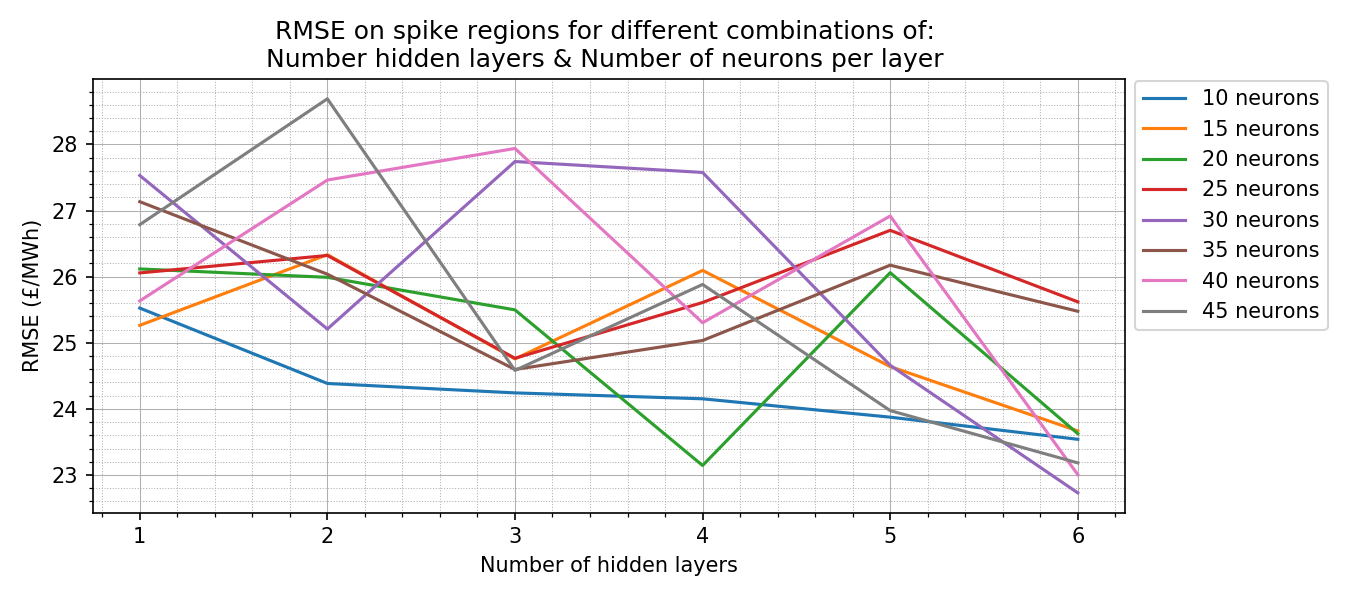

In [142]:
plt.figure(figsize=(9,4))
plt.plot(one, label = '10 neurons')
plt.plot(two, label = '15 neurons')
plt.plot(three, label = '20 neurons')
plt.plot(four, label = '25 neurons')
plt.plot(five, label = '30 neurons')
plt.plot(six, label = '35 neurons')
plt.plot(seven, label = '40 neurons')
plt.plot(eight, label = '45 neurons')
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.xticks([0,1,2,3,4,5], [1,2,3,4,5,6])
plt.xlabel('Number of hidden layers')
plt.ylabel('RMSE (£/MWh)')
plt.title('RMSE on spike regions for different combinations of: \nNumber hidden layers & Number of neurons per layer ')
plt.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()
plt.savefig('RMSE_spike_n_hidden_n_neurons.png')

<IPython.core.display.Javascript object>


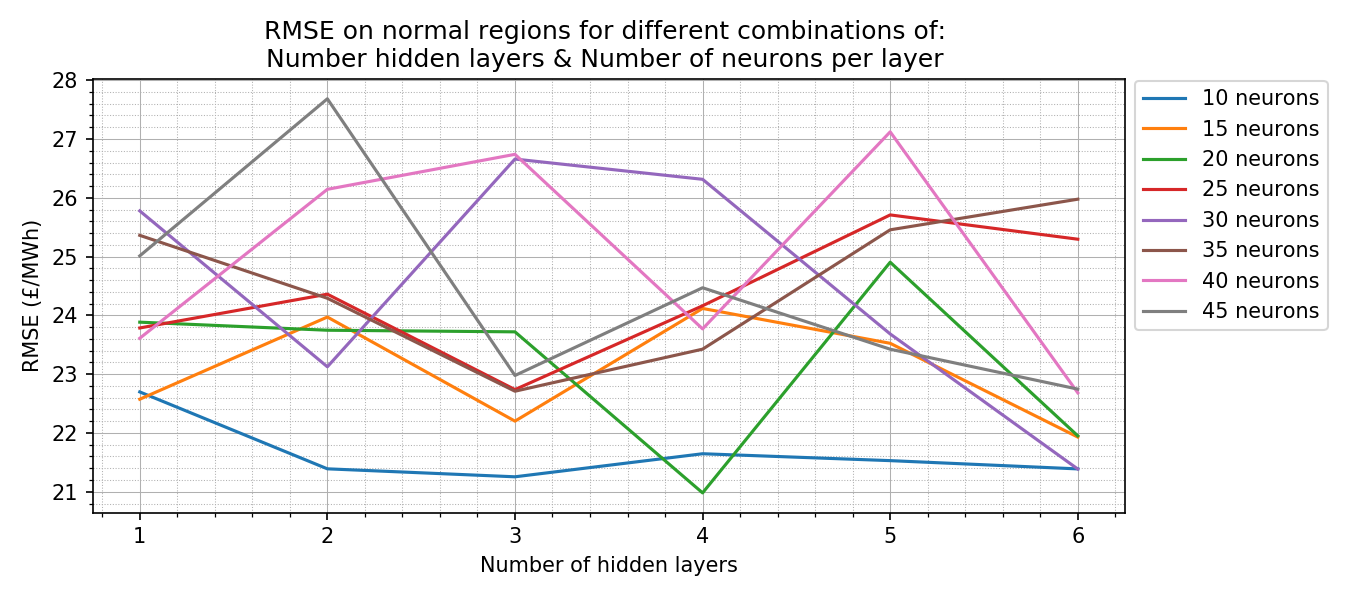

In [149]:
one = []
two = []
three = []
four = []
five = []
six = []
seven = []
eight = []


for i in range(6):
    one.append(rmse_nor[8 * i])
    two.append(rmse_nor[1 + (8 * i)])
    three.append(rmse_nor[2 + (8 * i)])
    four.append(rmse_nor[3 + (8 * i)])
    five.append(rmse_nor[4 + (8 * i)])
    six.append(rmse_nor[5 + (8 * i)])
    seven.append(rmse_nor[6 + (8 * i)])
    eight.append(rmse_nor[7 + (8 * i)])
    
plt.figure(figsize=(9,4))
plt.plot(one, label = '10 neurons')
plt.plot(two, label = '15 neurons')
plt.plot(three, label = '20 neurons')
plt.plot(four, label = '25 neurons')
plt.plot(five, label = '30 neurons')
plt.plot(six, label = '35 neurons')
plt.plot(seven, label = '40 neurons')
plt.plot(eight, label = '45 neurons')
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.xticks([0,1,2,3,4,5], [1,2,3,4,5,6])
plt.xlabel('Number of hidden layers')
plt.ylabel('RMSE (£/MWh)')
plt.title('RMSE on normal regions for different combinations of: \nNumber hidden layers & Number of neurons per layer ')
plt.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()
plt.savefig('RMSE_normal_n_hidden_n_neurons.png')

<IPython.core.display.Javascript object>


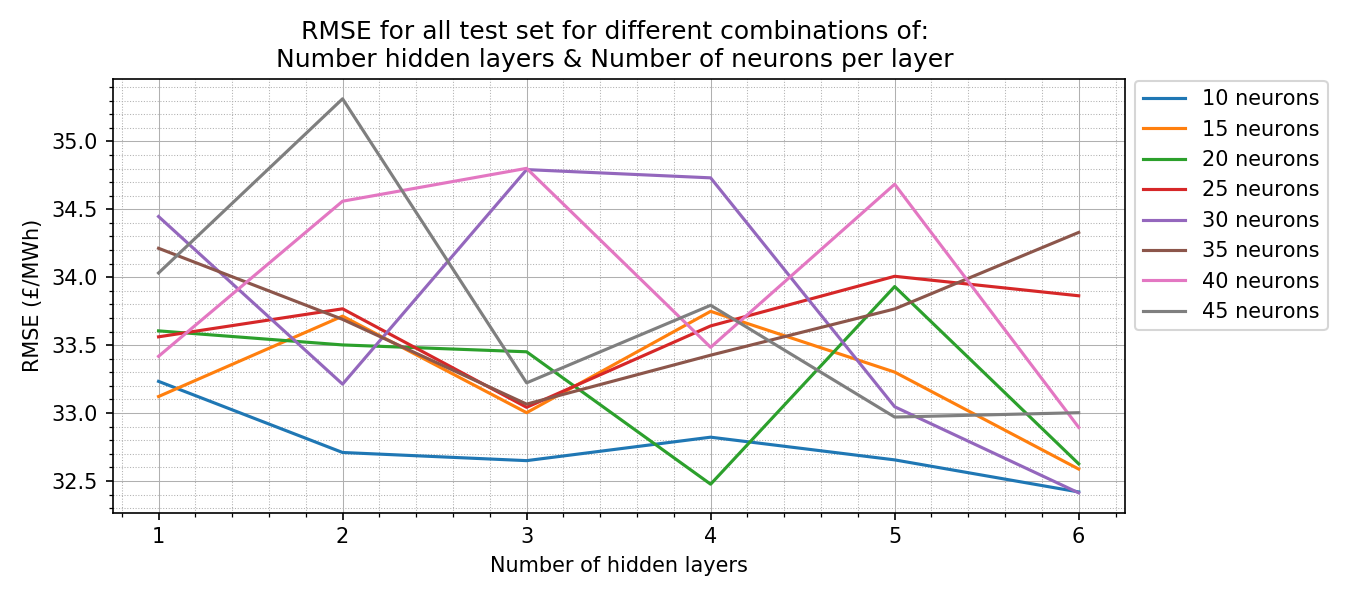

In [144]:
one = []
two = []
three = []
four = []
five = []
six = []
seven = []
eight = []


for i in range(6):
    one.append(rmse_gen[8 * i])
    two.append(rmse_gen[1 + (8 * i)])
    three.append(rmse_gen[2 + (8 * i)])
    four.append(rmse_gen[3 + (8 * i)])
    five.append(rmse_gen[4 + (8 * i)])
    six.append(rmse_gen[5 + (8 * i)])
    seven.append(rmse_gen[6 + (8 * i)])
    eight.append(rmse_gen[7 + (8 * i)])
    
plt.figure(figsize=(9,4))
plt.plot(one, label = '10 neurons')
plt.plot(two, label = '15 neurons')
plt.plot(three, label = '20 neurons')
plt.plot(four, label = '25 neurons')
plt.plot(five, label = '30 neurons')
plt.plot(six, label = '35 neurons')
plt.plot(seven, label = '40 neurons')
plt.plot(eight, label = '45 neurons')
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.xticks([0,1,2,3,4,5], [1,2,3,4,5,6])
plt.xlabel('Number of hidden layers')
plt.ylabel('RMSE (£/MWh)')
plt.title('RMSE for all test set for different combinations of: \nNumber hidden layers & Number of neurons per layer ')
plt.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()
plt.savefig('RMSE_general_n_hidden_n_neurons.png')

<IPython.core.display.Javascript object>


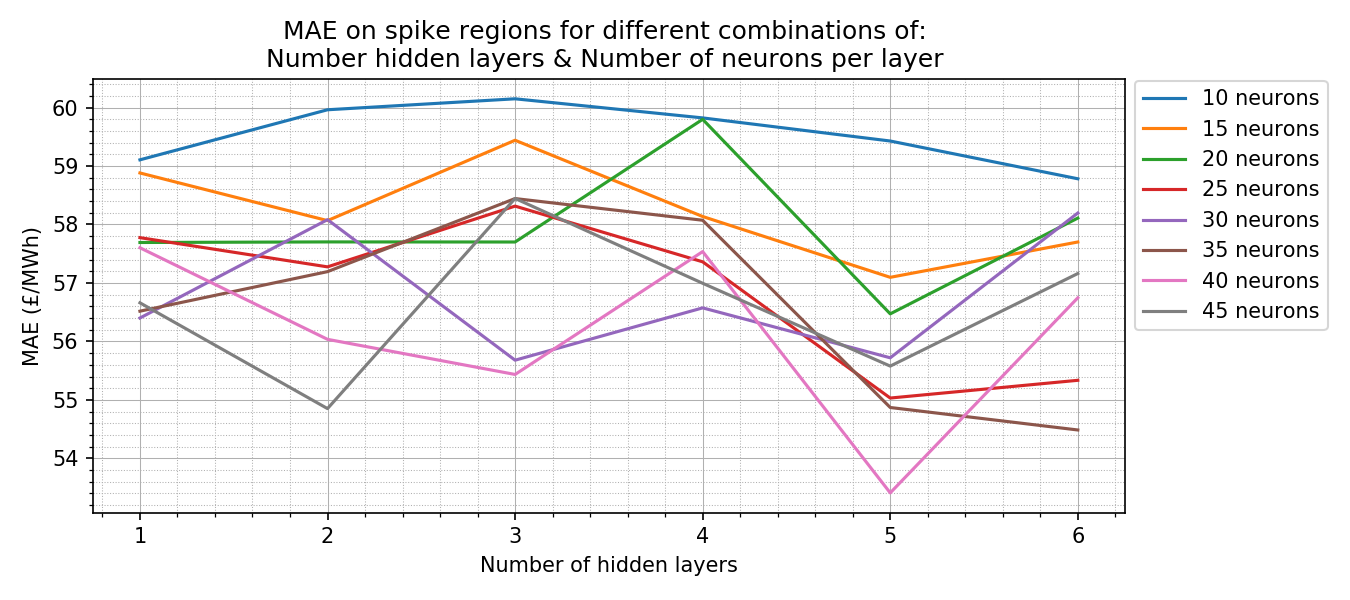

In [145]:
one = []
two = []
three = []
four = []
five = []
six = []
seven = []
eight = []


for i in range(6):
    one.append(mae_spi[8 * i])
    two.append(mae_spi[1 + (8 * i)])
    three.append(mae_spi[2 + (8 * i)])
    four.append(mae_spi[3 + (8 * i)])
    five.append(mae_spi[4 + (8 * i)])
    six.append(mae_spi[5 + (8 * i)])
    seven.append(mae_spi[6 + (8 * i)])
    eight.append(mae_spi[7 + (8 * i)])
    
plt.figure(figsize=(9,4))
plt.plot(one, label = '10 neurons')
plt.plot(two, label = '15 neurons')
plt.plot(three, label = '20 neurons')
plt.plot(four, label = '25 neurons')
plt.plot(five, label = '30 neurons')
plt.plot(six, label = '35 neurons')
plt.plot(seven, label = '40 neurons')
plt.plot(eight, label = '45 neurons')
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.xticks([0,1,2,3,4,5], [1,2,3,4,5,6])
plt.xlabel('Number of hidden layers')
plt.ylabel('MAE (£/MWh)')
plt.title('MAE on spike regions for different combinations of: \nNumber hidden layers & Number of neurons per layer ')
plt.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()
plt.savefig('MAE_spike_n_hidden_n_neurons.png')

<IPython.core.display.Javascript object>


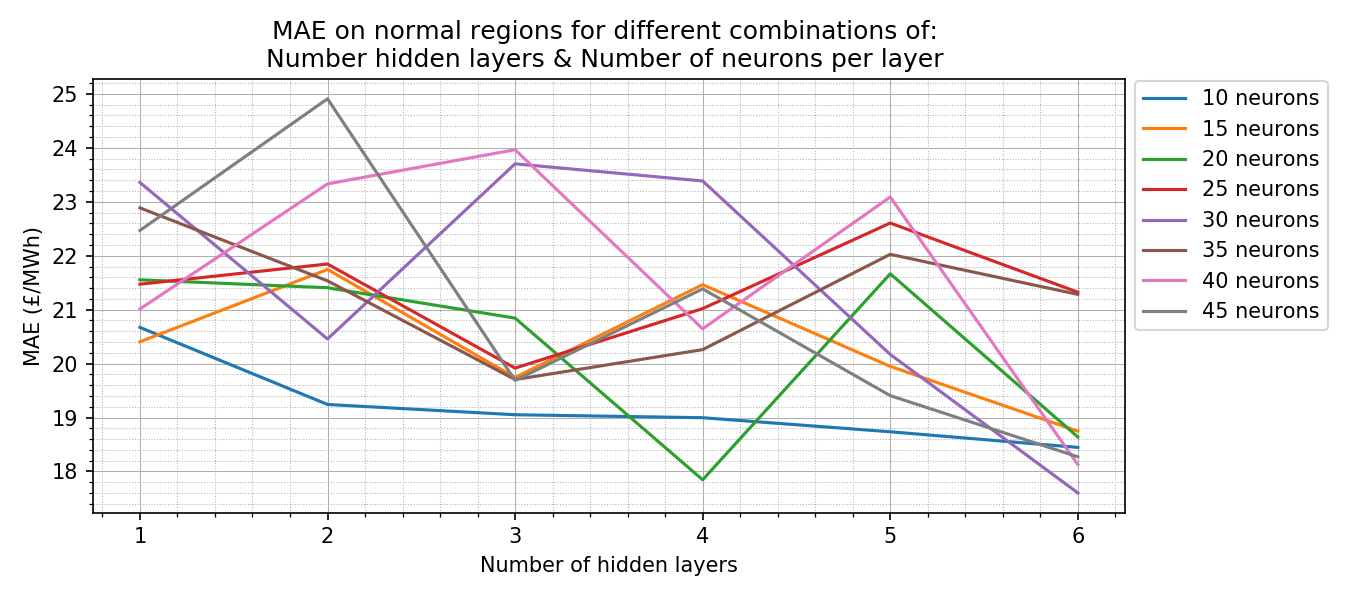

In [148]:
one = []
two = []
three = []
four = []
five = []
six = []
seven = []
eight = []


for i in range(6):
    one.append(mae_nor[8 * i])
    two.append(mae_nor[1 + (8 * i)])
    three.append(mae_nor[2 + (8 * i)])
    four.append(mae_nor[3 + (8 * i)])
    five.append(mae_nor[4 + (8 * i)])
    six.append(mae_nor[5 + (8 * i)])
    seven.append(mae_nor[6 + (8 * i)])
    eight.append(mae_nor[7 + (8 * i)])
    
plt.figure(figsize=(9,4))
plt.plot(one, label = '10 neurons')
plt.plot(two, label = '15 neurons')
plt.plot(three, label = '20 neurons')
plt.plot(four, label = '25 neurons')
plt.plot(five, label = '30 neurons')
plt.plot(six, label = '35 neurons')
plt.plot(seven, label = '40 neurons')
plt.plot(eight, label = '45 neurons')
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.xticks([0,1,2,3,4,5], [1,2,3,4,5,6])
plt.xlabel('Number of hidden layers')
plt.ylabel('MAE (£/MWh)')
plt.title('MAE on normal regions for different combinations of: \nNumber hidden layers & Number of neurons per layer ')
plt.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()
plt.savefig('MAE_normal_n_hidden_n_neurons.png')

<IPython.core.display.Javascript object>


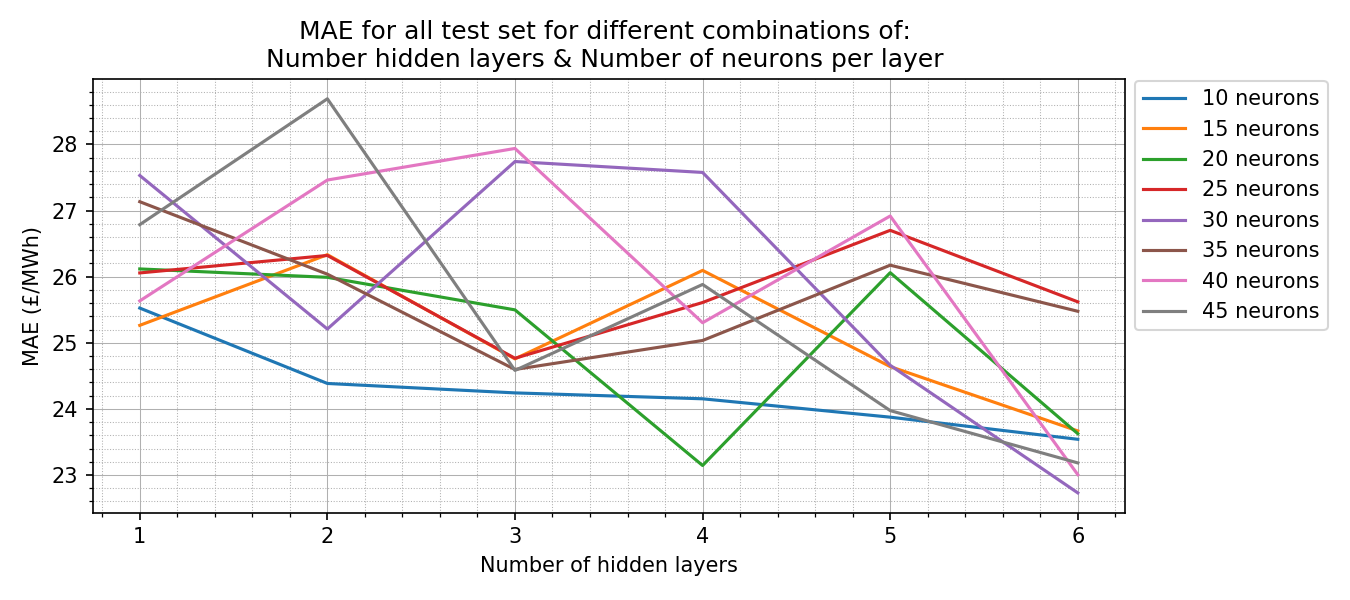

In [147]:
one = []
two = []
three = []
four = []
five = []
six = []
seven = []
eight = []


for i in range(6):
    one.append(mae_gen[8 * i])
    two.append(mae_gen[1 + (8 * i)])
    three.append(mae_gen[2 + (8 * i)])
    four.append(mae_gen[3 + (8 * i)])
    five.append(mae_gen[4 + (8 * i)])
    six.append(mae_gen[5 + (8 * i)])
    seven.append(mae_gen[6 + (8 * i)])
    eight.append(mae_gen[7 + (8 * i)])
    
plt.figure(figsize=(9,4))
plt.plot(one, label = '10 neurons')
plt.plot(two, label = '15 neurons')
plt.plot(three, label = '20 neurons')
plt.plot(four, label = '25 neurons')
plt.plot(five, label = '30 neurons')
plt.plot(six, label = '35 neurons')
plt.plot(seven, label = '40 neurons')
plt.plot(eight, label = '45 neurons')
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.xticks([0,1,2,3,4,5], [1,2,3,4,5,6])
plt.xlabel('Number of hidden layers')
plt.ylabel('MAE (£/MWh)')
plt.title('MAE for all test set for different combinations of: \nNumber hidden layers & Number of neurons per layer ')
plt.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()
plt.savefig('MAE_general_n_hidden_n_neurons.png')